In [ ]:
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.19

# import sys, os, shutil

# sys.path.append('/usr/local/lib/python3.7/site-packages/')
# os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
# os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
# os.environ['CONDA_PREFIX'] = '/usr/local'
# for so in ['cudf', 'rmm', 'nccl', 'cuml', 'cugraph', 'xgboost', 'cuspatial']:
#     fn = 'lib'+so+'.so'
#     source_fn = '/usr/local/lib/'+fn
#     dest_fn = '/usr/lib/'+fn
#     if os.path.exists(source_fn):
#         print(f'Copying {source_fn} to {dest_fn}')
#         shutil.copyfile(source_fn, dest_fn)
# if not os.path.exists('/usr/lib64'):
#     os.makedirs('/usr/lib64')
# for so_file in os.listdir('/usr/local/lib'):
#     if 'libstdc' in so_file:
#         shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib64/'+so_file)
#         shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib/x86_64-linux-gnu/'+so_file)

# Helper functions

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	diff = np.array(diff)
	return diff

In [ ]:
def inverse_diff(series, last_observation):
  series_undifferenced = series.copy()
  series_undifferenced[0] = series_undifferenced[0] + last_observation
  series_undifferenced = np.cumsum(series_undifferenced)
  series_undifferenced = np.insert(series_undifferenced,0,last_observation)

  return series_undifferenced

In [ ]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
 
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error, predictions
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = range(1,6)
	d_params = [1]
	q_params = range(1,6)
	t_params = ['n']
	P_params = [0, 1]
	D_params = [0, 1]
	Q_params = [0, 1]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [ ]:
def copernicusmarine_datastore(dataset, username, password):
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    return data_store

# Download dataset from https://resources.marine.copernicus.eu/product-download/OCEANCOLOUR_GLO_OPTICS_L3_NRT_OBSERVATIONS_009_030

Mediterranean Coordinate:
*   North(50.97916412353515625)
*   South(25.97916412353515625)
*   East(40.97916412353515625)
*   West(-10.97916412353515625)

In [ ]:
!pip install statsmodels
!pip install tabulate
# ! pip install tbats
!pip install pydap
!pip install texttable
!pip install latextable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.2 MB/s 
     |████████████████████████████████| 114 kB 37.3 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=60291521ad70205bf7d71a9505f3a162cd6ab118e069895d9cb9a46239b98af6
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for latextable: filename=latextable-0.3.0-py3-none-any.whl size=7254 sha256=8523c1fdff6

In [ ]:
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import random
import pickle
from PIL import Image
from IPython import display
import imageio
from math import sqrt
import warnings
import math

import xarray as xr
import getpass

from tqdm import tqdm

from pydap.client import open_url
from pydap.cas.get_cookies import setup_session

%matplotlib inline

import os

import scipy.stats as stats

from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from cycler import cycler 
from matplotlib import rcParams 

# from statsmodels.tsa.ar_model import AutoReg # New version of statsmodel somehow does not have this
from sklearn.metrics import mean_squared_error

# from statsmodels.tsa.arima.model import ARIMA # Same with this
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.cross_decomposition import CCA

from sklearn.inspection import permutation_importance

import random
import time

# from tabulate import tabulate
from tabulate import tabulate
from texttable import Texttable

import latextable

import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Sea Water Transparency") # need to change to your path

In [ ]:
import netCDF4 as nc
ds = nc.Dataset("/content/drive/MyDrive/Sea Water Transparency/Data/medi_y21m7d1_y22m3d8.nc") # need to change to your file
KD_data = nc.Dataset("/content/drive/MyDrive/Sea Water Transparency/Data/Mediterranean Data KD-daily.nc")
CHL_data = nc.Dataset("/content/drive/MyDrive/Sea Water Transparency/Data/Mediterranean Data CHL-daily.nc")
WIND_east_data1 = nc.Dataset("./Data/Mediterranean Data eastWIND(1)-daily.nc")
WIND_east_data2 = nc.Dataset("./Data/Mediterranean Data eastWIND(2)-daily.nc")
WIND_north_data1 = nc.Dataset("./Data/Mediterranean Data northWIND(1)-daily.nc")
WIND_north_data2 = nc.Dataset("./Data/Mediterranean Data northWIND(2)-daily.nc")
SWH_data = nc.Dataset("/content/drive/MyDrive/Sea Water Transparency/Data/Mediterranean Data SWH-daily.nc")

In [ ]:
def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session))
    return data_store

In [ ]:
USERNAME = 'jsuartono'
PASSWORD = 'Josiah12bryan09'
ZSD_DATASET_ID = 'dataset-oc-glo-opt-multi-l3-zsd_4km_daily-rt-v02'
KD_DATASET_ID = 'dataset-oc-glo-opt-multi-l4-kd490_interpolated_4km_daily-rt'
CHL_DATASET_ID = 'dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rt'
ST_DATASET_ID = 'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2'
WIND_DATASET_ID = 'KNMI-GLO-WIND_L3-REP-OBS_METOP-A_ASCAT_12_ASC'
O2_DATASET_ID = 'global-analysis-forecast-bio-001-028-daily'

In [ ]:
# data_store = copernicusmarine_datastore("dataset-oc-glo-opt-multi-l4-zsd_interpolated_4km_daily-rt", USERNAME, PASSWORD)
# data = xr.open_dataset(data_store)
# ds = data.sel(time=slice("2021-07-01","2022-03-07"))
# # sel_data = data["analysed_sst"].sel(time=slice("2021-07-01","2022-03-07"))
# # print(sel_data)
# ds

In [ ]:
# ds = ds.isel(lat = ds["lat"] <= 50.97916412353515625)
# ds = ds.isel(lat = ds["lat"] >= 25.97916412353515625)
# ds = ds.isel(lon = ds["lon"] <= 40.97916412353515625)
# ds = ds.isel(lon = ds["lon"] >= -10.97916412353515625)
# ds

In [ ]:
ds["time"]

<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    calendar: Gregorian
    units: days since 1900-01-01 00:00:00
    standard_name: time
    long_name: reference time
    axis: T
    valid_min: 0.0
    valid_max: 401767.0
    _ChunkSizes: 1
    _CoordinateAxisType: Time
unlimited dimensions: 
current shape = (250,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [ ]:
time_arr = ds["time"][:]
time_arr = np.array([datetime.datetime(1900, 1, 1, 0, 0, 0, 0) + datetime.timedelta(days=int(x)) for x in time_arr])
time_arr

array([datetime.datetime(2021, 7, 1, 0, 0),
       datetime.datetime(2021, 7, 2, 0, 0),
       datetime.datetime(2021, 7, 3, 0, 0),
       datetime.datetime(2021, 7, 4, 0, 0),
       datetime.datetime(2021, 7, 5, 0, 0),
       datetime.datetime(2021, 7, 6, 0, 0),
       datetime.datetime(2021, 7, 7, 0, 0),
       datetime.datetime(2021, 7, 8, 0, 0),
       datetime.datetime(2021, 7, 9, 0, 0),
       datetime.datetime(2021, 7, 10, 0, 0),
       datetime.datetime(2021, 7, 11, 0, 0),
       datetime.datetime(2021, 7, 12, 0, 0),
       datetime.datetime(2021, 7, 13, 0, 0),
       datetime.datetime(2021, 7, 14, 0, 0),
       datetime.datetime(2021, 7, 15, 0, 0),
       datetime.datetime(2021, 7, 16, 0, 0),
       datetime.datetime(2021, 7, 17, 0, 0),
       datetime.datetime(2021, 7, 18, 0, 0),
       datetime.datetime(2021, 7, 19, 0, 0),
       datetime.datetime(2021, 7, 20, 0, 0),
       datetime.datetime(2021, 7, 21, 0, 0),
       datetime.datetime(2021, 7, 22, 0, 0),
       datetime.dat

# Data Processing

In [ ]:
ds["ZSD"]

<class 'netCDF4._netCDF4.Variable'>
float32 ZSD(time, lat, lon)
    _FillValue: -999.0
    input_files_reprocessings: Processors versions: MODIS 2018.1QLP/VIIRSN 2018.0QL+2018.0QLP/OLCIA 07.01+07.01NR/VIIRSJ1 2018.0.1QL+2018.0.1QLP/OLCIB 07.01+07.01NR
    long_name: Secchi disk depth - Mean of the binned pixels
    valid_min: 0.0
    missing_value: -999.0
    valid_max: 1000.0
    standard_name: secchi_depth_of_sea_water
    units: m
    type: surface
    _ChunkSizes: [  1 256 256]
    coordinates: time lat lon 
unlimited dimensions: 
current shape = (250, 601, 1247)
filling on

This means 250 days of data, each day there are 601x1247 grid of data. Each point on the grid correspond to one latitude and longitude.

In [ ]:
zsd = ds["ZSD"][:,:,:].data

In [ ]:
zsd.shape

(250, 601, 1247)

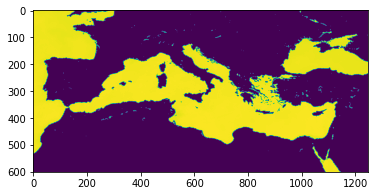

In [ ]:
plt.imshow(zsd[100,:,:])
plt.show()

## Initial Attempt using DF (Output: location_land, location_water)

In [ ]:
flat_zsd = []
for x in zsd:
  flat_zsd.append(x.flatten())

flat_zsd = np.array(flat_zsd)
flat_zsd = np.where(flat_zsd==-999,np.nan,flat_zsd)

latitude = ds["lat"][:,].data
longitude = ds["lon"][:,].data

lat_lon = []
for lat in latitude:
    for lon in longitude:
        lat_lon.append((lat,lon))

date_name = []
for d in ds['time'][:].data:
    date_name.append(d)

Flattened into 1-D array (aka disregarding the longitude and latitude of the data)

In [ ]:
df = pd.DataFrame(flat_zsd.transpose(),index=lat_lon,columns=date_name)
# each row correspond to a location, columns refers to a time point
print(df.shape)

df.tail()

(749447, 250)


44376.0  44377.0  44378.0  44379.0  44380.0  44381.0  \
(25.979164, 40.77084)       NaN      NaN      NaN      NaN      NaN      NaN   
(25.979164, 40.812508)      NaN      NaN      NaN      NaN      NaN      NaN   
(25.979164, 40.85417)       NaN      NaN      NaN      NaN      NaN      NaN   
(25.979164, 40.89584)       NaN      NaN      NaN      NaN      NaN      NaN   
(25.979164, 40.937508)      NaN      NaN      NaN      NaN      NaN      NaN   

                        44382.0  44383.0  44384.0  44385.0  ...  44616.0  \
(25.979164, 40.77084)       NaN      NaN      NaN      NaN  ...      NaN   
(25.979164, 40.812508)      NaN      NaN      NaN      NaN  ...      NaN   
(25.979164, 40.85417)       NaN      NaN      NaN      NaN  ...      NaN   
(25.979164, 40.89584)       NaN      NaN      NaN      NaN  ...      NaN   
(25.979164, 40.937508)      NaN      NaN      NaN      NaN  ...      NaN   

                        44617.0  44618.0  44619.0  44620.0  44621.0  44622.0  \
(25.979164, 40.77084)       NaN      NaN      NaN      NaN      NaN      NaN   
(25.979164, 40.812508)      NaN      NaN      NaN      NaN      NaN      NaN   
(25.979164, 40.85417)       NaN      NaN      NaN      NaN      NaN      NaN   
(25.979164, 40.89584)       NaN      NaN      NaN      NaN      NaN      NaN   
(25.979164, 40.937508)      NaN      NaN      NaN      NaN      NaN      NaN   

                        44623.0  44624.0  44625.0  
(25.979164, 40.77084)       NaN      NaN      NaN  
(25.979164, 40.812508)      NaN      NaN      NaN  
(25.979164, 40.85417)       NaN      NaN      NaN  
(25.979164, 40.89584)       NaN      NaN      NaN  
(25.979164, 40.937508)      NaN      NaN      NaN  

[5 rows x 250 columns]

some rows (locations) are all NaN, this either means that it is a land (therefore no readings), or unluckily that throughout the time there are clouds over this location of sea.

In [ ]:
location_land = df[df.isna().any(axis=1)].index.to_numpy()
location_water = df[~df.isna().any(axis=1)].index.to_numpy()

In [ ]:
location_water, location_land

(array([(50.979164, -10.979161), (50.979164, -10.937495),
        (50.979164, -10.895828), ..., (25.979164, 36.60417),
        (25.979164, 36.64584), (25.979164, 36.687508)], dtype=object),
 array([(50.979164, -4.5208282), (50.979164, -4.4791613),
        (50.979164, -4.4374948), ..., (25.979164, 40.85417),
        (25.979164, 40.89584), (25.979164, 40.937508)], dtype=object))

In [ ]:
print(f"Before: {location_water.shape}")
location_water = np.array([item for t in location_water for item in t]).reshape(-1,2)
print(f"After: {location_water.shape}")

Before: (242789,)
After: (242789, 2)


In [ ]:
print(f"Before: {location_land.shape}")
location_land = np.array([item for t in location_land for item in t]).reshape(-1,2)
print(f"After: {location_land.shape}")

Before: (506658,)
After: (506658, 2)


In [ ]:
del df,flat_zsd

## Distance to Coastline

Approach: KDTree, Dijkstra Algo

In [ ]:
# random.seed(10)
# rad_ix = sample(range(location_water.shape[0]),10000)
# n = 1000
# josiah_set = [0,80929]
# deelan_set = [80929,161859]
# grace_set = [161859,242789]
# set_dict = {"josiah":josiah_set,"deelan":deelan_set,"grace":grace_set}
# set_range = set_dict[runner]
# a = location_water[set_range[0]:set_range[1],:]
# b = location_land

# min_dist_map = []
# for location in a:
#   tree = KDTree(location.reshape(-1,2))
#   (distance,neighbors) = tree.query(b,k=1)

#   min_dist_map.append(distance.min())

# name_range = str(set_range[0])+"_"+str(set_range[1])
# with open(f'dist{name_range}', 'wb') as fp:
#     pickle.dump(min_dist_map, fp)

In [ ]:
# from math import radians
# earth_radius = 6371000 # meters in earth
# test_radius = 1300000 # meters
# print(test_radius/earth_radius)

# test_points = [[32.027240,-81.093190],[41.981876,-87.969982]]
# test_points_rad = np.array([[radians(x[0]), radians(x[1])] for x in test_points ])

# tree = BallTree(test_points_rad, metric = 'haversine')
# ind,results = tree.query_radius(test_points_rad, r=test_radius/earth_radius, 
# return_distance  = True)


# print(ind)
# print(results*earth_radius)
# print(results * earth_radius/1000)

In [ ]:
location_water.shape

(242789, 2)

In [ ]:
# import numpy as np
# from scipy.spatial import distance

In [ ]:
# min_dist_map = []
# for i in range(0,location_water.shape[0]-3000,3000):
#   min_dist_map.extend(distance.cdist(location_water[i:i+3000],location_land).min(axis=1))

In [ ]:
# for i in range(240000,location_water.shape[0]):
#   min_dist_map.extend(distance.cdist([location_water[i]],location_land).min(axis=1))

In [ ]:
# with open('./Results/new_distance', 'wb') as fp:
#     pickle.dump(min_dist_map, fp)

In [ ]:
with open('./Results/new_distance', 'rb') as fp:
   aggr_min_dist_map  = pickle.load(fp)
aggr_min_dist_map = np.array(aggr_min_dist_map)

In [ ]:
# josiah_set = [0,80929]
# deelan_set = [80929,161859]
# grace_set = [161859,242789]

# set_dict = {"josiah":josiah_set,"deelan":deelan_set,"grace":grace_set}

# aggr_min_dist_map = []
# for i in set_dict.values():
#   name_range = str(i[0])+"_"+str(i[1])
#   with open (f'./Results/dist{name_range}', 'rb') as fp:
#       itemlist = pickle.load(fp)
#       aggr_min_dist_map+=itemlist

# aggr_min_dist_map = np.array(aggr_min_dist_map) # convert lat, lon to km?

In [ ]:
aggr_min_dist_map.shape

(242789,)

In [ ]:
# location_water.shape, aggr_min_dist_map.shape

In [ ]:
aggr_min_dist_map.max()

5.532260067389296

Text(0.5, 1.0, 'Distance to coastline map')

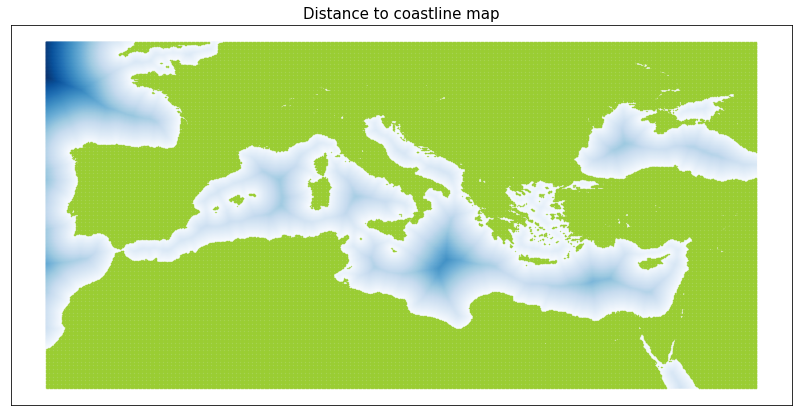

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(location_water[:,1],location_water[:,0],0.1,c=aggr_min_dist_map, cmap='Blues') # water (dist to coastline)
# plt.colorbar()
plt.scatter(location_land[:,1],location_land[:,0],0.1,c="yellowgreen",alpha=1,label="land") # land, no overlap
plt.xticks([])
plt.yticks([])
plt.title("Distance to coastline map",fontsize=15)
# plt.savefig("Distance_to_coastline.pdf", bbox_inches="tight")

Definition of Deep Sea:
- Actual Depth of the Sea instead of the distance to coastline (4km?)
- If include Sea Depth (Sea Level), maybe use percentage of Sea Level instead of straight ZSD?
- TODO: Find Sea floor data (hopefully high enough resolution)

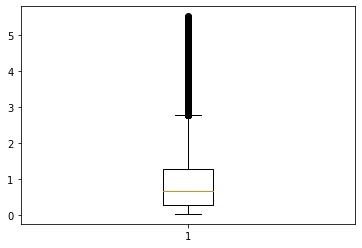

In [ ]:
plt.boxplot(aggr_min_dist_map)
plt.show()

In [ ]:
aggr_min_dist_map[0]

5.356881252567151

In [ ]:
medi_dist_to_coastline = np.zeros((latitude.shape[0],longitude.shape[0]))
for ind, (lat,lon) in enumerate(location_water):
  lat_ind = np.where(latitude==lat)[0]
  lon_ind = np.where(longitude==lon)[0]
  medi_dist_to_coastline[lat_ind,lon_ind] = aggr_min_dist_map[ind]

TODO:
- correlation of min/max/mean of ZSD with distance to coastline

In [ ]:
# medi_dist_to_coastline.shape, aggr_min_dist_map.shape, location_land.shape

In [ ]:
# aggr_min_dist_map.shape

In [ ]:
# aggr_min_dist_map[242789]

In [ ]:
# medi_dist_to_coastline[600,1138] 

In [ ]:
# medi_dist_to_coastline

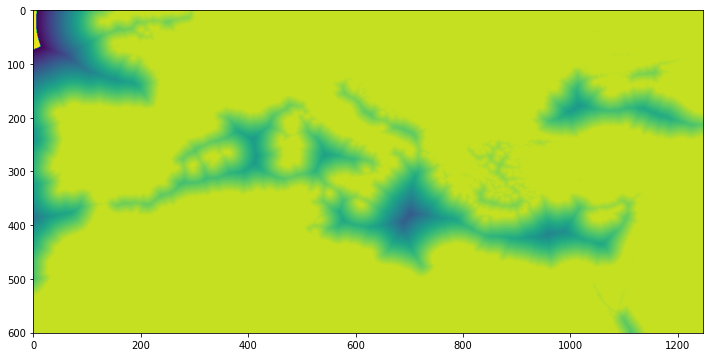

In [ ]:
plt.figure(figsize=(12,20))
arr_temp = ((255 - np.where(medi_dist_to_coastline==-10,100000,medi_dist_to_coastline)) / medi_dist_to_coastline.max() * 255).astype(np.uint8)
# img = Image.fromarray(arr,mode='L')
# img.resize((zsd.shape[0], zsd.shape[0]))
img_temp = Image.fromarray(arr_temp)
# img = img.resize((1247,601))
plt.imshow(img_temp)
plt.show()

## Sample from neighbouring points (Output numpy array of 0/1: medi_only)

In [ ]:
zsd =  np.where(zsd==-999,np.nan,zsd)

In [ ]:
# i want to get all the locations that are nan all through out the day
water_map = np.zeros(zsd[0,:,:].shape)
zero_counter = 0
for i in range(latitude.shape[0]):
  for j in range(longitude.shape[0]):
    if np.isnan(zsd[:,i,j].sum()):
      zero_counter+=1
    else:
      water_map[i,j] = 1
print(f"Found {zero_counter} land")

Found 506658 land


In [ ]:
# plt.figure(figsize=(12,20))
# arr = ((255 - water_map) / water_map.max() * 255).astype(np.uint8)
# # img = Image.fromarray(arr,mode='L')
# # img.resize((zsd.shape[0], zsd.shape[0]))
# img = Image.fromarray(arr)
# # img = img.resize((1247,601))
# # plt.scatter(129,360)
# plt.imshow(img)
# plt.xticks([])
# plt.yticks([])
# plt.savefig("Binary_map.pdf", bbox_inches="tight")
# plt.show()

Need to manually block off the water bodies for DFS to work~

Adding barrier of size: 40,3


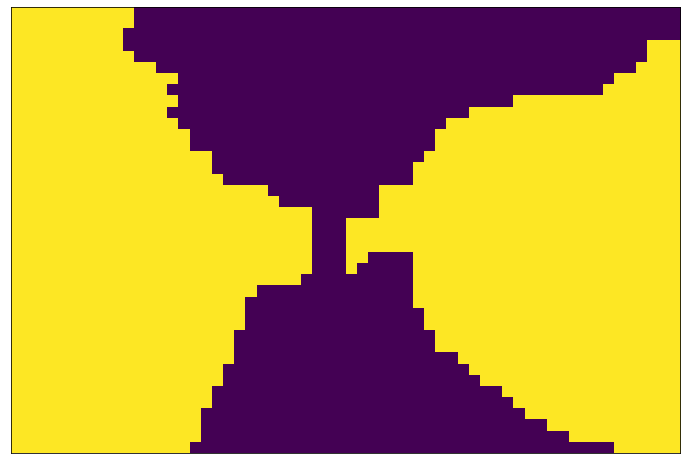

In [ ]:
plt.figure(figsize=(12,20))
temp = water_map


temp = water_map[340:380,127:130]
print(f"Adding barrier of size: {temp.shape[0]},{temp.shape[1]}")
water_map[340:380,127:130] = np.zeros((temp.shape[0],temp.shape[1]))
temp = water_map[340:380,100:160]
arr_temp = ((255 - temp) / temp.max() * 255).astype(np.uint8)
# img = Image.fromarray(arr,mode='L')
# img.resize((zsd.shape[0], zsd.shape[0]))
img_temp = Image.fromarray(arr_temp)
# img = img.resize((1247,601))
plt.imshow(img_temp)
plt.xticks([])
plt.yticks([])
# plt.savefig("block_medi_north.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Implement DFS without recursion

def DFS_no_rec(grid,label,xstart,ystart):
  stack = [(xstart,ystart)]
  h = len(grid)
  l = len(grid[0])
  while stack:
    current = stack.pop()
    row = current[0]
    col = current[1]
    if(row<0 or col<0 or row>=h or col>=l or grid[row][col]!=1):
      continue

    grid[row][col] = int(label)

    stack.append((row,col-1))
    stack.append((row ,col+1))
    stack.append((row-1, col))
    stack.append((row+1, col))

In [ ]:
label = 1000000
for i in range(len(water_map)):
  for j in range(len(water_map[0])):
    DFS_no_rec(water_map,label,i,j)
    label+=5

In [ ]:
latitude.shape

(601,)

In [ ]:
min(latitude),max(latitude)

(25.979164, 50.979164)

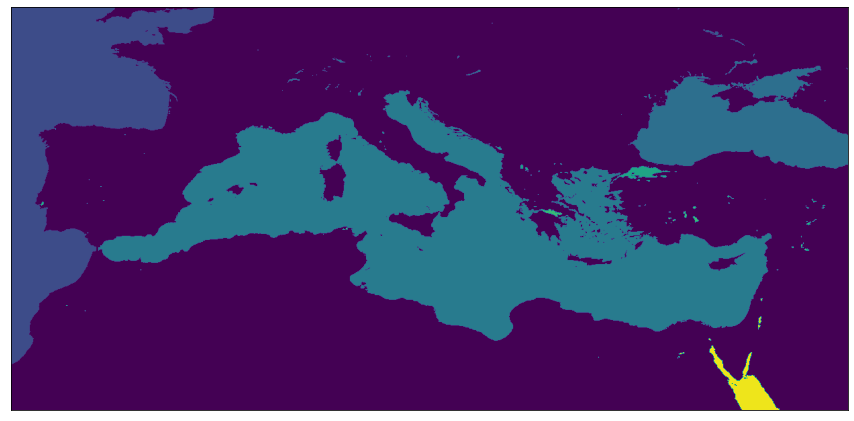

In [ ]:
plt.figure(figsize=(15,25))
arr_temp = -((255 - water_map) / water_map.max() * 255).astype(np.uint8)
# img = Image.fromarray(arr,mode='L')
# img.resize((zsd.shape[0], zsd.shape[0]))
img_temp = Image.fromarray(arr_temp)
# img = img.resize((1247,601))
plt.imshow(img_temp)
plt.xticks([])
plt.yticks([])
# plt.savefig("labelled_water.pdf", bbox_inches="tight")
plt.show()

In [ ]:
unique, counts = np.unique(water_map, return_counts=True)
freq_table = np.asarray((unique, counts)).T
freq_table = freq_table[freq_table[:,1].argsort()[::-1]]
print("  Tile Label |   Count")
print(freq_table[:20])
print(freq_table.shape)

  Tile Label |   Count
[[0.000000e+00 5.066740e+05]
 [1.782320e+06 1.471450e+05]
 [1.000000e+06 6.132000e+04]
 [1.560910e+06 2.932600e+04]
 [4.153895e+06 2.988000e+03]
 [2.488625e+06 7.000000e+02]
 [1.498100e+06 1.480000e+02]
 [2.886920e+06 1.440000e+02]
 [1.229635e+06 6.000000e+01]
 [1.595805e+06 4.000000e+01]
 [2.956635e+06 3.700000e+01]
 [1.675475e+06 3.500000e+01]
 [3.886150e+06 3.400000e+01]
 [1.494990e+06 2.900000e+01]
 [2.906695e+06 2.700000e+01]
 [1.267160e+06 2.300000e+01]
 [1.781985e+06 2.200000e+01]
 [2.475260e+06 2.200000e+01]
 [2.576060e+06 2.200000e+01]
 [2.306755e+06 1.900000e+01]]
(213, 2)


The majority of the tiles are land, 505908 land found before + manually added barrier (40,3) which intersect with some of the land = 505924. Label=156466 has the second highest count, which refers to the mediterranean sea. This will the label which I isolate for further analysis.

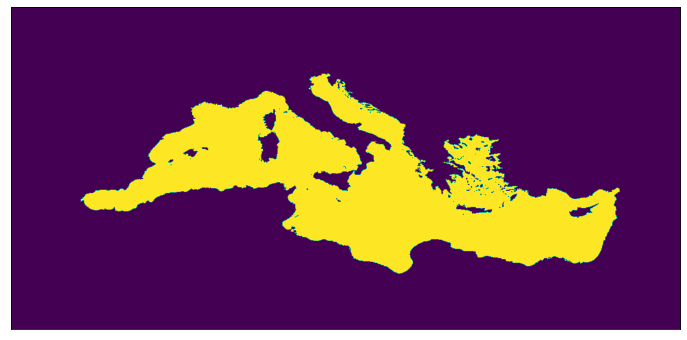

In [ ]:
medi_only = np.where(water_map!=freq_table[1][0],0,1) # setting all other tiles to 0

plt.figure(figsize=(12,20))
arr_temp = ((255 - medi_only) / medi_only.max() * 255).astype(np.uint8) # change to blue
img_temp = Image.fromarray(arr_temp)
plt.imshow(img_temp)
# plt.title("Showing Mediterranean Only",fontsize=20)
plt.xticks([])
plt.yticks([])
# plt.savefig("medi_only_map.pdf", bbox_inches="tight")
plt.show()

In [ ]:
zsd.shape, medi_only.shape

((250, 601, 1247), (601, 1247))

In [ ]:
medi_zsd = np.zeros((zsd.shape))
for i in range(250):
  medi_zsd[i,:,:] = zsd[i,:,:]*medi_only

In [ ]:
# plt.figure(figsize=(10,12))
# arr_medi = (255 - np.where(medi_zsd==0,-10,medi_zsd) / medi_zsd.max() * 255).astype(np.uint8)
# img_medi = Image.fromarray(arr_medi[0,:,:])
# plt.imshow(img_medi)
# plt.xticks([])
# plt.yticks([])
# #plt.colorbar(label="Colorbar", orientation="horizontal")
# plt.savefig("zsd_mediOnly.pdf", bbox_inches="tight")
# plt.show

In [ ]:
# (n_snapshots, w, h) = arr_medi.shape
# # frames between transitions
# n_frames = 5
# plt.figure(figsize=(10,12))

# with imageio.get_writer('medi_water_tranparency.gif', mode='I') as writer:
#   for m, d, i in zip(arr_medi, ds['time'][:].data, range(n_snapshots)):
#     zsd = m
#     date = datetime.date(1900, 1, 1) + datetime.timedelta(days=int(d))
#     arr = (255 - np.where(zsd == 0, -10, zsd) / zsd.max() * 255).astype(np.uint8)
#     img = Image.fromarray(arr)
#     plt.title("%s (day %s)"%(date, i + 1))
#     plt.imshow(img)
#     filename = "snapshot_%s.pdf", bbox_inches="tight"%(i)
#     plt.savefig(filename)
#     image = imageio.imread(filename)
#     for n in range(n_frames):
#       writer.append_data(image)    
#     os.remove(filename)
#     if i > 90: 
#       break

In [ ]:
# with open('medi_water_tranparency.gif','rb') as f:
#     display.display(display.Image(data=f.read(), format='png'))

In [ ]:
medi_dist_to_coastline = medi_dist_to_coastline*medi_only

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# fig=plt.figure()
# ax = plt.axes()
# im = ax.imshow(np.arange(100).reshape((10,10)))

# # Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
# # You can change 0.01 to adjust the distance between the main image and the colorbar.
# # You can change 0.02 to adjust the width of the colorbar.
# # This practice is universal for both subplots and GeoAxes.

# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

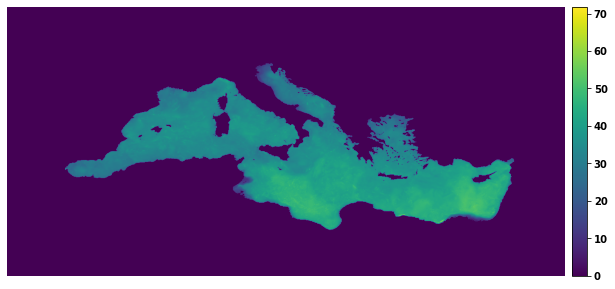

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
mean_zsd_map = medi_zsd.max(axis=0)
mean_zsd_map = np.nan_to_num(mean_zsd_map)
im = ax.imshow(mean_zsd_map)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im,cax=cax)

for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")
    l.set_fontsize(10)

plt.show()

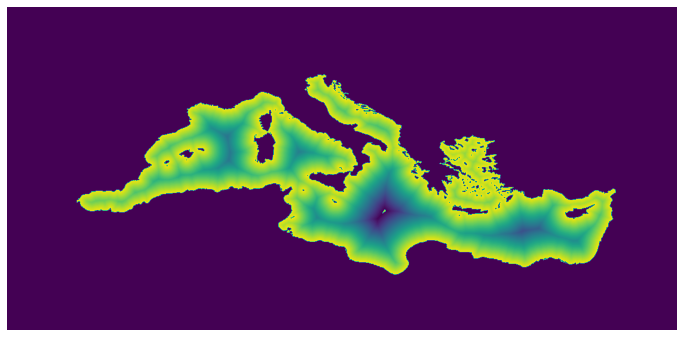

In [ ]:
fig = plt.figure(figsize=(12,20))
ax = plt.axes()
arr_temp = ((255 - np.where(medi_dist_to_coastline==0,np.nan,medi_dist_to_coastline)) / medi_dist_to_coastline.max() * 255).astype(np.uint8)
# img = Image.fromarray(arr,mode='L')
# img.resize((zsd.shape[0], zsd.shape[0]))
# im = Image.fromarray(arr_temp)
# img = img.resize((1247,601))

im = ax.imshow(arr_temp)
plt.axis("off")
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
#plt.colorbar(label="Colorbar", orientation="horizontal")
plt.savefig("Distance_to_Coastline_mediOnly.pdf", bbox_inches="tight")
plt.show()

In [ ]:
medi_lat_lon = []
for i in range(medi_dist_to_coastline.shape[0]):
  for j in range(medi_dist_to_coastline.shape[1]):
   if medi_dist_to_coastline[i,j] != 0:
     medi_lat_lon.append((i,j))
medi_lat_lon = np.array(medi_lat_lon)

In [ ]:
medi_lat_lon

array([[125, 589],
       [125, 590],
       [126, 578],
       ...,
       [497, 722],
       [497, 723],
       [497, 724]])

In [ ]:
zsd_arr_all = []
for lat, lon in medi_lat_lon:
  zsd_arr_all.append(medi_zsd[:,lat,lon])
zsd_arr_all = np.array(zsd_arr_all)

In [ ]:
zsd_arr_all.shape

(147145, 250)

In [ ]:
dist_arr_all = []
for lat,lon in medi_lat_lon:
  dist_arr_all.append(medi_dist_to_coastline[lat,lon])
dist_arr_all = np.array(dist_arr_all)

In [ ]:
dist_arr_all.shape

(147145,)

In [ ]:
np.correlate(zsd_arr_all.mean(axis=1),dist_arr_all)

array([3155766.49343533])

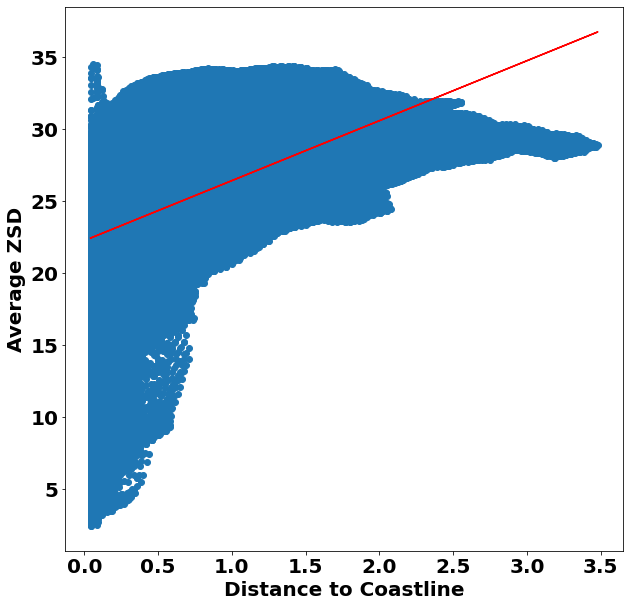

4.159787669219431 22.26937675068395


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(dist_arr_all,zsd_arr_all.mean(axis=1),'o',rasterized=True)
a, b = np.polyfit(dist_arr_all, zsd_arr_all.mean(axis=1), 1)
plt.plot(dist_arr_all, a*dist_arr_all+b,color="r")
plt.xlabel('Distance to Coastline', fontsize=20,fontweight="bold")
plt.ylabel('Average ZSD', fontsize=20,fontweight="bold")
plt.xticks(fontsize=20,fontweight="bold")
plt.yticks(fontsize=20,fontweight="bold")
plt.savefig("mean_zsd_distToCoast.pdf")
plt.show()
print(a,b)

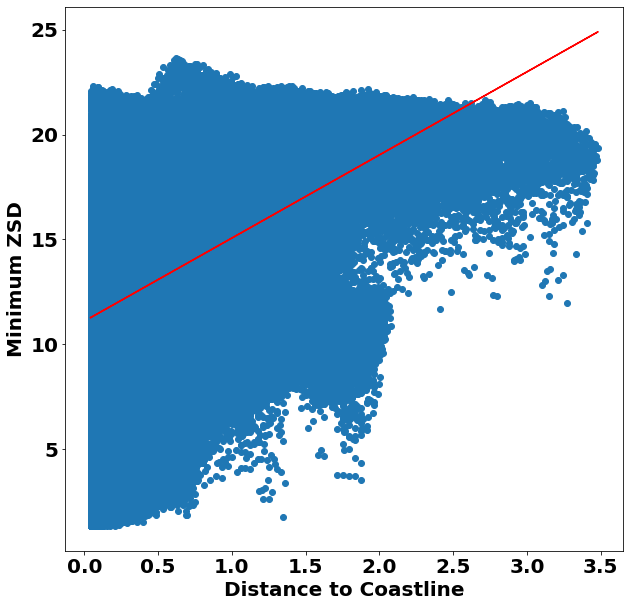

3.9634962043657525 11.102488076507687


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(dist_arr_all,zsd_arr_all.min(axis=1),'o',rasterized=True)
a, b = np.polyfit(dist_arr_all, zsd_arr_all.min(axis=1), 1)
plt.plot(dist_arr_all, a*dist_arr_all+b,color="r")
plt.xlabel('Distance to Coastline', fontsize=20,fontweight="bold")
plt.ylabel('Minimum ZSD', fontsize=20,fontweight="bold")
plt.xticks(fontsize=20,fontweight="bold")
plt.yticks(fontsize=20,fontweight="bold")
plt.savefig("min_zsd_distToCoast.pdf")
plt.show()
print(a,b)

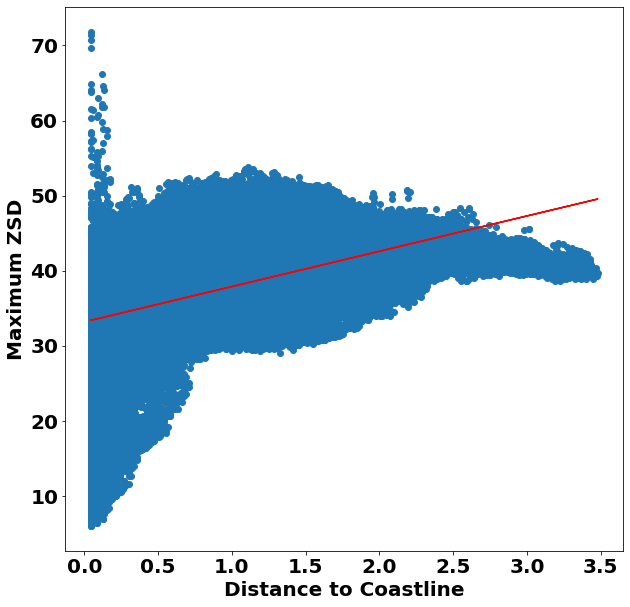

4.698549404860036 33.20171096676972


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(dist_arr_all,zsd_arr_all.max(axis=1),'o',rasterized=True)
a, b = np.polyfit(dist_arr_all, zsd_arr_all.max(axis=1), 1)
plt.plot(dist_arr_all, a*dist_arr_all+b,color="r")
plt.xlabel('Distance to Coastline', fontsize=20,fontweight="bold")
plt.ylabel('Maximum ZSD', fontsize=20,fontweight="bold")
plt.xticks(fontsize=20,fontweight="bold")
plt.yticks(fontsize=20,fontweight="bold")
plt.savefig("max_zsd_distToCoast.pdf")
plt.show()
print(a,b)

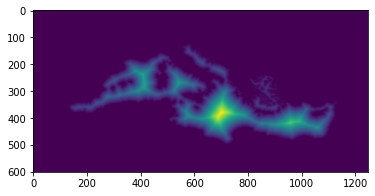

In [ ]:
plt.imshow(medi_dist_to_coastline)
plt.show()

In [ ]:
medi_only.shape

(601, 1247)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# fig=plt.figure()
# ax = plt.axes()
# im = ax.imshow(np.arange(100).reshape((10,10)))

# # Create an axes for colorbar. The position of the axes is calculated based on the position of ax.
# # You can change 0.01 to adjust the distance between the main image and the colorbar.
# # You can change 0.02 to adjust the width of the colorbar.
# # This practice is universal for both subplots and GeoAxes.

# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)

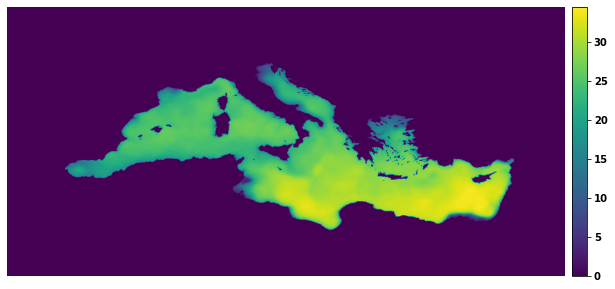

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
mean_zsd_map = medi_zsd.mean(axis=0)
mean_zsd_map = np.nan_to_num(mean_zsd_map)
im = ax.imshow(mean_zsd_map)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im,cax=cax)

for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")
    l.set_fontsize(10)

plt.show()

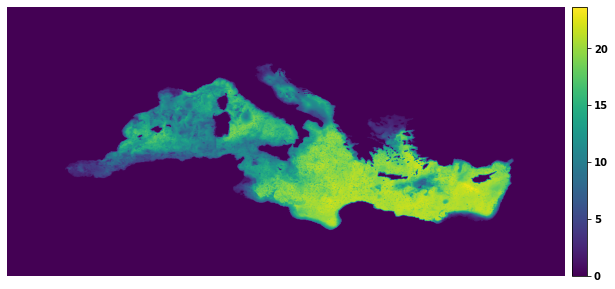

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
mean_zsd_map = medi_zsd.min(axis=0)
mean_zsd_map = np.nan_to_num(mean_zsd_map)
im = ax.imshow(mean_zsd_map)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im,cax=cax)

for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")
    l.set_fontsize(10)

plt.show()

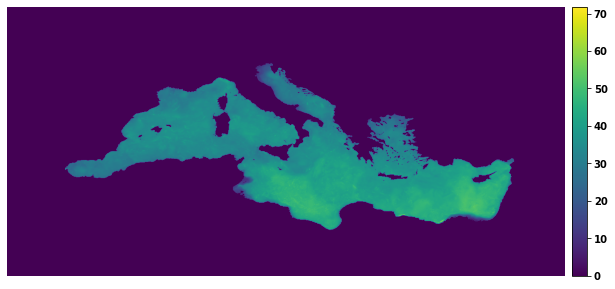

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
mean_zsd_map = medi_zsd.max(axis=0)
mean_zsd_map = np.nan_to_num(mean_zsd_map)
im = ax.imshow(mean_zsd_map)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im,cax=cax)

for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")
    l.set_fontsize(10)

plt.show()

## kxk neighbour around a point

In [ ]:
# plt.hist(medi_dist_to_coastline.flatten())
# plt.xlabel("Distance")
# plt.ylabel("Count")
# plt.show()

In [ ]:
dist_unique, dist_counts = np.unique(medi_dist_to_coastline.flatten(), return_counts=True)
dist_freq_table = np.asarray((dist_unique, dist_counts)).T
dist_freq_table = dist_freq_table[dist_freq_table[:,1].argsort()[::-1]]
print("  Tile Label |   Count")
print(dist_freq_table[:20])
print(dist_freq_table.shape)

  Tile Label |   Count
[[0.00000000e+00 6.02302000e+05]
 [4.16679382e-02 2.27800000e+03]
 [1.25000000e-01 1.94800000e+03]
 [8.33320618e-02 1.79000000e+03]
 [4.16641235e-02 1.59300000e+03]
 [4.16660309e-02 1.31300000e+03]
 [2.50000000e-01 1.03200000e+03]
 [2.79508497e-01 9.87000000e+02]
 [1.50230598e-01 9.65000000e+02]
 [1.66667938e-01 8.63000000e+02]
 [1.76776695e-01 7.83000000e+02]
 [5.89260147e-02 7.22000000e+02]
 [2.08332062e-01 7.04000000e+02]
 [3.75000000e-01 6.73000000e+02]
 [8.33358765e-02 6.58000000e+02]
 [8.33339691e-02 6.13000000e+02]
 [4.16669846e-02 6.11000000e+02]
 [1.31761971e-01 6.00000000e+02]
 [6.25000000e-01 5.79000000e+02]
 [2.42955239e-01 5.53000000e+02]]
(15949, 2)


In [ ]:
# plt.figure(figsize=(12,20))
# arr_temp = ((255 - np.where(copy==-10,100000,copy)) / copy.max() * 255).astype(np.uint8)
# # img = Image.fromarray(arr,mode='L')
# # img.resize((zsd.shape[0], zsd.shape[0]))
# img_temp = Image.fromarray(arr_temp)
# # img = img.resize((1247,601))
# plt.imshow(img_temp)
# plt.show()

Coastline Only V.S Deep Sea

Or, given near coastline (within distance D), get valid points

To get temperature data with ZSD, either use a statistics (mean,medium,max,etc.) for each box from the 4kmx4km. Or treat it as a image zip? downscaling?

CNN, maxpooling

In [ ]:
def haveLandInK(grid,center,k):
  x,y = center
  if int(x-k/2)<0 or int(x+k/2)>grid.shape[0] or int(y-k/2)<0 or int(y+k/2)>grid.shape[1]:
    return False
  else:
    return grid[int(x-k/2):int(x+k/2),int(y-k/2):int(y+k/2)].all()

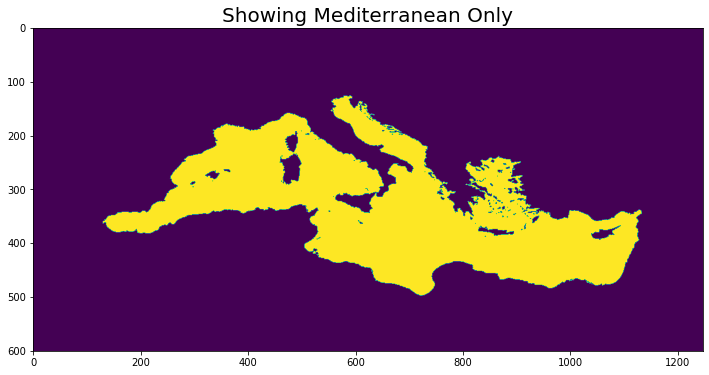

In [ ]:
medi_only = np.where(water_map!=freq_table[1][0],0,1) # setting all other tiles to 0

plt.figure(figsize=(12,20))
arr_temp = ((255 - medi_only) / medi_only.max() * 255).astype(np.uint8) # change to blue
img_temp = Image.fromarray(arr_temp)
plt.imshow(img_temp)
plt.title("Showing Mediterranean Only",fontsize=20)
plt.show()

In [ ]:
# k = 21 # use only odd k, or else the kxk's center is shifted to the bottom right! Try k<=3 for now. k=1,3
# have_k_neigh = np.zeros(medi_only.shape)
# for i in range(medi_only.shape[0]):
#   for j in range(medi_only.shape[1]):
#     if haveLandInK(medi_only,(i,j),k):
#       have_k_neigh[i,j] = 1

# # plt.figure(figsize=(12,20))
# # arr_temp = ((255 - np.where(have_k_neigh==-10,100000,have_k_neigh)) / have_k_neigh.max() * 255).astype(np.uint8)
# # img_temp = Image.fromarray(arr_temp)
# # # img = img.resize((1247,601))
# # plt.imshow(img_temp)
# # plt.xticks([])
# # plt.yticks([])
# # # plt.title(f"Showing valid sampling point (All water in the {k}x{k} box around)",fontsize=20)
# # plt.savefig("large_k_by_k.pdf", bbox_inches="tight")
# # plt.show()

In [ ]:
k = 3 # use only odd k, or else the kxk's center is shifted to the bottom right! Try k<=3 for now. k=1,3
have_k_neigh = np.zeros(medi_only.shape)
for i in range(medi_only.shape[0]):
  for j in range(medi_only.shape[1]):
    if haveLandInK(medi_only,(i,j),k):
      have_k_neigh[i,j] = 1

# plt.figure(figsize=(12,20))
# arr_temp = ((255 - np.where(have_k_neigh==-10,100000,have_k_neigh)) / have_k_neigh.max() * 255).astype(np.uint8)
# img_temp = Image.fromarray(arr_temp)
# # img = img.resize((1247,601))
# plt.imshow(img_temp)
# plt.xticks([])
# plt.yticks([])
# # plt.title(f"Showing valid sampling point (All water in the {k}x{k} box around)",fontsize=20)
# plt.savefig("small_k_by_k.pdf", bbox_inches="tight")
# plt.show()

In [ ]:
medi_zsd.shape

(250, 601, 1247)

Sample from only valid water

In [ ]:
random.seed(201805673)

In [ ]:
sample_idx = []
N=50
while len(sample_idx)<N:
  lat_id = random.sample(range(medi_zsd.shape[1]),1)[0]
  lon_id = random.sample(range(medi_zsd.shape[2]),1)[0]
  if have_k_neigh[lat_id,lon_id]==1:
    sample_idx.append((lat_id,lon_id))

In [ ]:
sampled_zsd = np.zeros((N,medi_zsd.shape[0],k,k))
for ix,(lat,lon) in enumerate(sample_idx):
  sampled_zsd[ix,:,:,:] = medi_zsd[:,int(lat-k/2)+1:int(lat+k/2)+1,int(lon-k/2)+1:int(lon+k/2)+1]

In [ ]:
sampled_zsd.shape

(50, 250, 3, 3)

### Sampling Map

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


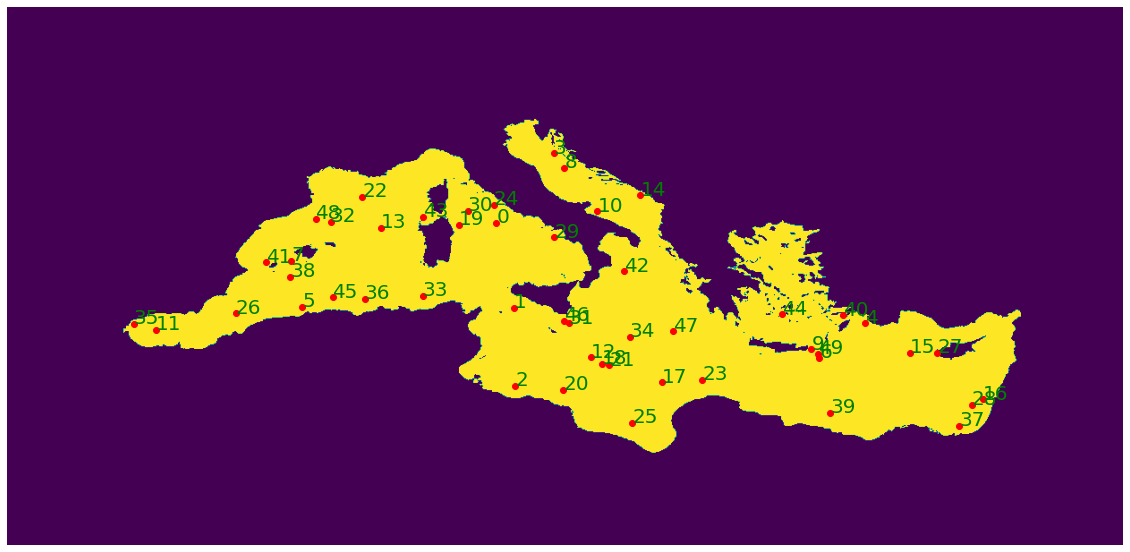

In [ ]:
sampled_lat = [lat for lat,lon in sample_idx]
sampled_lon = [lon for lat,lon in sample_idx]

medi_only = np.where(water_map!=freq_table[1][0],0,1) # setting all other tiles to 0
# print(medi_only)

fig, ax = plt.subplots(figsize=(20,20))
# medi_only = np.where(medi_only==1,medi_only)
arr_temp = ((255 - medi_only) / medi_only.max() * 255).astype(np.uint8) # change to blue
print(arr_temp)
# arr_temp = np.where(arr_temp==1,,arr_temp)
img_temp = Image.fromarray(arr_temp)
ax.imshow(img_temp)
ax.scatter(x=sampled_lon,y=sampled_lat,c="r")

for i in range(len(sample_idx)):
    ax.annotate(i, (sampled_lon[i], sampled_lat[i]),fontsize=20,c="green")

# ax.scatter(580,131,c="b")
plt.axis('off')
plt.show()

In [ ]:
second_sampled_point = sample_idx[2]
print(second_sampled_point)
print(f"Distance to coastline: {medi_dist_to_coastline[second_sampled_point]}")

(423, 567)
Distance to coastline: 0.5803470238126682


In [ ]:
first_sampled_point = sample_idx[1]
print(first_sampled_point)
print(f"Distance to coastline: {medi_dist_to_coastline[first_sampled_point]}")

(336, 566)
Distance to coastline: 0.6066757367808724


In [ ]:
dist_arr = []
for i in range(50):
  temp_id = sample_idx[i]
  dist_arr.append(medi_dist_to_coastline[temp_id])
dist_arr = np.array(dist_arr)

In [ ]:
np.argmax(dist_arr)

34

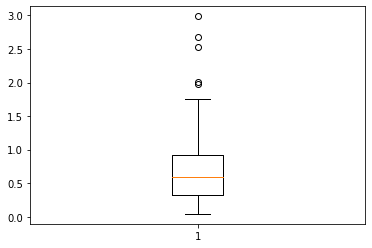

In [ ]:
plt.boxplot(dist_arr)
plt.show()

In [ ]:
# from numpy import unravel_index
# unravel_index(medi_dist_to_coastline.argmax(), medi_dist_to_coastline.shape)

# Diagnostic Plots

TODO:
- Diagnotic plot for all locations? Test for stationarity
- Proportion of locations with not enough information (Close to white noise)
- Create a map for the above point

https://stats.stackexchange.com/questions/219747/what-selection-criteria-to-use-and-why-aic-rmse-mape-all-possible-model-s

This link suggest that we use AIC instead of RMSE to tune hyper-parameter, over BIC as well. Reason: RMSE does not penalise model complexity and is not robust when sample size is large. (Maybe since our sample size is small, this is okay?). On the other hand, BIC penalises more than AIC, but for small sample BIC might be "...underselecting in finite samples, which is why AIC is often preferred in applications."

In [ ]:
first_ts = medi_zsd[:,241,546]
ts_df = pd.DataFrame(first_ts)
# ts_df = ts_df.T
ts_df.columns = ["ZSD_0"]
for i in range(7):
  ts_df[f"ZSD_{i+1}"] = ts_df[f"ZSD_{i}"].shift(1)
print(ts_df)
ts_df["7diff"] = ts_df["ZSD_0"] - ts_df["ZSD_7"]
ts_df.dropna(axis=0,how="any",inplace=True)
# first_ts_d = difference(first_ts)

         ZSD_0      ZSD_1      ZSD_2      ZSD_3      ZSD_4      ZSD_5  \
0    33.779602        NaN        NaN        NaN        NaN        NaN   
1    32.447594  33.779602        NaN        NaN        NaN        NaN   
2    32.367001  32.447594  33.779602        NaN        NaN        NaN   
3    33.263561  32.367001  32.447594  33.779602        NaN        NaN   
4    32.582745  33.263561  32.367001  32.447594  33.779602        NaN   
..         ...        ...        ...        ...        ...        ...   
245  24.191959  20.233311  21.763739  21.394117  22.555386  29.291592   
246  24.390610  24.191959  20.233311  21.763739  21.394117  22.555386   
247  21.533567  24.390610  24.191959  20.233311  21.763739  21.394117   
248  21.625978  21.533567  24.390610  24.191959  20.233311  21.763739   
249  20.933865  21.625978  21.533567  24.390610  24.191959  20.233311   

         ZSD_6      ZSD_7  
0          NaN        NaN  
1          NaN        NaN  
2          NaN        NaN  
3          

In [ ]:
print(ts_df["7diff"])

7     -6.741653
8     -2.650928
9     -1.395798
10     0.185925
11     0.866741
         ...   
245    3.337574
246    0.978683
247   -7.758024
248   -0.929407
249   -0.460253
Name: 7diff, Length: 243, dtype: float64


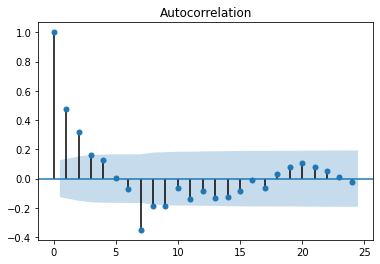

In [ ]:
plot_acf(ts_df["7diff"])
plt.show()

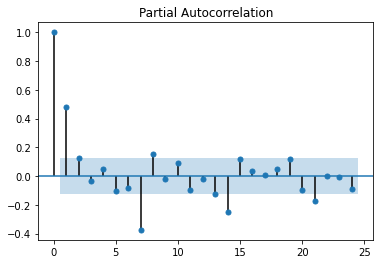

In [ ]:
plot_pacf(ts_df["7diff"])
plt.show()

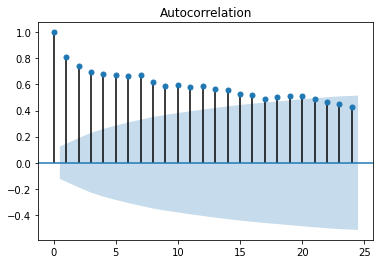

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(first_ts)
plt.show()
# plt.savefig("ACF_plot.pdf", bbox_inches="tight")

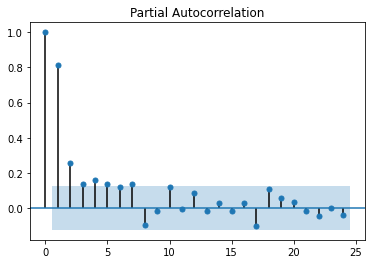

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(first_ts)
plt.show()
# plt.savefig("PACF_plot.pdf", bbox_inches="tight")

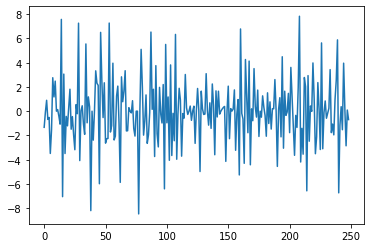

In [ ]:
diff_first_ts = difference(first_ts)
plt.plot(diff_first_ts)
plt.show()

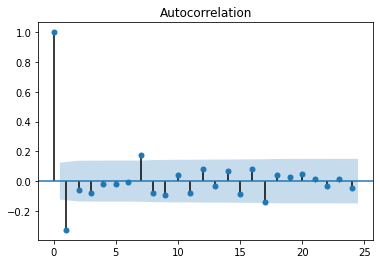

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diff_first_ts)
plt.show()
# plt.savefig("ACF_plot.pdf", bbox_inches="tight")

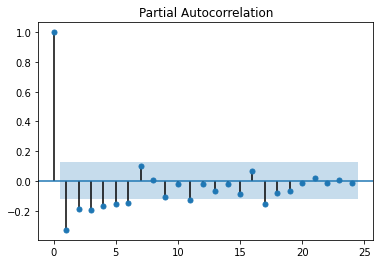

In [ ]:
# from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff_first_ts)
plt.show()
# plt.savefig("PACF_plot.pdf", bbox_inches="tight")

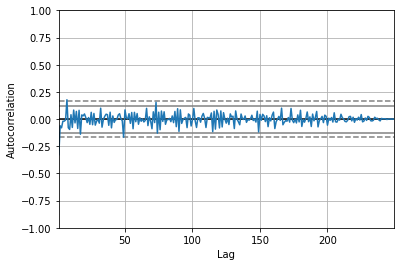

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff_first_ts)
plt.show()

Stationarity is a stronger test than this constant variance test

In [ ]:
from scipy.stats import bartlett

Since taking first order differencing makes the times series stationary, we will be modelling the differenced time series instead of the initial time series.

In [ ]:
a , b , c = diff_first_ts[:len(diff_first_ts)//3], diff_first_ts[len(diff_first_ts)//3:2*len(diff_first_ts)//3], diff_first_ts[2*len(diff_first_ts)//3:]
bartlett(a , b , c)

BartlettResult(statistic=2.6840137007782334, pvalue=0.2613207104308672)

In [ ]:
[np.var(x, ddof=1) for x in [a, b, c]]

[9.244960735066439, 6.656449842013114, 6.940988594019036]

In [ ]:
len(a),len(b),len(c)

(83, 83, 83)

# Modeling

Metrics:
- MSE
- mMSE (Check whether this gives the MSE)
- Might be better to use MAE and mMAE, which guarantee the same unit.

For Baseline (Average of past data), get the p VS MSE + distance VS MSE. Build the data pipeline first with the baseline.

In [ ]:
# models_metrics_collection = {}

## One Time series

For now we work with 240 training and 10 testing (a.k.a last 10 days will be the final predictions)
sampled_zsd.shape
sample_idx[0]
sampled_zsd.shape
medi_zsd.shape
plt.plot(first_ts)
plt.show()
# from cycler import cycler 
# from matplotlib import rcParams 
# rcParams["axes.prop_cycle"] = cycler(color=plt.get_cmap("tab10").colors) 
# rcParams["lines.linewidth"] = 3 
# rcParams["axes.grid"] = True 
# rcParams["legend.fontsize"] = 16 
# rcParams["xtick.labelsize"] = 12 
# rcParams["ytick.labelsize"] = 12 
# rcParams["axes.labelsize"] = 16 
# rcParams["axes.titlesize"] = 16 
# rcParams["axes.edgecolor"] = "0.8" 
# rcParams["figure.figsize"] = 4, 3
plt.figure(figsize=(20,12))
plt.plot(first_ts)
plt.xlabel('Time (days)')
plt.ylabel('ZSD (m)')
# plt.savefig("First Time Series.pdf", bbox_inches="tight")
plt.show()
plt.plot(first_ts_d)
plt.show()
### Baseline

Taking the average of the previous data to predict the next value.

TODO:
- Use predicted value as history
- Or update other model to have the ground truth as the history
- Use predicted value as history -> X_t+1 hat t pred X_t+2
- Use the ground truth -> X_t+1 pred X_t+2
first_ts.shape, first_ts_d.shape
window_size = 3 # Window contains both the predictor and response (# of response = window_size-num_resp)
num_resp = 1
tick=0
print("        Predictor         |   Response")
for i in range(0,len(first_ts)-window_size+1,1): # step size can be changed
  temp_window = first_ts[i:i+window_size]
  num_pred = window_size-num_resp
  predictor = temp_window[:num_pred]
  response = temp_window[-num_resp:]
  print(predictor,response)
  tick+=1
  if tick>10:
    break
window_size = 3 # Window contains both the predictor and response (# of response = window_size-num_resp)
num_resp = 1
baseline_predictions = [first_ts[0],first_ts[1]]
for i in range(0,len(first_ts)-window_size+1,1): # step size can be changed
  temp_window = first_ts[i:i+window_size]
  num_pred = window_size-num_resp # 2
  predictor = temp_window[:num_pred]
  response = temp_window[-num_resp:]
  baseline_predictions.append(predictor.mean())
baseline_predictions = np.array(baseline_predictions)

train_RMSE_baseline = sqrt(np.square(np.subtract(first_ts[:-10],baseline_predictions[:-10])).mean())
test_RMSE_baseline = sqrt(np.square(np.subtract(first_ts[-10:],baseline_predictions[-10:])).mean())
models_metrics_collection["baseline"] = test_RMSE_baseline
baseline_predictions = baseline_predictions[-10:]
### Persistence Model

Take the previous value as the prediction always
pers_predictions = [first_ts[0]]
for i in range(1,len(first_ts),1): # step size can be changed
  predictor = first_ts[i-1]
  pers_predictions.append(predictor)
pers_predictions = np.array(pers_predictions)

train_RMSE_pers = sqrt(np.square(np.subtract(first_ts[:-10],pers_predictions[:-10])).mean())
test_RMSE_pers = sqrt(np.square(np.subtract(first_ts[-10:],pers_predictions[-10:])).mean())
models_metrics_collection["pers"] = test_RMSE_pers
pers_predictions = pers_predictions[-10:]
### General Baseline Model

Take the p historical average
def Baseline(ts,num_resp,p):
  window_size = num_resp+p
  baseline_prediction = []
  #fill in initial ground truth
  for i in range(p):
    baseline_prediction.append(ts[i])
  #rolling pred
  for i in range(0,len(ts)-window_size+1,1):
    temp_window = ts[i:i+window_size]
    predictor = temp_window[:p]
    resposne = temp_window[-p:]
    baseline_prediction.append(predictor.mean())
  baseline_predictions = np.array(baseline_prediction)

  train_RMSE = sqrt(np.square(np.subtract(ts[:-10],baseline_predictions[:-10])).mean())
  test_RMSE = sqrt(np.square(np.subtract(ts[-10:],baseline_predictions[-10:])).mean())

  baseline_predictions = baseline_predictions[-10:]

  return baseline_predictions, train_RMSE, test_RMSE
#### testing baseline 
pred, _, test_RMSE_shishi = Baseline(first_ts,1,1)
test_RMSE_shishi
plt.figure(figsize=(15,8))
baseline_to_try = [1,2,3,4,5]
pred_all = []
RMSE_baseline_all = []
plt.plot(first_ts[-10:],label="Ground Truth",linewidth=4)
for p in baseline_to_try:
  pred, _, test_RMSE_shishi = Baseline(first_ts,1,p)
  plt.plot(pred,label=f"Baseline({p}), RMSE:{test_RMSE_shishi:.3f}")
plt.ylabel("ZSD",fontsize=20)
plt.xlabel("Time",fontsize=20)
plt.legend(prop={'size': 20})
# plt.title("Baseline(p) V.S. Ground Truth",fontsize=25)
# plt.savefig("Baseline_pred.pdf", bbox_inches="tight")
plt.show()
plt.figure(figsize=(10,5))
for p in range(1,10):
  pred, _, test_RMSE_temp = Baseline(first_ts,1,p)
  plt.scatter(p,test_RMSE_temp)
plt.title("Baseline(p) VS RMSE",fontsize=20)
plt.show()
### White Noise

TODO:
- Get empirical mean and SD, and fit it to Gaussian distribution.
import random
random.seed(201805673)
rr = np.random.random(249)-0.5

WN_predictions = [first_ts[0]]
for i in range(1,len(first_ts),1): # step size can be changed
  predictor = first_ts[i-1] + rr[i-1]
  WN_predictions.append(predictor)
WN_predictions = np.array(WN_predictions)

train_RMSE_wn = sqrt(np.square(np.subtract(first_ts[:-10],WN_predictions[:-10])).mean())
test_RMSE_wn = sqrt(np.square(np.subtract(first_ts[-10:],WN_predictions[-10:])).mean())
models_metrics_collection["WN"] = test_RMSE_wn

WN_predictions = WN_predictions[-10:]
print(test_RMSE_wn)
plt.figure(figsize=(10,5))
plt.plot(WN_predictions)
plt.plot(first_ts[-10:])
plt.show()
### Random Walk

TODO:
- Walk for test sample size
series_rw = pd.Series(rr)
cum_series = series_rw.cumsum()
plt.plot(cum_series)
plt.show()
RW_predictions = [first_ts[-10]]
for i in range(1,10,1): # step size can be changed
  predictor = RW_predictions[i-1] + cum_series[i-1]
  RW_predictions.append(predictor)
RW_predictions = np.array(RW_predictions)

test_RMSE_RW = sqrt(np.square(np.subtract(first_ts[-10:],RW_predictions[-10:])).mean())
models_metrics_collection["RW"] = test_RMSE_RW
# rr_test = np.random.random(10)-0.5
# # rr[rr > 0.5] = 1
# # rr[rr != 1] = -1

# series_rw_test = pd.Series(rr_test)
# cum_series_test = series_rw_test.cumsum()

# plt.plot(cum_series_test)
# plt.show()
print(test_RMSE_RW)
plt.figure(figsize=(10,5))
plt.plot(RW_predictions)
plt.plot(first_ts[-10:])
plt.show()
RW_predictions = RW_predictions[-10:]
### AutoRegressive Model
Rolling Prediction
# # create and evaluate a static autoregressive model


# # load dataset
# series = first_ts
# # split dataset
# X = series
# train, test = X[1:len(X)-10], X[len(X)-10:]
# # train autoregression
# model = AutoReg(train, lags=1)
# model_fit = model.fit()
# print('Coefficients: %s' % model_fit.params)
# # make predictions
# ar_predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) # This gives len(test) amount of predicitons
# for i in range(len(ar_predictions)):
# 	print('predicted=%f, expected=%f' % (ar_predictions[i], test[i]))
# ar_rmse = sqrt(mean_squared_error(test, ar_predictions))
# # models_metrics_collection["ar"] = ar_rmse
# print('Test RMSE: %.3f' % ar_rmse)
# # plot results
# plt.plot(test)
# plt.plot(ar_predictions, color='red')
# plt.show()
Manual Prediction with the ground truth
# load dataset
series = first_ts
# split dataset
X = difference(series)
# X = series
train, test = X[1:len(X)-10], X[len(X)-10:]
# train autoregression
window = 1
model = AutoReg(train, lags=1)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = [train[-window]]
history = [history[i] for i in range(len(history))]
ar_predictions = []
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	ar_predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
 
undiff_ar_predictions = np.array(inverse_diff(pd.Series(ar_predictions),series[-11]))

rmse = sqrt(mean_squared_error(series[-10:], undiff_ar_predictions))
models_metrics_collection["ar"] = rmse

plt.plot(series[-10:])
# plt.plot(undiff_test)
plt.plot(undiff_ar_predictions, color='red')
print(rmse)
plt.show()
AR model is staionary if all its coefficient are strictly within the unit circle.
def ARstationary(coef):
  res = True
  for i in coef:
    if abs(i)>=1:
      res = False
  return res
ARstationary(coef)
coef
### ARIMA

TODO: Not refit the model, but use the fitted coefficient to predict
# # evaluate an ARIMA model using a walk-forward validation
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARMAResults 
# # split into train and test sets
# X = first_ts_d
# train, test = X[1:len(X)-10], X[len(X)-10:]
# history = [x for x in train]
# arima_predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=([1,2,3,4,5],0,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	arima_predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # convert forecasts to initial time series
# undiff_ar_predictions = np.array(inverse_diff(pd.Series(arima_predictions),series[-11]))
# # evaluate forecasts
# arima_rmse = sqrt(mean_squared_error(series[-10:], undiff_ar_predictions))
# models_metrics_collection["arima"] = arima_rmse
# print('Test RMSE: %.3f' % arima_rmse)
# # plot forecasts against actual outcomes
# plt.plot(first_ts[-10:])
# plt.plot(undiff_ar_predictions, color='red')
# plt.show()
# from mpl_toolkits import mplot3d
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import math

# x = [i for i in range(0, 200, 100)]
# y = [i for i in range(0, 200, 100)]

# X, Y = np.meshgrid(x, y)
# Z = []
# for i in x:
# 	t = []
# 	for j in y:
# 		t.append(math.tan(math.sqrt(i*2+j*2)))
# 	Z.append(t)

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap=cm.cool)
# ax.set_xlabel('a')
# ax.set_ylabel('b')
# ax.set_zlabel('c')
# ax.set_title('3D contour for tan')
# plt.show()
#### Fine Tune through Grid Search

Since ACF and PACF display some evidence on AR(1) process, I "seed" the grid near this.

TODO:
- Change RMSE with BIC/AIC to tune hyperparameter (e.g. BIC gives p=3, AIC gives p=5, let baseline have p=5; or use both)
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model_rmse(X, arima_order):
	# prepare training dataset
	# train_size = int(len(X) * 0.66)
	series = X
	X = difference(X)
	train, test = X[:-10], X[-10:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# inverse diff
	undiff_predictions = np.array(inverse_diff(pd.Series(predictions),series[-11]))
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(series[-10:], undiff_predictions))
	return rmse

def evaluate_arima_model_ic(X, arima_order,metrics):
	# prepare training dataset
	# train_size = int(len(X) * 0.66)
	series = X
	X = difference(X)
	train, test = X[:-10], X[-10:]
	history = [x for x in train]
	model = ARIMA(history, order=arima_order)
	model_fit = model.fit()
	aic = model_fit.aic
	bic = model_fit.bic
	return aic if metrics=="aic" else bic
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, metrics):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					metric = evaluate_arima_model_ic(dataset, order,metrics)
					if metric < best_score:
						best_score, best_cfg = metric, order
					print(f'ARIMA%s {metrics}=%.3f' % (order,metric))
				except:
					continue
	print(f'Best ARIMA%s {metrics}=%.3f' % (best_cfg, best_score))
	return best_cfg
 
# evaluate parameters
# p_values = range(5)
# d_values = [0]
# q_values = range(5)
# warnings.filterwarnings("ignore")
# best_cfg_bic = evaluate_models(series, p_values, d_values, q_values,"bic")
# from mpl_toolkits import mplot3d
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import math

# x = [i for i in range(0, 200, 100)]
# y = [i for i in range(0, 200, 100)]

# X, Y = np.meshgrid(x, y)
# Z = []
# for i in x:
# 	t = []
# 	for j in y:
# 		t.append(math.tan(math.sqrt(i*2+j*2)))
# 	Z.append(t)

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap=cm.cool)
# ax.set_xlabel('a')
# ax.set_ylabel('b')
# ax.set_zlabel('c')
# ax.set_title('3D contour for tan')
# plt.show()
TODO:
- Figure out why ARIMA and AutoReg gives different AIC and BIC even if ARIMA(p,0,0). (See meeting note)
warnings.filterwarnings("ignore")
from tqdm import tqdm
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
bic = []
p_list = [i for i in range(10)]
q_list = [i for i in range(10)]
P,Q=np.meshgrid(p_list,q_list)
for i in tqdm(p_list):
  temp_metric = []
  for j in q_list:
    metric = evaluate_arima_model_ic(first_ts, (i,0,j),"bic")
    temp_metric.append(metric)
  bic.append(temp_metric)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contour3D(P, Q, bic, 50, cmap=cm.cool)
ax.set_xlabel('P')
ax.set_ylabel('Q')
ax.set_zlabel('BIC')
ax.set_title('Contour plot for BIC')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(bic[1])
plt.show()
res = float("inf")
opt_p_bic = 0
opt_q_bic = 0
for i in range(len(bic)):
  for j in range(len(bic[0])):
    if bic[i][j] < res:
      res = bic[i][j]
      opt_p_bic = i
      opt_q_bic = j
print(opt_p_bic,opt_q_bic)
warnings.filterwarnings("ignore")
from tqdm import tqdm
aic = []
p_list = [i for i in range(10)]
q_list = [i for i in range(10)]
P,Q=np.meshgrid(p_list,q_list)
for i in tqdm(p_list):
  temp_metric = []
  for j in q_list:
    metric = evaluate_arima_model_ic(first_ts, (i,0,j),"aic")
    temp_metric.append(metric)
  aic.append(temp_metric)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contour3D(P, Q, aic, 25, cmap=cm.cool)
ax.set_xlabel('P')
ax.set_ylabel('Q')
ax.set_zlabel('AIC')
ax.set_title('Contour plot for AIC')
plt.show()
res = float("inf")
opt_p_aic = 0
opt_q_aic = 0
for i in range(len(aic)):
  for j in range(len(aic[0])):
    if aic[i][j] < res:
      res = aic[i][j]
      opt_p_aic = i
      opt_q_aic = j
print(opt_p_aic,opt_q_aic)
aic_arr = np.array(aic)
plt.plot(aic_arr[1,:])
plt.show()
TODO: 
- AIC/BIC for AutoReg and ARIMA differs... use ARIMA instead to make it more reusable. In the report talk briefly about the two possible implementations, and a little bit of rationale why we chose ARIMA over AutoReg (able to choose more parsimonious model by allowing the penalty term to "come into play")
Under BIC, the best ARIMA model is a random walk (ARIMA(0,0,0)); AIC, the best mdoel is ARIMA(1,0,1). Refit model using both

TODO:
- Visualisise the change in AIC/BIC wrt p (AR) and q (MA).
warnings.filterwarnings("ignore")
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
# split into train and test sets
X = first_ts_d
train, test = X[1:len(X)-10], X[len(X)-10:]
history = [x for x in train]
arima_aic_predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(opt_p_aic,0,opt_q_aic))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	arima_aic_predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
 
 # convert forecasts to initial time series
undiff_arima_aic_predictions = np.array(inverse_diff(pd.Series(arima_aic_predictions),first_ts[-11]))
# evaluate forecasts
arima_aic_rmse = sqrt(mean_squared_error(first_ts[-10:], undiff_arima_aic_predictions))
# evaluate forecasts
models_metrics_collection["arima_aic"] = arima_aic_rmse
print('Test RMSE: %.3f' % arima_aic_rmse)
# plot forecasts against actual outcomes
plt.plot(first_ts[-10:])
plt.plot(undiff_arima_aic_predictions, color='red')
plt.show()
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
# split into train and test sets
X = first_ts_d
train, test = X[1:len(X)-10], X[len(X)-10:]
history = [x for x in train]
arima_bic_predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(opt_p_bic,0,opt_q_bic))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	arima_bic_predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# convert forecasts to initial time series
undiff_arima_bic_predictions = np.array(inverse_diff(pd.Series(arima_bic_predictions),first_ts[-11]))
# evaluate forecasts
arima_bic_rmse = sqrt(mean_squared_error(first_ts[-10:], undiff_arima_bic_predictions))
# evaluate forecasts
models_metrics_collection["arima_bic"] = arima_bic_rmse
print('Test RMSE: %.3f' % arima_bic_rmse)
# plot forecasts against actual outcomes
plt.plot(first_ts[-10:])
plt.plot(undiff_arima_bic_predictions, color='red')
plt.show()
TODO:
- Use the best config in baseline as well to be comparable
### Grouping All Prediction
sorted_models_metrics_collection = sorted(models_metrics_collection.items(), key=lambda item: item[1],reverse=True)
TODO:
- Fix this plot
sorted_models_metrics_collection
plt.figure(figsize=(15,8))
for model_name, model_rmse in sorted_models_metrics_collection:
  if model_name == "arima_aic":
    plt.plot(eval(f"undiff_{model_name}_predictions"),label=f"{model_name}({opt_p_aic},0,{opt_q_aic}), RMSE:{model_rmse:.3f}")
  elif model_name == "arima_bic":
    plt.plot(eval(f"undiff_{model_name}_predictions"),label=f"{model_name}({opt_p_bic},0,{opt_q_bic}), RMSE:{model_rmse:.3f}")
  elif model_name == "ar":
    plt.plot(eval(f"undiff_{model_name}_predictions"),label=f"{model_name}, RMSE:{model_rmse:.3f}")
  else:
    plt.plot(eval(f"{model_name}_predictions"),label=f"{model_name}, RMSE:{model_rmse:.3f}")
plt.plot(first_ts[-10:],label="Ground Truth",linewidth=4)
plt.ylabel("ZSD",fontsize=20)
plt.xlabel("Time",fontsize=20)
plt.legend(prop={'size': 20})
# plt.savefig("other_model_eval.pdf", bbox_inches="tight")
plt.show()
Despite the utter defeat of the baseline models over the other models. To more robustly test this, we aggregate all 50 locations.
TODO:
- To have different plots for AIC/BIC
- Fine tune ARIMA, then use best config in other model
- Seperate model for each location
- Distance to coastline, 
- Clustering of Time series, then fit different models to that region (See below)
- One model for all

Similarity between TS:
- Dynamic Time Warping Time series
- Time Series Kernel 
### Creating a Master Function to model

For the next section, we will be repeating the procedure to many locations/neighbours, we will group our functions together into a more compiled ones.
warnings.filterwarnings("ignore")
def evaluate_arima_model_ic(X, arima_order,metrics):
  # train_size = int(len(X) * 0.66)
  history = [x for x in X]
  # make predictions
  predictions = list()
  model = ARIMA(history, order=arima_order)
  model_fit = model.fit()
  bic = model_fit.bic
  aic = model_fit.aic
  return aic if metrics=="aic" else bic

def evaluate_models(dataset, p_values, d_values, q_values, metrics):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					metric = evaluate_arima_model_ic(dataset, order,metrics)
					if metric < best_score:
						best_score, best_cfg = metric, order
					# print(f'ARIMA%s {metrics}=%.3f' % (order,metric))
				except:
					continue
	# print(f'Best ARIMA%s {metrics}=%.3f' % (best_cfg, best_score))
	return best_cfg

def arima_model(ts,metrics):
  # ts_d = difference(ts)
  # train test split
  train, test = ts[:len(ts)-10], ts[len(ts)-10:]
  # grid search for p,q
  p_values = range(6)
  d_values = [1] # use the best value found by Deelan
  q_values = range(6)
  best_cfg = evaluate_models(train, p_values, d_values, q_values,metrics)
  
  history = [x for x in train]
  arima_predictions = list()
  # walk-forward validation
  for t in range(len(test)):
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)
  # evaluate forecasts
  # undiff_arima_bic_predictions = np.array(inverse_diff(pd.Series(arima_predictions),ts[-11]))
  # evaluate forecasts
  arima_rmse = sqrt(mean_squared_error(ts[-10:], arima_predictions))
  return best_cfg , arima_rmse

## All Location

Re-peat the process for other locations, and gather the RMSE for each model and the corresponding Baseline model. E.g. after hyper-parameter tuning, it is realised that ARIMA(p,1,q) is the best configuration for ARIMA model. Hence we will use Baseline(max(p,q)) for comparison

TODO: Increase N=50, and observe the points that gives RW or an outlier RMSE

In [ ]:
sampled_distance = []
for i in range(50):
  sampled_distance.append(medi_dist_to_coastline[sample_idx[i][0],sample_idx[i][1]])
sampled_distance = np.array(sampled_distance)

In [ ]:
sampled_distance

array([0.95105854, 0.60667574, 0.58034702, 0.32542626, 0.24295687,
       0.30046252, 0.70955646, 0.41036911, 0.44876503, 0.17179483,
       0.21245777, 0.75115651, 2.0004325 , 1.75445861, 0.20833435,
       1.29770222, 0.5017329 , 1.43372228, 2.52522021, 0.33592559,
       0.75      , 2.68127667, 0.97539291, 0.79056942, 0.35843162,
       0.79056942, 0.83333206, 0.04166412, 0.96195014, 0.34359106,
       0.95105808, 0.41874602, 0.95833206, 0.63737744, 2.98753253,
       0.18634042, 0.58925441, 0.34359059, 0.79056953, 0.74535486,
       0.05892601, 0.23570052, 0.65218422, 0.13176167, 0.04166794,
       0.58333206, 0.31732505, 1.97554552, 0.71685945, 0.5153882 ])

In [ ]:
# def Autoregressive_rmse(train, test, p_values, d_values, q_values):
#   # prepare training dataset
#   history = [x for x in train]
#   # make predictions
#   predictions = list()
#   for t in range(len(test)):
#     model = ARIMA(history, order=(p_values, d_values, q_values))
#     model_fit = model.fit()
#     yhat = model_fit.forecast()[0]
#     predictions.append(yhat)
#     history.append(test[t])
#   # calculate out of sample error
#   rmse = sqrt(mean_squared_error(test, predictions))
#   return rmse

# # load dataset
# RMSE_AR_3 = []
# for k in range(0,50):
#   series = medi_zsd[:,sample_idx[k][0],sample_idx[k][1]]
#   X = series
#   train, test = X[1:len(X)-10], X[len(X)-10:]
#   # evaluate parameters
#   p_values = 3
#   d_values = 1
#   q_values = 0
#   warnings.filterwarnings("ignore")
#   best_cfg_AR = Autoregressive_rmse(train, test, p_values, d_values, q_values)
#   RMSE_AR_3.append(best_cfg_AR)

### Baseline(p)

In [ ]:
def Baseline(ts,num_resp,p):
  start = time.time()
  window_size = num_resp+p
  relevant_ts = ts[-(10+p):]
  baseline_prediction = []
  #rolling pred

  for i in range(0,len(relevant_ts)-window_size+1,1):
    temp_window = relevant_ts[i:i+window_size]
    predictor = temp_window[:p]
    baseline_prediction.append(predictor.mean())
  baseline_predictions = np.array(baseline_prediction)
  end = time.time()
  test_RMSE = measure_rmse(ts[-10:],baseline_predictions)
  runtime = end - start
  return test_RMSE, runtime

In [ ]:
sampled_zsd.shape

(50, 250, 3, 3)

In [ ]:
collect_rmse_baseline = []
collect_runtime_baseline = []
for i in range(1,6):
  rmse_collection = []
  runtime_collection = []
  for locat in range(50):
    temp_ts = sampled_zsd[locat,:,1,1]
    temp_rmse, runtime = Baseline(temp_ts,1,i)
    rmse_collection.append(temp_rmse)
    runtime_collection.append(runtime)
  collect_rmse_baseline.append(rmse_collection)
  collect_runtime_baseline.append(runtime_collection)

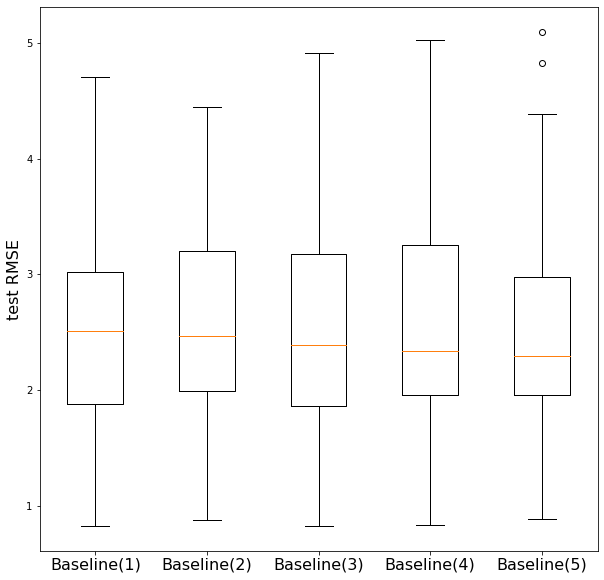

In [ ]:
rmse_baseline = {}
for ix, i in enumerate(collect_rmse_baseline):
  rmse_baseline[f"Baseline({ix+1})"] = i
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(rmse_baseline.values())
ax.set_xticklabels(rmse_baseline.keys(),fontsize=16)
ax.set_ylabel('test RMSE',fontsize=16)
# plt.savefig("All Baseline.jpg")
plt.show()

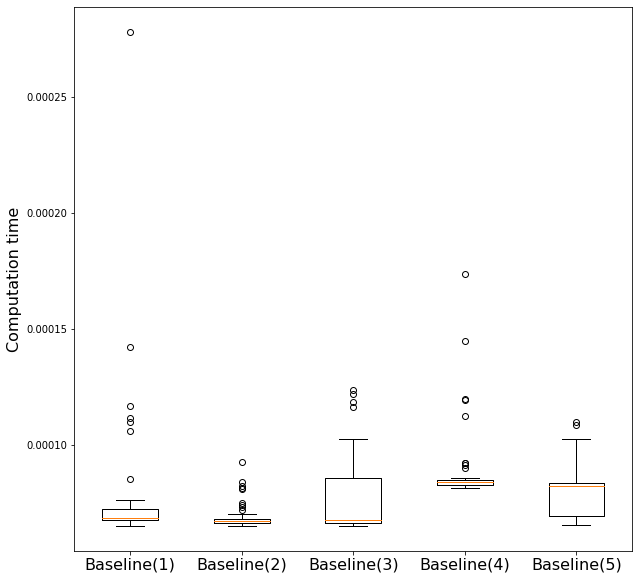

In [ ]:
runtime_baseline = {}
for ix, i in enumerate(collect_runtime_baseline):
  runtime_baseline[f"Baseline({ix+1})"] = i
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(runtime_baseline.values())
ax.set_xticklabels(runtime_baseline.keys(),fontsize=16)
ax.set_ylabel('Computation time',fontsize=16)
# plt.savefig("All Baseline Runtime.jpg")
plt.show()

### Baseline with Differencing(p)

In [ ]:
def Baseline(ts,num_resp,p):
  start = time.time()
  diff = difference(ts)
  window_size = num_resp+p
  relevant_ts = diff[-(10+p):]
  baseline_prediction = []
  #rolling pred
  for i in range(0,len(relevant_ts)-window_size+1,1):
    temp_window = relevant_ts[i:i+window_size]
    predictor = temp_window[:p]
    baseline_prediction.append(predictor.mean())
  baseline_predictions = np.array(baseline_prediction)
  baseline_predictions = inverse_diff(baseline_predictions,ts[-11])
  end = time.time()
  test_RMSE = measure_rmse(ts[-10:],baseline_predictions[-10:])
  runtime = end - start
  return test_RMSE, runtime

In [ ]:
# ts = sampled_zsd[0,:,1,1]

In [ ]:
# num_resp = 1
# p = 1
# diff = difference(ts)
# window_size = num_resp+p
# relevant_ts = diff[-(10+p):]
# baseline_prediction = []
# #rolling pred
# for i in range(0,len(relevant_ts)-window_size+1,1):
#   temp_window = relevant_ts[i:i+window_size]
#   predictor = temp_window[:p]
#   baseline_prediction.append(predictor.mean())
# baseline_predictions = np.array(baseline_prediction)
# baseline_predictions = inverse_diff(baseline_predictions,ts[-11])

In [ ]:
# ts[-11]

In [ ]:
# plt.plot(difference(ts)[-10:])
# plt.plot(baseline_prediction)
# plt.show()

In [ ]:
# plt.plot(ts[-10:])
# plt.plot(baseline_predictions)
# plt.show()

In [ ]:
collect_rmse_baseline_diff = []
collect_runtime_baseline_diff = []
for i in range(1,6):
  rmse_collection = []
  runtime_collection = []
  for locat in range(50):
    temp_ts = sampled_zsd[locat,:,1,1]
    temp_rmse, runtime = Baseline(temp_ts,1,i)
    rmse_collection.append(temp_rmse)
    runtime_collection.append(runtime)
  collect_rmse_baseline_diff.append(rmse_collection)
  collect_runtime_baseline_diff.append(runtime_collection)

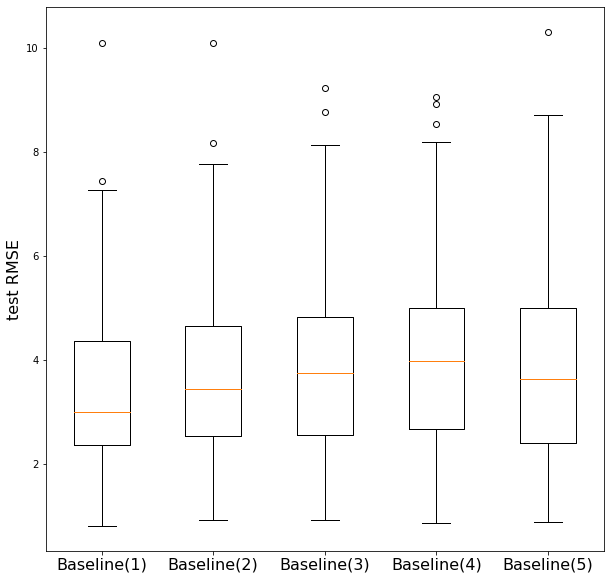

In [ ]:
rmse_baseline_diff  = {}
for ix, i in enumerate(collect_rmse_baseline_diff):
  rmse_baseline_diff[f"Baseline({ix+1})"] = i
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(rmse_baseline_diff.values())
ax.set_xticklabels(rmse_baseline_diff.keys(),fontsize=16)
ax.set_ylabel('test RMSE',fontsize=16)
# plt.savefig("All Baseline differenced.jpg")
plt.show()

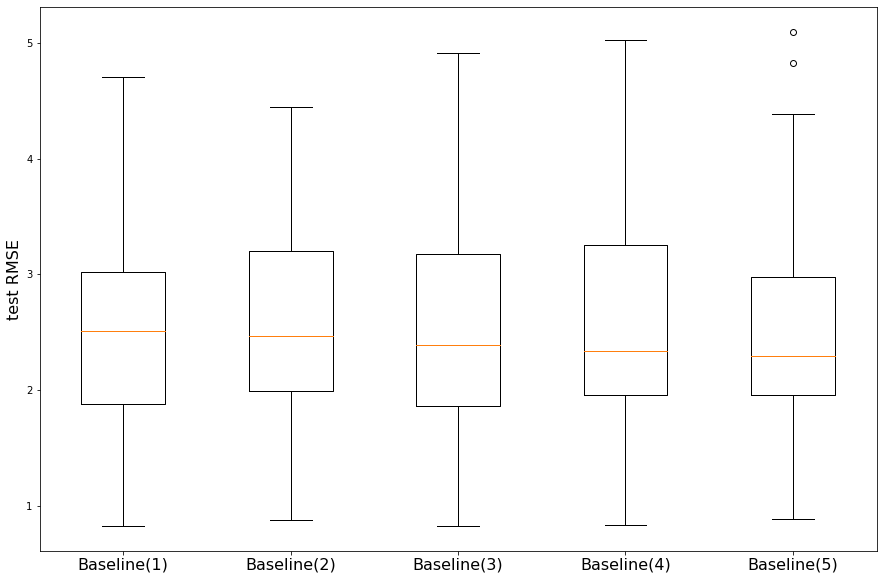

In [ ]:
# d4 = dict(d1.items() + d2.items() + d3.items())
new_dict = dict(rmse_baseline)
# rmse_baseline.update(rmse_baseline_diff)
# new_dict.update(rmse_baseline_diff)
fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(new_dict.values())
ax.set_xticklabels(new_dict.keys(),fontsize=16)
ax.set_ylabel('test RMSE',fontsize=16)
# plt.savefig("All Baseline differenced.jpg")
plt.show()

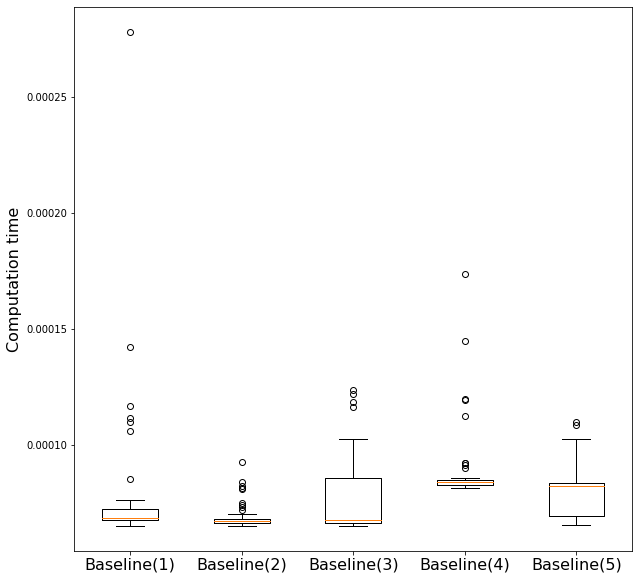

In [ ]:
runtime_baseline = {}
for ix, i in enumerate(collect_runtime_baseline):
  runtime_baseline[f"Baseline({ix+1})"] = i
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(runtime_baseline.values())
ax.set_xticklabels(runtime_baseline.keys(),fontsize=16)
ax.set_ylabel('Computation time',fontsize=16)
# plt.savefig("All Baseline Runtime.jpg")
plt.show()

### AR(p)

#### AR(p) AIC

In [ ]:
# warnings.filterwarnings("ignore")
# # Autoregressive model for all 50 points, lags from 1 - 30
# def Autoregressive_rmse(train, test, p_values, d_values, q_values):
#   # prepare training dataset
#   history = [x for x in train]
#   # make predictions
#   predictions = list()
#   for t in range(len(test)):
#     model = SARIMAX(history, order=(p_values, d_values, q_values))
#     model_fit = model.fit()
#     yhat = model_fit.forecast()[0]
#     predictions.append(yhat)
#     history.append(test[t])
#   # calculate out of sample error
#   rmse = sqrt(mean_squared_error(test, predictions))
#   return rmse, predictions


# # load dataset
# collect_rmse_ar_aic = []
# collect_prediction_ar_aic = []
# collect_runtime_ar_aic = []
# collect_bestcfg_ar_aic = []
# collect_coef_ar_aic = []
# for locat in range(0,50):
#   start = time.time()
#   x = ZSD_arr[locat,:]
#   train, test = x[:-10], x[-10:]
#   history = [x for x in train]

#   best_score, best_cfg, best_coef= float("inf"), None, None

#   # grid search p
#   for j in range(1,6):
#     # evaluate parameters
#     p_values = j
#     d_values = 1
#     q_values = 0
#     model = SARIMAX(history,order=(p_values,d_values,q_values))
#     model_fit = model.fit()
#     if model_fit.aic < best_score:
#       best_score = model_fit.aic
#       best_cfg = j
#       best_coef = model_fit.polynomial_ar
  
#   # Fit and Prediction
#   rmse, prediction = Autoregressive_rmse(train,test,best_cfg,1,0)
#   end = time.time()
#   collect_rmse_ar_aic.append(rmse)
#   collect_prediction_ar_aic.append(prediction)
#   collect_runtime_ar_aic.append(end-start)
#   collect_bestcfg_ar_aic.append(best_cfg)
#   collect_coef_ar_aic.append(best_coef)

In [ ]:
# plt.boxplot(collect_rmse_ar_aic)
# plt.show()

In [ ]:
# plt.boxplot(collect_runtime_ar_aic)
# plt.show()

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/AR_aic_pred.txt', 'w') as fp:
#     for item in collect_prediction_ar_aic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/AR_aic_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_ar_aic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/AR_aic_runtime.txt', 'w') as fp:
#     for item in collect_runtime_ar_aic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/AR_aic_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_ar_aic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/AR_aic_coef.txt', 'w') as fp:
#     for item in collect_coef_ar_aic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

In [ ]:
collect_rmse_ar_aic = np.loadtxt('./Results/Model Output/AR_aic_RMSE.txt')
collect_runtime_ar_aic = np.loadtxt('./Results/Model Output/AR_aic_runtime.txt')
collect_bestcfg_ar_aic = np.loadtxt("./Results/Model Output/AR_aic_cfg.txt")

In [ ]:
collect_prediction_ar_aic = []
with open('./Results/Model Output/AR_aic_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(float(num))
        collect_prediction_ar_aic.append(row)
collect_prediction_ar_aic = np.array(collect_prediction_ar_aic)

In [ ]:
# # ar_coef_df = pd.DataFrame([0]*6).T

# temp = []
# for i in collect_coef_ar_aic:
  
#   arr = np.zeros((5), dtype = float)
#   arr[:len(i)-1] = i[1:]
#   # print(arr)
#   temp.append(arr)

# ar_coef_df_aic =  pd.DataFrame(temp)
# ar_coef_df_aic.columns = ["coef1","coef2","coef3","coef4","coef5"]

In [ ]:
# ar_coef_df_aic.apply(abs).mean(axis=0)

#### AR(p) BIC

In [ ]:
# warnings.filterwarnings("ignore")
# # Autoregressive model for all 50 points, lags from 1 - 30
# def Autoregressive_rmse(train, test, p_values, d_values, q_values):
#   # prepare training dataset
#   history = [x for x in train]
#   # make predictions
#   predictions = list()
#   for t in range(len(test)):
#     model = SARIMAX(history, order=(p_values, d_values, q_values))
#     model_fit = model.fit()
#     yhat = model_fit.forecast()[0]
#     predictions.append(yhat)
#     history.append(test[t])
#   # calculate out of sample error
#   rmse = sqrt(mean_squared_error(test, predictions))
#   return rmse, predictions


# # load dataset
# collect_rmse_ar_bic = []
# collect_prediction_ar_bic = []
# collect_runtime_ar_bic = []
# collect_bestcfg_ar_bic = []
# collect_coef_ar_bic = []
# for locat in range(0,50):
#   start = time.time()
#   x = ZSD_arr[locat,:]
#   train, test = x[:-10], x[-10:]
#   history = [x for x in train]

#   best_score, best_cfg, best_coef = float("inf"), None, None

#   # grid search p
#   for j in range(1,6):
#     # evaluate parameters
#     p_values = j
#     d_values = 0
#     q_values = 0
#     model = SARIMAX(history,order=(p_values,d_values,q_values))
#     model_fit = model.fit()
#     if model_fit.bic < best_score:
#       best_score = model_fit.bic
#       best_cfg = j
#       best_coef = model_fit.polynomial_ar
  
#   # Fit and Prediction
#   rmse, prediction = Autoregressive_rmse(train,test,best_cfg,1,0)
#   end = time.time()
#   collect_rmse_ar_bic.append(rmse)
#   collect_prediction_ar_bic.append(prediction)
#   collect_runtime_ar_bic.append(end-start)
#   collect_bestcfg_ar_bic.append(best_cfg)
#   collect_coef_ar_bic.append(best_coef)

In [ ]:
# plt.boxplot(collect_rmse_ar_bic)
# plt.show()

In [ ]:
# plt.boxplot(collect_runtime_ar_bic)
# plt.show()

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/AR_bic_pred.txt', 'w') as fp:
#     for item in collect_prediction_ar_bic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/AR_bic_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_ar_bic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/AR_bic_runtime.txt', 'w') as fp:
#     for item in collect_runtime_ar_bic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/AR_bic_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_ar_bic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/AR_bic_coef.txt', 'w') as fp:
#     for item in collect_coef_ar_bic:
#         # write each item on a new line
#         fp.write("%s\n" % item)

In [ ]:
collect_rmse_ar_bic = np.loadtxt('./Results/Model Output/AR_bic_RMSE.txt')
collect_runtime_ar_bic = np.loadtxt('./Results/Model Output/AR_bic_runtime.txt')
collect_bestcfg_ar_bic = np.loadtxt("./Results/Model Output/AR_bic_cfg.txt")

In [ ]:
# # ar_coef_df = pd.DataFrame([0]*6).T

# temp = []
# for i in collect_coef_ar_bic:
  
#   arr = np.zeros((5), dtype = float)
#   arr[:len(i)-1] = i[1:]
#   # print(arr)
#   temp.append(arr)

# ar_coef_df =  pd.DataFrame(temp)
# ar_coef_df.columns = ["coef1","coef2","coef3","coef4","coef5"]

In [ ]:
# ar_coef_df.mean(axis=0)

In [ ]:
collect_prediction_ar_bic = []
with open('./Results/Model Output/AR_bic_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(float(num))
        collect_prediction_ar_bic.append(row)
collect_prediction_ar_bic = np.array(collect_prediction_ar_bic)

In [ ]:
sum(collect_runtime_ar_bic)

63.41098690032959

In [ ]:
np.var(collect_rmse_ar_bic)

0.7654224994534942

#### Compare

In [ ]:
def diagnostic_plot(model_name,performance="rmse"):
  if performance not in ["rmse","runtime","bestcfg"]:
    print("Performance: rmse, runtime, bestcfg")
    return

  ylabel = ""
  if performance == "rmse":
    ylabel = "RMSE"
  elif performance == "runtime":
    ylabel = "Runtime"
  else:
    ylabel = "BestCfg"

  temp_dict = {}
  metrics = ["aic","bic"]
  for i in metrics:
    temp_dict[f"AR(p)[{i.upper()}]"] = eval(f"collect_{performance}_{model_name}_{i}")
  fig, ax = plt.subplots(figsize=(10,10))
  ax.boxplot(temp_dict.values())
  ax.set_xticklabels(temp_dict.keys(),fontsize=20)
  ax.set_ylabel(f'{ylabel}',fontsize=20)
  plt.show()

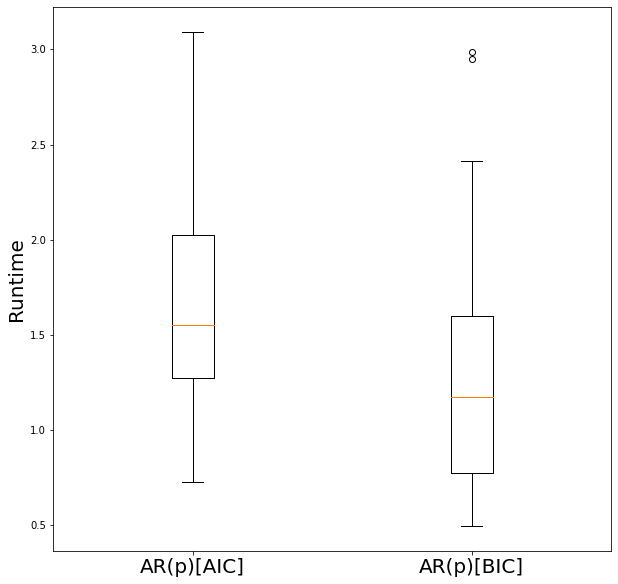

In [ ]:
diagnostic_plot(model_name="ar",performance="runtime")

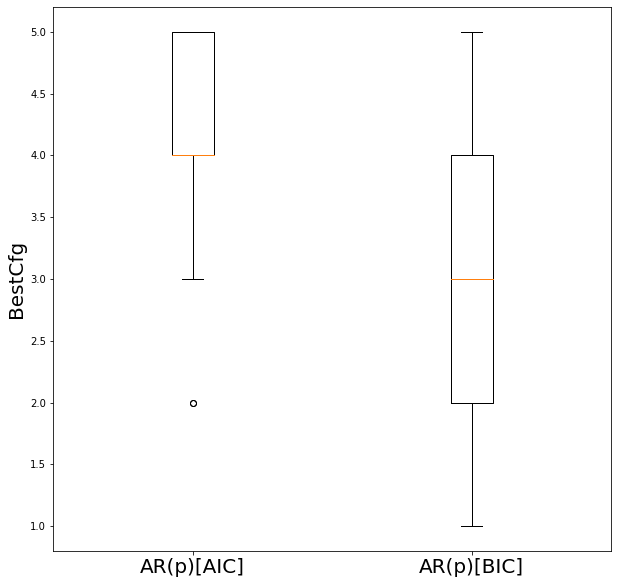

In [ ]:
diagnostic_plot(model_name="ar",performance="bestcfg")

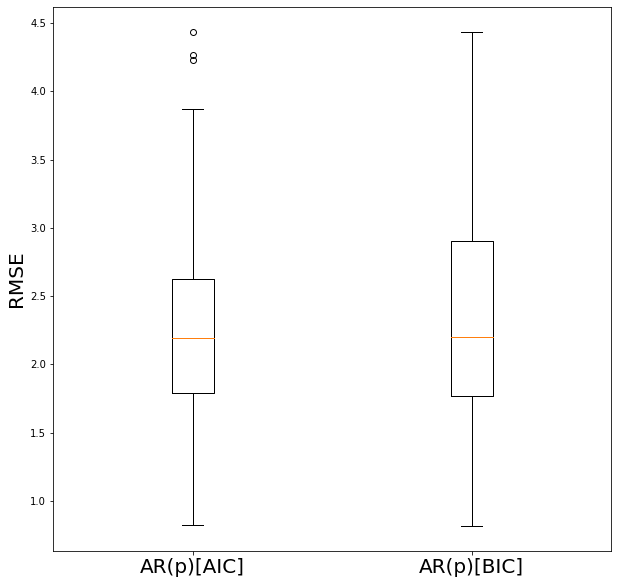

In [ ]:
diagnostic_plot(model_name="ar",performance="rmse")

Using BIC as the criteria for choosing the hyperparameter will result in more parsimonious models, as seen in the boxplot above. The boxplot on the right displays the optimal configuration of the AR model chosen by BIC, which clearly shows that lower p, a simpler model, is preferred for most locations.

As for the RMSE, which we care deeply about, the model chosen by the BIC gives high variance compared to AIC models, but with not too much difference in the bias. Moreover, using AIC produced some outliers, therefore hereafter we will be using BIC to finetune the models.

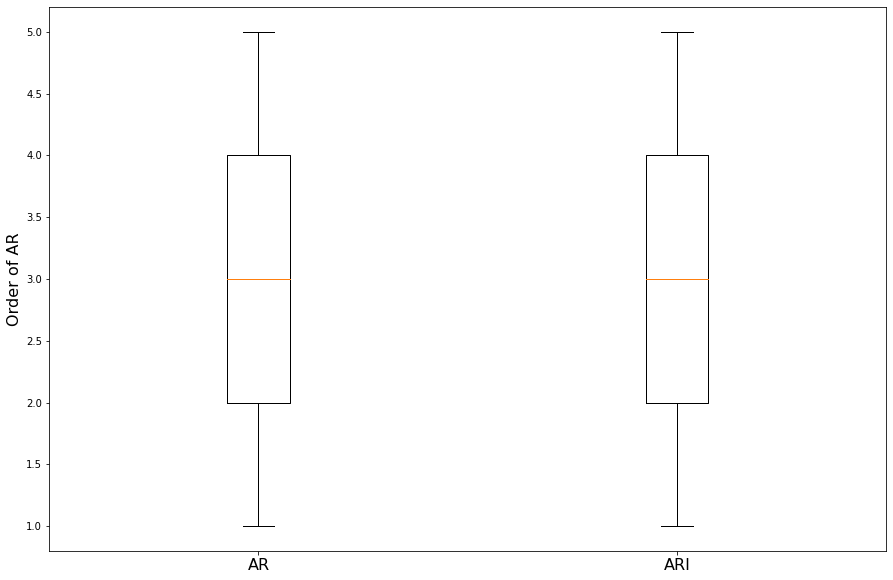

In [ ]:
ar_diff_not = {"AR": collect_bestcfg_ar_bic,"ARI":collect_bestcfg_ar_bic}
fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(ar_diff_not.values())
ax.set_xticklabels(ar_diff_not.keys(),fontsize=16)
ax.set_ylabel("Order of AR",fontsize=16)
plt.show()

#### Worth Learning?

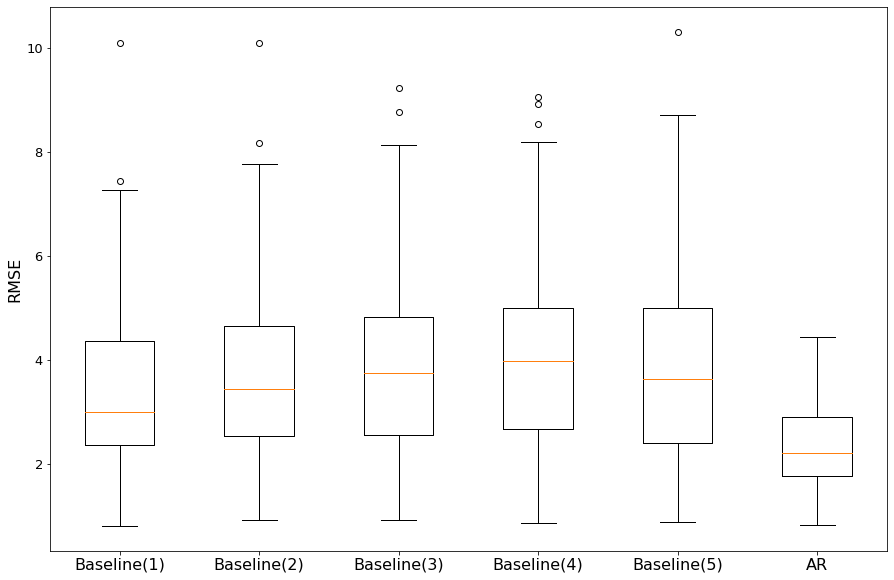

In [ ]:
rmse_baseline_diff["AR"] = collect_rmse_ar_bic
# rmse_baseline_diff["ARI"] = collect_rmse_ar_bic_old
# for ix, i in enumerate(collect_rmse_baseline):
#   rmse_collection[f"Base({ix+1})"] = i
fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(rmse_baseline_diff.values())
ax.set_xticklabels(rmse_baseline_diff.keys(),fontsize=16)
plt.yticks(fontsize=13)
ax.set_ylabel("RMSE",fontsize=16)
plt.savefig("AR_baseline_RMSE.pdf")
plt.show()

TODO:
- "Differentiate" the model name, and the color of boxplot

Yes, but at what cost

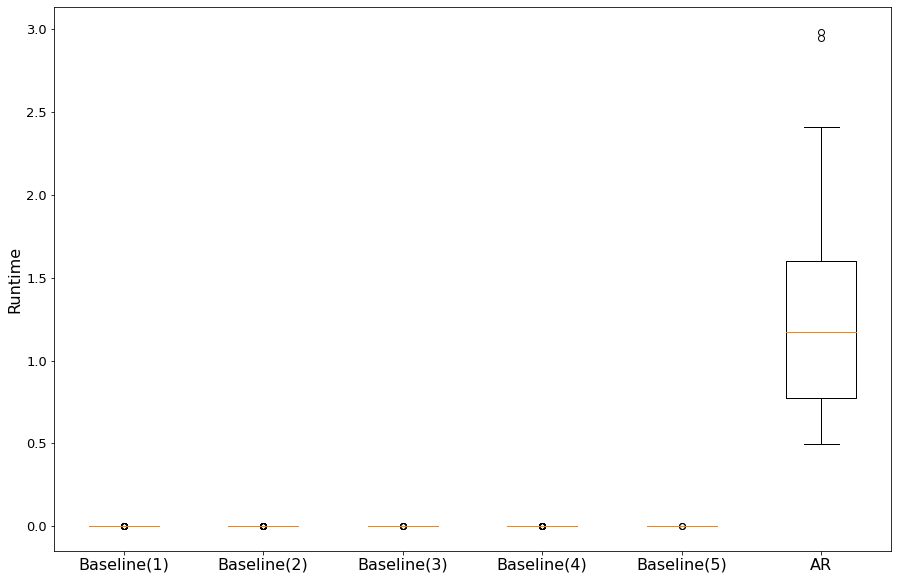

In [ ]:
runtime_baseline["AR"] = collect_runtime_ar_bic
# for ix, i in enumerate(collect_rmse_baseline):
#   rmse_collection[f"Base({ix+1})"] = i
fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(runtime_baseline.values())
ax.set_xticklabels(runtime_baseline.keys(),fontsize=16)
ax.set_ylabel("Runtime",fontsize=16)
plt.yticks(fontsize=13)
plt.savefig("AR_baseline_runtime.pdf")
plt.show()

Takes around 1 second to per location, with some exception of 3 seconds, while the baseline took almost no time.

### ARIMA(p,1,q)

In [ ]:
# warnings.filterwarnings("ignore")
# # Autoregressive model for all 50 points, lags from 1 - 30
# def Autoregressive_rmse(train, test, p_values, d_values, q_values):
#   # prepare training dataset
#   history = [x for x in train]
#   # make predictions
#   predictions = list()
#   for t in range(len(test)):
#     model = SARIMAX(history, order=(p_values, d_values, q_values),initialization='approximate_diffuse')
#     model_fit = model.fit()
#     yhat = model_fit.forecast()[0]
#     predictions.append(yhat)
#     history.append(test[t])
#   # calculate out of sample error
#   rmse = sqrt(mean_squared_error(test, predictions))
#   return rmse, predictions

# # load dataset
# collect_rmse_arima = []
# collect_prediction_arima = []
# collect_runtime_arima = []
# collect_bestcfg_arima = []
# for locat in range(0,50):
#   start = time.time()
#   x = ZSD_arr[locat,:]
#   train, test = x[:-10], x[-10:]
#   history = [x for x in train]
#   best_score, best_p, best_q = float("inf"), None, None
#   for i in range(1,6):
#     for j in range(1,6): 
#       # evaluate parameters
#       p_values = i
#       d_values = 1
#       q_values = j
#       model = SARIMAX(history, order=(p_values, d_values, q_values))
#       model_fit = model.fit()
#       if model_fit.bic<best_score:
#         best_score = model_fit.bic
#         best_p = i
#         best_q = j
  
#   rmse, prediction = Autoregressive_rmse(train,test,best_p,1,best_q)
#   end = time.time()
#   collect_rmse_arima.append(rmse)
#   collect_prediction_arima.append(prediction)
#   collect_runtime_arima.append(end-start)
#   collect_bestcfg_arima.append((best_p,best_q))

TODO:
- Use Pickle

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARIMA_pred.txt', 'w') as fp:
#     for item in collect_prediction_arima:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARIMA_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arima:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARIMA_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arima:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARIMA_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arima:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
# plt.boxplot(collect_rmse_arima)
# plt.show()

In [ ]:
# plt.boxplot(collect_runtime_arima)
# plt.show()

In [ ]:
collect_rmse_arima = np.loadtxt('./Results/Model Output/ARIMA_RMSE.txt')
collect_runtime_arima = np.loadtxt('./Results/Model Output/ARIMA_runtime.txt')

In [ ]:
# collect_bestcfg_arima = np.loadtxt("./Results/Model Output/ARIMA_cfg.txt")
collect_bestcfg_arima = []
with open('./Results/Model Output/ARIMA_cfg.txt') as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arima.append(row)
collect_bestcfg_arima = np.array(collect_bestcfg_arima)

In [ ]:
collect_prediction_arima = []
with open('./Results/Model Output/ARIMA_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(float(num))
        collect_prediction_arima.append(row)
collect_prediction_arima = np.array(collect_prediction_arima)

In [ ]:
pd.DataFrame(collect_bestcfg_arima,index=range(50))

0    1
0   1.0  1.0
1   1.0  1.0
2   1.0  1.0
3   1.0  1.0
4   1.0  1.0
5   2.0  1.0
6   1.0  1.0
7   1.0  1.0
8   1.0  1.0
9   1.0  1.0
10  1.0  1.0
11  1.0  1.0
12  1.0  1.0
13  1.0  1.0
14  1.0  1.0
15  1.0  1.0
16  1.0  1.0
17  1.0  1.0
18  1.0  1.0
19  1.0  1.0
20  1.0  1.0
21  1.0  1.0
22  1.0  1.0
23  1.0  1.0
24  1.0  1.0
25  1.0  1.0
26  1.0  1.0
27  1.0  1.0
28  1.0  1.0
29  1.0  1.0
30  1.0  1.0
31  1.0  1.0
32  1.0  1.0
33  1.0  1.0
34  1.0  1.0
35  2.0  1.0
36  2.0  1.0
37  1.0  1.0
38  1.0  1.0
39  1.0  1.0
40  1.0  1.0
41  1.0  1.0
42  1.0  1.0
43  1.0  1.0
44  1.0  1.0
45  1.0  1.0
46  1.0  1.0
47  1.0  1.0
48  1.0  1.0
49  1.0  1.0

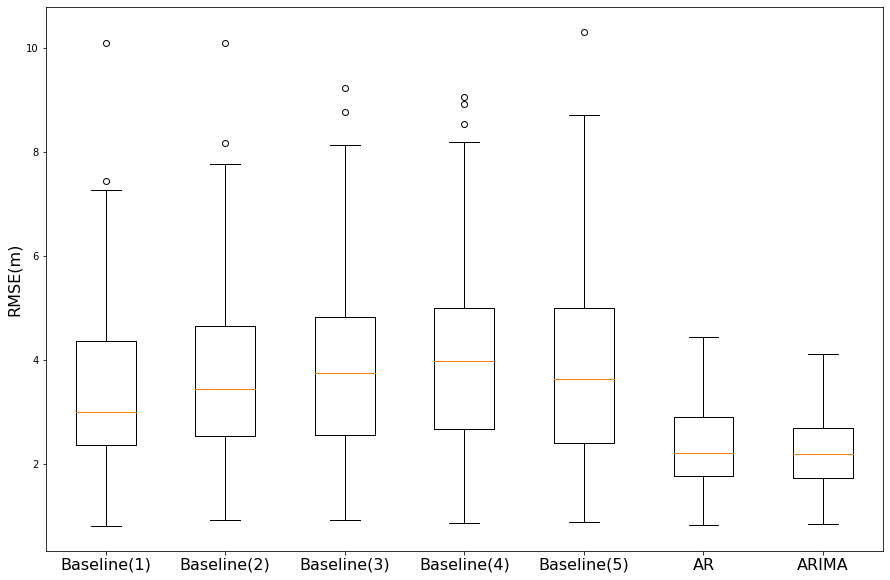

In [ ]:
rmse_baseline_diff["ARIMA"] = collect_rmse_arima
# for ix, i in enumerate(collect_rmse_baseline):
#   ar_baseline[f"Base({ix+1})"] = i
fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(rmse_baseline_diff.values())
ax.set_xticklabels(rmse_baseline_diff.keys(),fontsize=16)
ax.set_ylabel("RMSE(m)",fontsize=16)
plt.show()

There are some improvement from AR to ARIMA, the bias is around the same, however the variance of ARIMA is lower than AR, hence in terms of the prediction accuracy, ARIMA is an improvement from AR. Lets look at the cost.

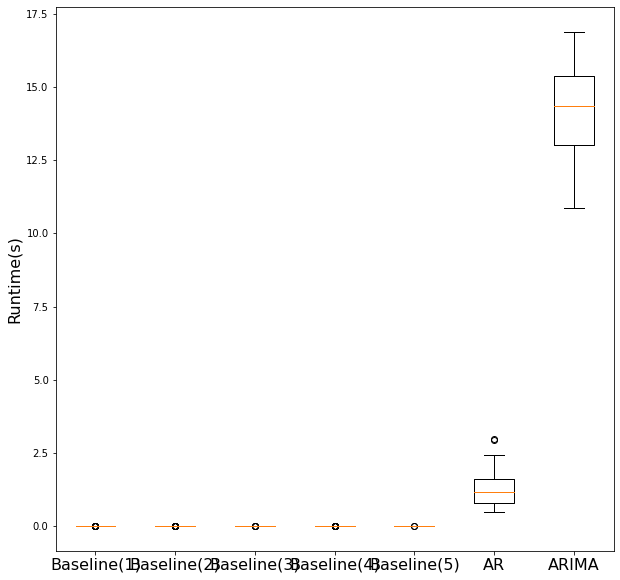

In [ ]:
runtime_baseline["ARIMA"] = collect_runtime_arima
# for ix, i in enumerate(collect_rmse_baseline):
#   rmse_collection[f"Base({ix+1})"] = i
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(runtime_baseline.values())
ax.set_xticklabels(runtime_baseline.keys(),fontsize=16)
ax.set_ylabel("Runtime(s)",fontsize=16)
plt.show()

In [ ]:
np.average(collect_runtime_arima) / np.average(collect_runtime_ar_bic)

11.237012014470055

About 11.23 times the computation costs! Maybe not too worth the effort... Lets look at SARIMA first before deciding

### SARIMA(p,1,q)x(P,D,Q)m

In [ ]:
# warnings.filterwarnings("ignore")

# collect_rmse_sarima = []
# collect_prediction_sarima = []
# collect_runtime_sarima = []
# collect_bestcfg_sarima = []
# start = time.time()
# cfg_list = sarima_configs(seasonal=[7])
# best_score, best_cfg = float("inf"), None
# for cfg in cfg_list:
#   print(cfg)
#   temp_bic = 0
#   # grid search


#   order, sorder, trend = cfg

#   for locat in range(50):
#     x = ZSD_arr[locat,:]
#     # train test split
#     train = x[:-10]
#     test = x[-10:]
#     history = [x for x in train]
#     model = SARIMAX(history,order=order,seasonal_order=sorder,trend=trend,initialization='approximate_diffuse')
#     model_fit = model.fit()
#     temp_bic += model_fit.bic
#   if temp_bic/50 < best_score:
#     best_score = model_fit.bic
#     best_cfg = cfg

# # Grid Search Complete, use best_cfg for prediction
# print(best_cfg)

# for locat in range(50):
#   predictions = list()
#   # split dataset
#   # seed history with training dataset
#   # step over each time-step in the test set
#   x = ZSD_arr[locat,:]
#   train = x[:-10]
#   test = x[-10:]
#   history = [x for x in train]
#   for i in range(len(test)):
#     # fit model and make forecast for history
#     yhat = sarima_forecast(history, best_cfg)
#     # store forecast in list of predictions
#     predictions.append(yhat)
#     # add actual observation to history for the next loop
#     history.append(test[i])

#   # Result
#   # estimate prediction error

#   error = measure_rmse(test, predictions)
#   collect_rmse_sarima.append(error)
#   collect_prediction_sarima.append(predictions)

# end = time.time()
# collect_runtime_sarima.append(end - start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/SARIMA_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_sarima:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/SARIMA_prediction.txt', 'w') as fp:
#     for item in collect_prediction_sarima:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/SARIMA_runtime.txt', 'w') as fp:
#     for item in collect_runtime_sarima:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/SARIMA_cfg.txt', 'w') as fp:
#     for item in best_cfg:
#       # write each item on a new line
#       fp.write("%s\n" % cfg)

In [ ]:
collect_rmse_sarima = np.loadtxt('./Results/Model Output/SARIMA_RMSE.txt')
collect_runtime_sarima = [np.loadtxt('./Results/Model Output/SARIMA_runtime.txt')]
collect_bestcfg_sarima = [(1, 1, 1), (0, 0, 0, 7), 'n']

In [ ]:
collect_prediction_sarima = []
with open('./Results/Model Output/SARIMA_prediction.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(float(num))
        collect_prediction_sarima.append(row)
collect_prediction_sarima = np.array(collect_prediction_sarima)

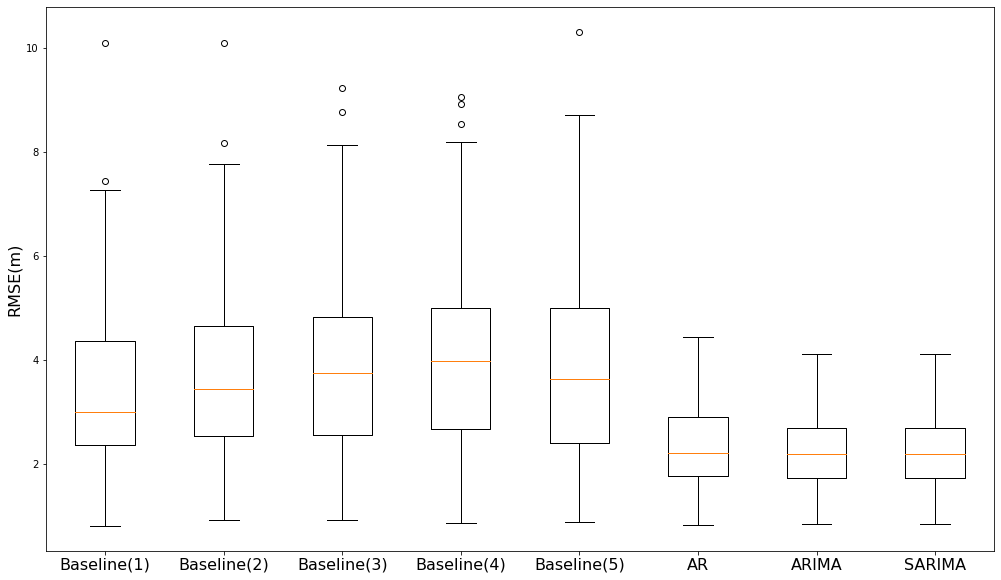

In [ ]:
rmse_baseline_diff["SARIMA"] = collect_rmse_sarima
# for ix, i in enumerate(collect_rmse_baseline):
#   ar_baseline[f"Base({ix+1})"] = i
fig, ax = plt.subplots(figsize=(17,10))
ax.boxplot(rmse_baseline_diff.values())
ax.set_xticklabels(rmse_baseline_diff.keys(),fontsize=16)
ax.set_ylabel("RMSE(m)",fontsize=16)
plt.show()

In [ ]:
outliers_count_baseline = [2,2,2,3,1,0,0,0]
outlier_locat_baseline = []
for ix, i in enumerate(rmse_baseline_diff):
  print(i)
  outliers_locat = []
  if outliers_count_baseline[ix] == 0:
    print(outliers_locat)
    continue
  outliers = sorted(np.array(rmse_baseline_diff[i]))[-outliers_count_baseline[ix]:]
  print(outliers)
  for j in outliers:
    outliers_locat.append(np.where(np.array(rmse_baseline_diff[i])==j))
  outlier_locat_baseline.append(outliers_locat)

Baseline(1)
[7.444612935545302, 10.085047829102658]
Baseline(2)
[8.156587736582726, 10.078440914160465]
Baseline(3)
[8.756998805914277, 9.216705927313884]
Baseline(4)
[8.537021720439036, 8.919511845170735, 9.053553928259294]
Baseline(5)
[10.300867833366917]
AR
[]
ARIMA
[]
SARIMA
[]


In [ ]:
outlier_locat_baseline

[[(array([40]),), (array([16]),)],
 [(array([31]),), (array([16]),)],
 [(array([31]),), (array([16]),)],
 [(array([16]),), (array([35]),), (array([31]),)],
 [(array([35]),)]]

In [ ]:
runtime_baseline["SARIMA"] = collect_runtime_sarima

total_runtime_collection = dict((k, sum(v)) for k, v in runtime_baseline.items())
# for ix, i in enumerate(collect_rmse_baseline):
#   rmse_collection[f"Base({ix+1})"] = i
print(tabulate([(k,v) for k, v in total_runtime_collection.items()],headers=["Model","Total RunTime(s)"]))

Model          Total RunTime(s)
-----------  ------------------
Baseline(1)          0.00391006
Baseline(2)          0.00344753
Baseline(3)          0.00388432
Baseline(4)          0.00445509
Baseline(5)          0.00400162
AR                  63.411
ARIMA              712.55
SARIMA            9802.6


In [ ]:
np.average(collect_rmse_ar_bic), np.std(collect_rmse_ar_bic)

(2.3507097047970165, 0.8748842777496314)

Fine Tuning SARIMA for all 50 locations resulted in SARIMA(1,1,1)x(0,0,0)7 to be chosen, which is the same as ARIMA models but with weekly differencing. This is why SARIMA gives very similar results to ARIMA. However with the added differencing, the computation time became significantly longer.

Hence, we conclude that amongst the models that we tried, AR model gives the best overall result, with average testing RMSE of 2.351, and standard deviation of 0.875.

### ARX

Next we ask the question whether the inclusion of exogenous  variable helps. We have several types of exogenous variable listed below:
- Neighbourhood Data
- Diffused Attenuation
- Chlorophyl Concentration
- Temperature
- ... And many more

Lets first analyze individual exogenous variables, then concatenate them together.

TODO:
- Investigate CCA (canonical correlation analysis)

In [ ]:
def getDataForSamplePoints(dataset_id, sample_idx,latitude_arr,longitude_arr , USERNAME = 'dgopaul', PASSWORD = '5pac3M4rin3'):
  data_store = copernicusmarine_datastore(dataset_id, USERNAME, PASSWORD)
  data = xr.open_dataset(data_store)
  sel_data = data.sel(lat=latitude_arr[[x[0] for x in sample_idx]],lon=longitude_arr[[x[1] for x in sample_idx]], method="nearest").sel(time=slice("2021-07-01","2022-03-07"))
  print(sel_data)
  return(sel_data)

#### KD and CHL

In [ ]:
KD = KD_data["KD490"][:,:,:].data
CHL = CHL_data["CHL"][:,:,:].data

In [ ]:
KD.shape, CHL.shape

((250, 601, 1247), (250, 601, 1247))

In [ ]:
KD_arr = []
CHL_arr = []
ZSD_arr = []
for lat, lon in sample_idx:
  KD_arr.append(list(KD[:,lat,lon]))
  CHL_arr.append(list(CHL[:,lat,lon]))
  ZSD_arr.append(list(zsd[:,lat,lon]))
KD_arr = np.array(KD_arr)
CHL_arr = np.array(CHL_arr)
ZSD_arr = np.array(ZSD_arr)

In [ ]:
del KD, CHL

In [ ]:
KD_arr.shape

(50, 250)

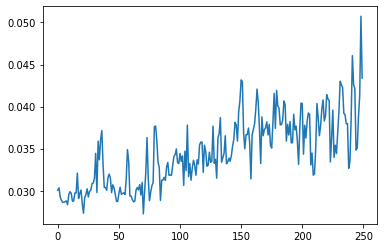

In [ ]:
KD_arr_rem_na = np.where(KD_arr==-999,np.nan,KD_arr)
plt.plot(KD_arr_rem_na[49,:])
plt.show()

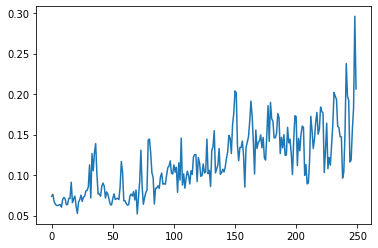

In [ ]:
CHL_arr_rem_na = np.where(CHL_arr==-999,np.nan,CHL_arr)
plt.plot(CHL_arr_rem_na[49,:])
plt.show()

In [ ]:
res = []
for i in range(50):
  r, p = stats.pearsonr(pd.Series(KD_arr_rem_na[i,:]), pd.Series(CHL_arr_rem_na[i,:]))
  res.append(r)

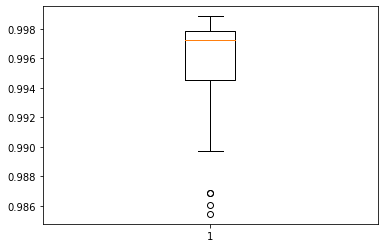

In [ ]:
plt.boxplot(res)
plt.show()

CHL and KD has very hgih correlation between each other, this means that we should be only using one of them as exogenous variable.

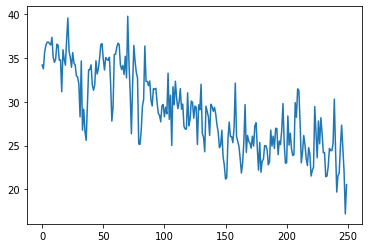

In [ ]:
plt.plot(ZSD_arr[49,:])
plt.show()

In [ ]:
res = []
for i in range(50):
  r, p = stats.pearsonr(pd.Series(ZSD_arr[i,:]), pd.Series(CHL_arr_rem_na[i,:]))
  res.append(r)

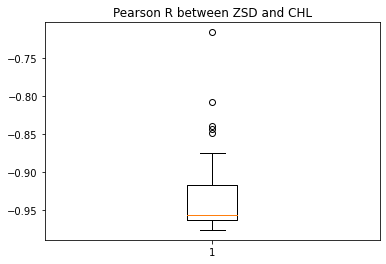

In [ ]:
plt.title("Pearson R between ZSD and CHL")
plt.boxplot(res)
plt.show()

In [ ]:
res = []
for i in range(50):
  r, p = stats.pearsonr(pd.Series(ZSD_arr[i,:]), pd.Series(KD_arr_rem_na[i,:]))
  res.append(r)

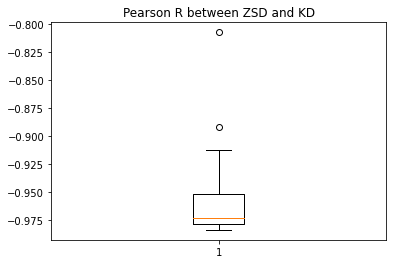

In [ ]:
plt.title("Pearson R between ZSD and KD")
plt.boxplot(res)
plt.show()

Correlatiion between CHL/KD and ZSD are largely negative, but the correlation between KD and ZSD seems larger. We will choose KD instead of ZSD as the exogenous variable.

ARX(1):
ZSD_t = a* ZSD_t-1 + b*KD_t-1 + e_t

let ZSD_t be 240*1 Vector, ZSD_t-1 be 240*1 Vector, a and b is 1x1 (scaler).

ZSD_t = [ZSD_t-1,KD_t-1]*A + e_t
where ZSD_t is 240x1, [ZSD_t-1,KD_t-1] is 240x2, and A is 2x1

##### KD Only

In [ ]:
# warnings.filterwarnings("ignore")

# lag_zsd = 3


# collect_rmse_arx_kd = []
# collect_runtime_arx_kd = []
# collect_bestcfg_arx_kd = []
# collect_prediction_arx_kd = []

# for locat in range(50):
#   start = time.time()
#   temp_KD = KD_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_kd_range = range(1,6)
#   best_score, best_X, best_p = float("inf"), None, None

#   for i in order_kd_range:
#     x = pd.DataFrame([temp_ZSD,temp_KD])
#     x = x.T
#     x.columns =["ZSD","KD_lag0"]

#     for j in range(i):
#       x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#     x.dropna(axis=0,how="any",inplace=True)

#     exo_col = [f"KD_lag{x}" for x in range(1,i+1)]
    
#     # train validation split
#     train = x.iloc[:-10,:]
#     validation = train.iloc[-10:,:]
#     # Grid Search for p
#     for k in range(1,6):

#       # Prediction
#       predictions = list()

#       history = [x for x in train["ZSD"]]
#       exog_history = train[exo_col].to_numpy()

#       model = SARIMAX(history, exog=exog_history,order = (k,1,0), seasonal_order=(0,0,0,0))
#       model_fit = model.fit(disp=False)
#       if model_fit.bic < best_score:
#         best_score = model_fit.bic
#         best_X = i
#         best_p = k
#   collect_bestcfg_arx_kd.append((best_X,best_p))
#   # Using the best lag_kd found using train-validation approach
  

#   x = pd.DataFrame([temp_ZSD,temp_KD])
#   x = x.T
#   x.columns =["ZSD","KD_lag0"]

#   for i in range(best_X):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"KD_lag{x}" for x in range(1,best_X+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_kd.append(rmse)
#   collect_prediction_arx_kd.append(predictions)
#   collect_runtime_arx_kd.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_KD_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_kd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_KD_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_kd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_KD_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_kd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_KD_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_kd:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_kd = np.loadtxt('./Results/Model Output/ARX_KD_RMSE.txt')
collect_runtime_arx_kd = np.loadtxt('./Results/Model Output/ARX_KD_runtime.txt')

In [ ]:
collect_bestcfg_arx_kd = []
with open("./Results/Model Output/ARX_KD_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_kd.append(row)
collect_bestcfg_arx_kd = np.array(collect_bestcfg_arx_kd)

In [ ]:
collect_prediction_arx_kd = []
with open('./Results/Model Output/ARX_KD_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_kd.append(row)
collect_prediction_arx_kd = np.array(collect_prediction_arx_kd)

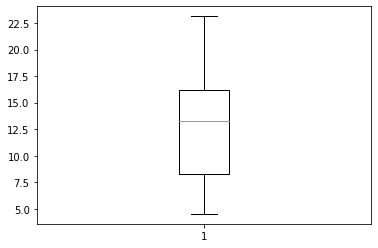

In [ ]:
plt.boxplot(collect_runtime_arx_kd)
plt.show()

In [ ]:
sum(collect_runtime_arx_kd)

639.8095586299896

##### CHL Only

In [ ]:
# warnings.filterwarnings("ignore")

# lag_zsd = 3


# collect_rmse_arx_chl = []
# collect_runtime_arx_chl = []
# collect_bestcfg_arx_chl = []
# collect_prediction_arx_chl = []

# for locat in range(50):
#   start = time.time()
#   temp_CHL = CHL_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_chl_range = range(1,6)
#   best_score, best_X, best_p = float("inf"), None, None

#   for i in order_chl_range:
#     x = pd.DataFrame([temp_ZSD,temp_CHL])
#     x = x.T
#     x.columns =["ZSD","CHL_lag0"]

#     for j in range(i):
#       x[f"CHL_lag{j+1}"] = x[f"CHL_lag{j}"].shift(1)

#     x.dropna(axis=0,how="any",inplace=True)

#     exo_col = [f"CHL_lag{x}" for x in range(1,i+1)]
    
#     # train validation split
#     train = x.iloc[:-10,:]
#     validation = train.iloc[-10:,:]
#     # Grid Search for p
#     for k in range(1,6):

#       # Prediction
#       predictions = list()

#       history = [x for x in train["ZSD"]]
#       exog_history = train[exo_col].to_numpy()

#       model = SARIMAX(history, exog=exog_history,order = (k,1,0), seasonal_order=(0,0,0,0))
#       model_fit = model.fit(disp=False)
#       if model_fit.bic < best_score:
#         best_score = model_fit.bic
#         best_X = i
#         best_p = k
#   collect_bestcfg_arx_chl.append((best_X,best_p))
#   # Using the best lag_kd found using train-validation approach
  

#   x = pd.DataFrame([temp_ZSD,temp_CHL])
#   x = x.T
#   x.columns =["ZSD","CHL_lag0"]

#   for i in range(best_X):
#     x[f"CHL_lag{i+1}"] = x[f"CHL_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"CHL_lag{x}" for x in range(1,best_X+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_chl.append(rmse)
#   collect_prediction_arx_chl.append(predictions)
#   collect_runtime_arx_chl.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_CHL_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_chl:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_CHL_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_chl:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_CHL_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_chl:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_CHL_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_chl:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_chl = np.loadtxt('./Results/Model Output/ARX_CHL_RMSE.txt')
collect_runtime_arx_chl = np.loadtxt('./Results/Model Output/ARX_CHL_runtime.txt')

In [ ]:
collect_bestcfg_arx_chl = []
with open("./Results/Model Output/ARX_CHL_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_chl.append(row)
collect_bestcfg_arx_chl = np.array(collect_bestcfg_arx_chl)

In [ ]:
collect_prediction_arx_chl = []
with open('./Results/Model Output/ARX_CHL_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_chl.append(row)
collect_prediction_arx_chl = np.array(collect_prediction_arx_chl)

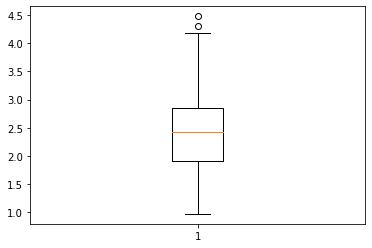

In [ ]:
plt.boxplot(collect_rmse_arx_chl)
plt.show()

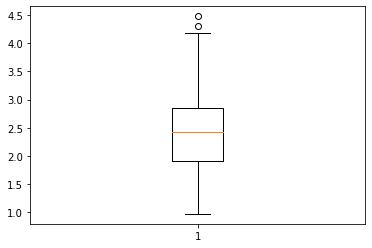

In [ ]:
plt.boxplot(collect_rmse_arx_chl)
plt.show()

##### Concatenated

In [ ]:
# warnings.filterwarnings("ignore")

# lag_zsd = 3


# collect_rmse_arx_chlkd = []
# collect_runtime_arx_chlkd = []
# collect_bestcfg_arx_chlkd = []
# collect_prediction_arx_chlkd = []

# for locat in range(50):
#   start = time.time()
#   temp_CHL = CHL_arr[locat,:]
#   temp_KD = KD_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_chl_range = range(1,6)
#   order_kd_range = range(1,6)
#   best_score, best_X1, best_X2, best_p = float("inf"), None, None, None

#   for i in order_chl_range:
#     for k in order_kd_range:
#       x = pd.DataFrame([temp_ZSD,temp_CHL,temp_KD])
#       x = x.T
#       x.columns =["ZSD","CHL_lag0","KD_lag0"]

#       for j in range(i):
#         x[f"CHL_lag{j+1}"] = x[f"CHL_lag{j}"].shift(1)

#       for j in range(k):
#         x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#       x.dropna(axis=0,how="any",inplace=True)

#       exo_col = [f"CHL_lag{x}" for x in range(1,i+1)]
#       exo_col += [f"KD_lag{x}" for x in range(1,k+1)]

      
#       # train validation split
#       train = x.iloc[:-10,:]
#       validation = train.iloc[-10:,:]
#       # Grid Search for p
#       for p in range(1,6):

#         # Prediction
#         predictions = list()
#         history = [x for x in train["ZSD"]]
#         exog_history = train[exo_col].to_numpy()

#         model = SARIMAX(history, exog=exog_history,order = (p,1,0), seasonal_order=(0,0,0,0))
#         model_fit = model.fit(disp=False)
#         if model_fit.bic < best_score:
#           best_score = model_fit.bic
#           best_X1 = i
#           best_X2 = k
#           best_p = p
#   collect_bestcfg_arx_chlkd.append((best_X1,best_X2,best_p))
  

#   x = pd.DataFrame([temp_ZSD,temp_KD,temp_CHL])
#   x = x.T
#   x.columns =["ZSD","KD_lag0","CHL_lag0"]

#   for i in range(best_X1):
#     x[f"CHL_lag{i+1}"] = x[f"CHL_lag{i}"].shift(1)

#   for i in range(best_X2):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"CHL_lag{x}" for x in range(1,best_X1+1)]
#   exo_col += [f"KD_lag{x}" for x in range(1,best_X2+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_chlkd.append(rmse)
#   collect_prediction_arx_chlkd.append(predictions)
#   collect_runtime_arx_chlkd.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_CHLKD_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_chlkd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_CHLKD_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_chlkd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_CHLKD_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_chlkd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_CHLKD_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_chlkd:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_chlkd = np.loadtxt('./Results/Model Output/ARX_CHLKD_RMSE.txt')
collect_runtime_arx_chlkd = np.loadtxt('./Results/Model Output/ARX_CHLKD_runtime.txt')

In [ ]:
collect_bestcfg_arx_chlkd = []
with open("./Results/Model Output/ARX_CHLKD_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_chlkd.append(row)
collect_bestcfg_arx_chlkd = np.array(collect_bestcfg_arx_chlkd)

In [ ]:
collect_prediction_arx_chlkd = []
with open('./Results/Model Output/ARX_CHLKD_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_chlkd.append(row)
collect_prediction_arx_chlkd = np.array(collect_prediction_arx_chlkd)

Model           AVG test RMSE    Median RMSE    Variance    Outlier
------------  ---------------  -------------  ----------  ---------
AR                    2.35071        2.19888    0.765422          0
ARX (KD)              2.48057        2.42394    0.711215          3
ARX (CHL)             2.46454        2.42235    0.712766          2
ARX (CHL,KD)          2.49449        2.38628    0.720664          1


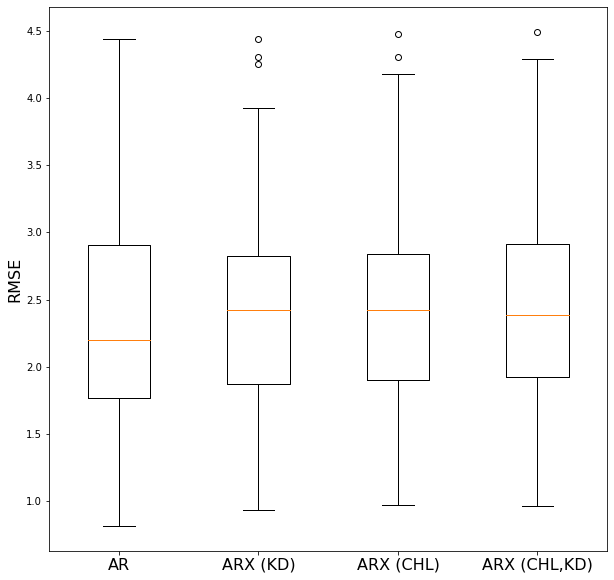

In [ ]:
arx_collection = {"AR":collect_rmse_ar_bic,"ARX (KD)":collect_rmse_arx_kd,"ARX (CHL)":collect_rmse_arx_chl,"ARX (CHL,KD)":collect_rmse_arx_chlkd}

tab_list = []
outlier_list = [0,3,2,1]
for ix, i in enumerate(arx_collection):
  avg = np.average(arx_collection[i])
  var = np.var(arx_collection[i])
  median = np.median(arx_collection[i])
  if i == "AR":
    tab_list.append(["AR",avg,median,var,outlier_list[ix]])
  else:
    tab_list.append([i,avg,median,var,outlier_list[ix]])
print(tabulate(tab_list,headers=["Model","AVG test RMSE","Median RMSE","Variance","Outlier"]))

fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(arx_collection.values())
ax.set_xticklabels(arx_collection.keys(),fontsize=16)
ax.set_ylabel("RMSE",fontsize=16)
plt.savefig("ARvsARX(KD+CHL).pdf")
plt.show()

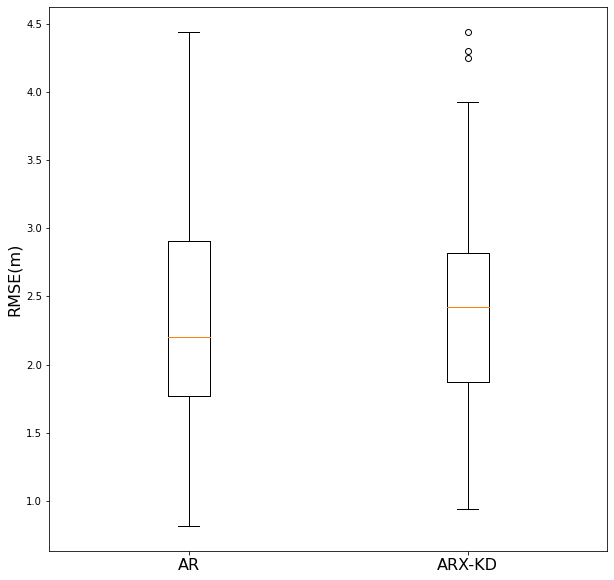

In [ ]:
temp_dict = {"AR":collect_rmse_ar_bic,"ARX-KD":collect_rmse_arx_kd}
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(temp_dict.values())
ax.set_xticklabels(temp_dict.keys(),fontsize=16)
ax.set_ylabel("RMSE(m)",fontsize=16)
plt.show()

#### SPM

In [ ]:
with open('./Results/SPM data.pkl','rb') as f:
  SPM_arr = pickle.load(f)
  print(SPM_arr.shape)

(50, 250)


In [ ]:
SPM_df = pd.DataFrame(SPM_arr)
print(SPM_df)
SPM_df = SPM_df.apply(lambda x: x.interpolate(method="linear").interpolate(method ='linear', limit_direction ='backward'))
SPM_arr = SPM_df.to_numpy()

         0         1         2         3         4         5         6    \
0   0.442027  0.528753  0.352361  0.327700  0.404682  0.348628  0.297128   
1        NaN  0.303151  0.300904       NaN  0.455608  0.301409       NaN   
2        NaN       NaN       NaN       NaN  0.289636  0.315330  0.313989   
3   0.326459  0.502554  0.382060  0.384357  0.376914  0.337237  0.310233   
4   0.339449  0.232003  0.364328  0.413869  0.346864  0.348606  0.297939   
5   0.217850       NaN  0.181342  0.368733  0.293912       NaN       NaN   
6        NaN  0.241979  0.335844  0.254001  0.362520  0.355152  0.356595   
7   0.391894  0.373548  0.520166  0.435966  0.464734  0.374089  0.341207   
8   0.353734  0.380396  0.395641  0.399806  0.486357  0.388858  0.313738   
9        NaN  0.320487  0.321516  0.281428  0.345650  0.376055  0.437574   
10  0.379265  0.419578  0.368078  0.515911  0.542072  0.453980  0.356008   
11  0.241499  0.290722       NaN  0.259835  0.223113  0.250054  0.372942   
12       NaN

#### ST

In [ ]:
with open('./Results/ST data.pkl','rb') as f:
  ST_arr = pickle.load(f)
  print(ST_arr.shape)

(50, 250)


In [ ]:
ST_arr = pd.DataFrame(ST_arr)
ST_arr = ST_arr.apply(lambda x: x.interpolate())
ST_arr = ST_arr.to_numpy()

In [ ]:
ST_arr -= 273.15

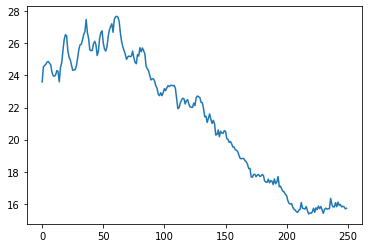

In [ ]:
plt.plot(ST_arr[49,:])
plt.show()

In [ ]:
collect_rmse_arx_st = np.loadtxt('./Results/Model Output/ARX_ST_RMSE.txt')
collect_runtime_arx_st = np.loadtxt('./Results/Model Output/ARX_ST_runtime.txt')

In [ ]:
collect_bestcfg_arx_st = []
with open("./Results/Model Output/ARX_ST_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_st.append(row)
collect_bestcfg_arx_st = np.array(collect_bestcfg_arx_st)

In [ ]:
collect_prediction_arx_st = []
with open('./Results/Model Output/ARX_ST_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_st.append(row)
collect_prediction_arx_st = np.array(collect_prediction_arx_st)

#### SWH

In [ ]:
SWH = SWH_data["VHM0"][:,:,:].data

In [ ]:
SWH.shape

(1993, 301, 625)

In [ ]:
SWH_daily = []
for i in range(0,SWH.shape[0],8):
  SWH_daily.append(SWH[i,:,:])
SWH_daily = np.array(SWH_daily)

In [ ]:
SWH_daily.shape

(250, 301, 625)

In [ ]:
# https://stackoverflow.com/questions/43153531/extracting-value-form-netcdf-for-location-and-across-time-range
def variable_pull(site_lat, site_lon, lat, lon, var, time_slice):
    lat_idx = (np.abs(lat-site_lat)).argmin()
    lon_idx = (np.abs(lon-site_lon)).argmin()
    if time_slice is None:
      return lat_idx, lon_idx , var[:,lat_idx,lon_idx]
    else:
      return lat_idx, lon_idx, var[time_slice, lat_idx, lon_idx]

In [ ]:
SWH_lat = SWH_data["latitude"][:].data
SWH_lon = SWH_data["longitude"][:].data

In [ ]:
SWH_arr = []
lat_lon_SWH = []
for lat_id, lon_id in sample_idx:
  SWH_lat_idx, SWH_lon_idx , SWH_wind = variable_pull(latitude[lat_id],longitude[lon_id],SWH_lat,SWH_lon,SWH_daily,None)
  SWH_arr.append(SWH_wind)
  lat_lon_SWH.append((SWH_lat_idx, SWH_lon_idx))
SWH_arr = np.array(SWH_arr)
lat_lon_SWH = np.array(lat_lon_SWH)

In [ ]:
lat_lon_SWH.shape, SWH_arr.shape

((50, 2), (50, 250))

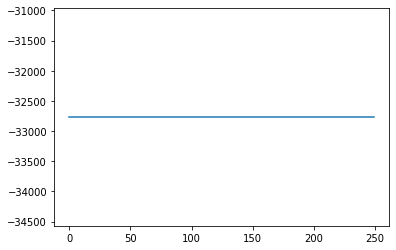

In [ ]:
plt.plot(SWH_arr[27,:])
plt.show()

In [ ]:
_, _, SWH_arr[27] = variable_pull(latitude[sample_idx[27][0]]-1, longitude[sample_idx[27][1]],SWH_lat,SWH_lon,SWH_daily,None)

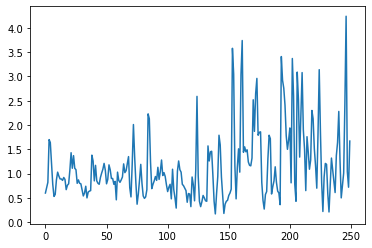

In [ ]:
plt.plot(SWH_arr[27,:])
plt.show()

In [ ]:
resswh = []
for i in range(50):
  r, p = stats.pearsonr(pd.Series(ZSD_arr[i,:]), pd.Series(SWH_arr[i,:]))
  resswh.append(r)

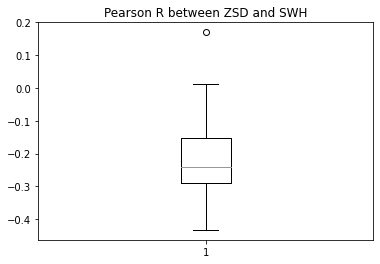

In [ ]:
plt.title("Pearson R between ZSD and SWH")
plt.boxplot(resswh)
plt.show()

#### WIND

Somethow there is a Timeout limit set as 2 minutes.

Solution:
- Change timeout limit
- Work within the timeout limit and extract data piece by piece

TODO:
- Check the time where ZSD was taken
- Maybe use mean or median as daily

In [ ]:
east_wind1 = WIND_east_data1["eastward_wind"][:,:,:].data
east_wind2 = WIND_east_data2["eastward_wind"][:,:,:].data
wind_east_arr = np.concatenate((east_wind1,east_wind2))
del east_wind1, east_wind2

In [ ]:
wind_lat = WIND_east_data1["lat"][:].data
wind_lon = WIND_east_data1["lon"][:].data

In [ ]:
wind_east_arr.shape
del WIND_east_data1, WIND_east_data2

In [ ]:
wind_east_daily = []
for i in range(0,wind_east_arr.shape[0]-1,24):
  wind_east_daily.append(wind_east_arr[i,:,:])
wind_east_daily = np.array(wind_east_daily)

In [ ]:
wind_east_daily.shape

(250, 201, 456)

In [ ]:
north_wind1 = WIND_north_data1["northward_wind"][:,:,:].data
north_wind2 = WIND_north_data2["northward_wind"][:,:,:].data
wind_north_arr = np.concatenate((north_wind1,north_wind2))
del north_wind1, north_wind2

In [ ]:
wind_north_daily = []
for i in range(0,wind_north_arr.shape[0]-1,24):
  wind_north_daily.append(wind_north_arr[i,:,:])
wind_north_daily = np.array(wind_north_daily)

In [ ]:
wind_north_daily.shape
del WIND_north_data1, WIND_north_data2

In [ ]:
# https://stackoverflow.com/questions/43153531/extracting-value-form-netcdf-for-location-and-across-time-range
def variable_pull(site_lat, site_lon, lat, lon, var, time_slice):
    lat_idx = (np.abs(lat-site_lat)).argmin()
    lon_idx = (np.abs(lon-site_lon)).argmin()
    if time_slice is None:
      return lat_idx, lon_idx , var[:,lat_idx,lon_idx]
    else:
      return lat_idx, lon_idx, var[time_slice, lat_idx, lon_idx]

In [ ]:
wind_arr = []
lat_lon_wind = []
for lat_id, lon_id in sample_idx:
  north_lat_idx, north_lon_idx , north_wind = variable_pull(latitude[lat_id],longitude[lon_id],wind_lat,wind_lon,wind_north_daily,None)
  _, _ , east_wind = variable_pull(latitude[lat_id],longitude[lon_id],wind_lat,wind_lon,wind_east_daily,None)
  wind_vel = np.sqrt(north_wind**2 + east_wind**2)
  wind_arr.append(wind_vel)
  lat_lon_wind.append((north_lat_idx, north_lon_idx))
wind_arr = np.array(wind_arr)
lat_lon_wind = np.array(lat_lon_wind)

In [ ]:
lat_lon_wind.shape, wind_arr.shape

((50, 2), (50, 250))

In [ ]:
east_wind_arr = []
north_wind_arr = []
for i in range(50):
  east_wind_arr.append(wind_east_daily[:,lat_lon_wind[i,0],lat_lon_wind[i,1]])
  north_wind_arr.append(wind_north_daily[:,lat_lon_wind[i,0],lat_lon_wind[i,1]])
east_wind_arr = np.array(east_wind_arr)
north_wind_arr = np.array(north_wind_arr)

In [ ]:
east_wind_arr.shape, north_wind_arr.shape

((50, 250), (50, 250))

In [ ]:
direction_wind_arr = np.arccos(east_wind_arr/wind_arr)

##### East-wind

In [ ]:
# warnings.filterwarnings("ignore")
# collect_rmse_arx_ew = []
# collect_runtime_arx_ew = []
# collect_bestcfg_arx_ew = []
# collect_prediction_arx_ew = []

# for locat in range(50):
#   start = time.time()
#   temp_KD = east_wind_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_kd_range = range(1,6)
#   best_score, best_X, best_p = float("inf"), None, None

#   for i in order_kd_range:
#     x = pd.DataFrame([temp_ZSD,temp_KD])
#     x = x.T
#     x.columns =["ZSD","KD_lag0"]

#     for j in range(i):
#       x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#     x.dropna(axis=0,how="any",inplace=True)

#     exo_col = [f"KD_lag{x}" for x in range(1,i+1)]
    
#     # train validation split
#     train = x.iloc[:-10,:]
#     validation = train.iloc[-10:,:]
#     # Grid Search for p
#     for k in range(1,6):

#       # Prediction
#       predictions = list()

#       history = [x for x in train["ZSD"]]
#       exog_history = train[exo_col].to_numpy()

#       model = SARIMAX(history, exog=exog_history,order = (k,1,0), seasonal_order=(0,0,0,0))
#       model_fit = model.fit(disp=False)
#       if model_fit.bic < best_score:
#         best_score = model_fit.bic
#         best_X = i
#         best_p = k
#   collect_bestcfg_arx_ew.append((best_X,best_p))
#   # Using the best lag_kd found using train-validation approach
  

#   x = pd.DataFrame([temp_ZSD,temp_KD])
#   x = x.T
#   x.columns =["ZSD","KD_lag0"]

#   for i in range(best_X):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"KD_lag{x}" for x in range(1,best_X+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_ew.append(rmse)
#   collect_prediction_arx_ew.append(predictions)
#   collect_runtime_arx_ew.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_EW_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_ew:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EW_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_ew:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EW_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_ew:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EW_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_ew:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_ew = np.loadtxt('./Results/Model Output/ARX_EW_RMSE.txt')
collect_runtime_arx_ew = np.loadtxt('./Results/Model Output/ARX_EW_runtime.txt')

In [ ]:
collect_bestcfg_arx_ew = []
with open("./Results/Model Output/ARX_EW_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_ew.append(row)
collect_bestcfg_arx_ew = np.array(collect_bestcfg_arx_ew)

In [ ]:
collect_prediction_arx_ew = []
with open('./Results/Model Output/ARX_EW_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_ew.append(row)
collect_prediction_arx_ew = np.array(collect_prediction_arx_ew)

##### North-wind

In [ ]:
# warnings.filterwarnings("ignore")
# collect_rmse_arx_nw = []
# collect_runtime_arx_nw = []
# collect_bestcfg_arx_nw = []
# collect_prediction_arx_nw = []

# for locat in range(50):
#   start = time.time()
#   temp_KD = north_wind_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_kd_range = range(1,6)
#   best_score, best_X, best_p = float("inf"), None, None

#   for i in order_kd_range:
#     x = pd.DataFrame([temp_ZSD,temp_KD])
#     x = x.T
#     x.columns =["ZSD","KD_lag0"]

#     for j in range(i):
#       x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#     x.dropna(axis=0,how="any",inplace=True)

#     exo_col = [f"KD_lag{x}" for x in range(1,i+1)]
    
#     # train validation split
#     train = x.iloc[:-10,:]
#     validation = train.iloc[-10:,:]
#     # Grid Search for p
#     for k in range(1,6):

#       # Prediction
#       predictions = list()

#       history = [x for x in train["ZSD"]]
#       exog_history = train[exo_col].to_numpy()

#       model = SARIMAX(history, exog=exog_history,order = (k,1,0), seasonal_order=(0,0,0,0))
#       model_fit = model.fit(disp=False)
#       if model_fit.bic < best_score:
#         best_score = model_fit.bic
#         best_X = i
#         best_p = k
#   collect_bestcfg_arx_nw.append((best_X,best_p))
#   # Using the best lag_kd found using train-validation approach
  

#   x = pd.DataFrame([temp_ZSD,temp_KD])
#   x = x.T
#   x.columns =["ZSD","KD_lag0"]

#   for i in range(best_X):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"KD_lag{x}" for x in range(1,best_X+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_nw.append(rmse)
#   collect_prediction_arx_nw.append(predictions)
#   collect_runtime_arx_nw.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_NW_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_nw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_NW_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_nw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_NW_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_nw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_NW_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_nw:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_nw = np.loadtxt('./Results/Model Output/ARX_NW_RMSE.txt')
collect_runtime_arx_nw = np.loadtxt('./Results/Model Output/ARX_NW_runtime.txt')

In [ ]:
collect_bestcfg_arx_nw = []
with open("./Results/Model Output/ARX_NW_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_nw.append(row)
collect_bestcfg_arx_nw = np.array(collect_bestcfg_arx_nw)

In [ ]:
collect_prediction_arx_nw = []
with open('./Results/Model Output/ARX_NW_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_nw.append(row)
collect_prediction_arx_nw = np.array(collect_prediction_arx_nw)

##### Wind Speed

In [ ]:
# warnings.filterwarnings("ignore")
# collect_rmse_arx_ws = []
# collect_runtime_arx_ws = []
# collect_bestcfg_arx_ws = []
# collect_prediction_arx_ws = []

# for locat in range(50):
#   start = time.time()
#   temp_KD = wind_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_kd_range = range(1,6)
#   best_score, best_X, best_p = float("inf"), None, None

#   for i in order_kd_range:
#     x = pd.DataFrame([temp_ZSD,temp_KD])
#     x = x.T
#     x.columns =["ZSD","KD_lag0"]

#     for j in range(i):
#       x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#     x.dropna(axis=0,how="any",inplace=True)

#     exo_col = [f"KD_lag{x}" for x in range(1,i+1)]
    
#     # train validation split
#     train = x.iloc[:-10,:]
#     validation = train.iloc[-10:,:]
#     # Grid Search for p
#     for k in range(1,6):

#       # Prediction
#       predictions = list()

#       history = [x for x in train["ZSD"]]
#       exog_history = train[exo_col].to_numpy()

#       model = SARIMAX(history, exog=exog_history,order = (k,1,0), seasonal_order=(0,0,0,0))
#       model_fit = model.fit(disp=False)
#       if model_fit.bic < best_score:
#         best_score = model_fit.bic
#         best_X = i
#         best_p = k
#   collect_bestcfg_arx_ws.append((best_X,best_p))
#   # Using the best lag_kd found using train-validation approach
  

#   x = pd.DataFrame([temp_ZSD,temp_KD])
#   x = x.T
#   x.columns =["ZSD","KD_lag0"]

#   for i in range(best_X):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"KD_lag{x}" for x in range(1,best_X+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_ws.append(rmse)
#   collect_prediction_arx_ws.append(predictions)
#   collect_runtime_arx_ws.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_WS_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_ws:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_WS_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_ws:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_WS_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_ws:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_WS_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_ws:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_ws = np.loadtxt('./Results/Model Output/ARX_WS_RMSE.txt')
collect_runtime_arx_ws = np.loadtxt('./Results/Model Output/ARX_WS_runtime.txt')

In [ ]:
collect_bestcfg_arx_ws = []
with open("./Results/Model Output/ARX_WS_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_ws.append(row)
collect_bestcfg_arx_ws = np.array(collect_bestcfg_arx_ws)

In [ ]:
collect_prediction_arx_ws = []
with open('./Results/Model Output/ARX_WS_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_ws.append(row)
collect_prediction_arx_ws = np.array(collect_prediction_arx_ws)

##### Direction

In [ ]:
# warnings.filterwarnings("ignore")
# collect_rmse_arx_dw = []
# collect_runtime_arx_dw = []
# collect_bestcfg_arx_dw = []
# collect_prediction_arx_dw = []

# for locat in range(50):
#   start = time.time()
#   temp_KD = direction_wind_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_kd_range = range(1,6)
#   best_score, best_X, best_p = float("inf"), None, None

#   for i in order_kd_range:
#     x = pd.DataFrame([temp_ZSD,temp_KD])
#     x = x.T
#     x.columns =["ZSD","KD_lag0"]

#     for j in range(i):
#       x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#     x.dropna(axis=0,how="any",inplace=True)

#     exo_col = [f"KD_lag{x}" for x in range(1,i+1)]
    
#     # train validation split
#     train = x.iloc[:-10,:]
#     validation = train.iloc[-10:,:]
#     # Grid Search for p
#     for k in range(1,6):

#       # Prediction
#       predictions = list()

#       history = [x for x in train["ZSD"]]
#       exog_history = train[exo_col].to_numpy()

#       model = SARIMAX(history, exog=exog_history,order = (k,1,0), seasonal_order=(0,0,0,0))
#       model_fit = model.fit(disp=False)
#       if model_fit.bic < best_score:
#         best_score = model_fit.bic
#         best_X = i
#         best_p = k
#   collect_bestcfg_arx_dw.append((best_X,best_p))
#   # Using the best lag_kd found using train-validation approach
  

#   x = pd.DataFrame([temp_ZSD,temp_KD])
#   x = x.T
#   x.columns =["ZSD","KD_lag0"]

#   for i in range(best_X):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"KD_lag{x}" for x in range(1,best_X+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_dw.append(rmse)
#   collect_prediction_arx_dw.append(predictions)
#   collect_runtime_arx_dw.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_DW_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_dw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_DW_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_dw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_DW_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_dw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_DW_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_dw:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_dw = np.loadtxt('./Results/Model Output/ARX_DW_RMSE.txt')
collect_runtime_arx_dw = np.loadtxt('./Results/Model Output/ARX_DW_runtime.txt')

In [ ]:
collect_bestcfg_arx_dw = []
with open("./Results/Model Output/ARX_DW_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_dw.append(row)
collect_bestcfg_arx_dw = np.array(collect_bestcfg_arx_dw)

In [ ]:
collect_prediction_arx_dw = []
with open('./Results/Model Output/ARX_DW_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_dw.append(row)
collect_prediction_arx_dw = np.array(collect_prediction_arx_dw)

##### Concatenated

###### East and North

In [ ]:
# warnings.filterwarnings("ignore")

# collect_rmse_arx_ewnw = []
# collect_runtime_arx_ewnw = []
# collect_bestcfg_arx_ewnw = []
# collect_prediction_arx_ewnw = []

# for locat in range(50):
#   start = time.time()
#   temp_CHL = north_wind_arr[locat,:]
#   temp_KD = east_wind_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_chl_range = range(1,6)
#   order_kd_range = range(1,6)
#   best_score, best_X1, best_X2, best_p = float("inf"), None, None, None

#   for i in order_chl_range:
#     for k in order_kd_range:
#       x = pd.DataFrame([temp_ZSD,temp_CHL,temp_KD])
#       x = x.T
#       x.columns =["ZSD","CHL_lag0","KD_lag0"]

#       for j in range(i):
#         x[f"CHL_lag{j+1}"] = x[f"CHL_lag{j}"].shift(1)

#       for j in range(k):
#         x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#       x.dropna(axis=0,how="any",inplace=True)

#       exo_col = [f"CHL_lag{x}" for x in range(1,i+1)]
#       exo_col += [f"KD_lag{x}" for x in range(1,k+1)]

      
#       # train validation split
#       train = x.iloc[:-10,:]
#       validation = train.iloc[-10:,:]
#       # Grid Search for p
#       for p in range(1,6):

#         # Prediction
#         predictions = list()
#         history = [x for x in train["ZSD"]]
#         exog_history = train[exo_col].to_numpy()

#         model = SARIMAX(history, exog=exog_history,order = (p,1,0), seasonal_order=(0,0,0,0))
#         model_fit = model.fit(disp=False)
#         if model_fit.bic < best_score:
#           best_score = model_fit.bic
#           best_X1 = i
#           best_X2 = k
#           best_p = p
#   collect_bestcfg_arx_ewnw.append((best_X1,best_X2,best_p))
  

#   x = pd.DataFrame([temp_ZSD,temp_KD,temp_CHL])
#   x = x.T
#   x.columns =["ZSD","KD_lag0","CHL_lag0"]

#   for i in range(best_X1):
#     x[f"CHL_lag{i+1}"] = x[f"CHL_lag{i}"].shift(1)

#   for i in range(best_X2):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"CHL_lag{x}" for x in range(1,best_X1+1)]
#   exo_col += [f"KD_lag{x}" for x in range(1,best_X2+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_ewnw.append(rmse)
#   collect_prediction_arx_ewnw.append(predictions)
#   collect_runtime_arx_ewnw.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_EWNW_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_ewnw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EWNW_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_ewnw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EWNW_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_ewnw:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EWNW_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_ewnw:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_ewnw = np.loadtxt('./Results/Model Output/ARX_EWNW_RMSE.txt')
collect_runtime_arx_ewnw = np.loadtxt('./Results/Model Output/ARX_EWNW_runtime.txt')

###### Wind Speed and Drection

In [ ]:
# warnings.filterwarnings("ignore")

# collect_rmse_arx_wswd = []
# collect_runtime_arx_wswd = []
# collect_bestcfg_arx_wswd = []
# collect_prediction_arx_wswd = []

# for locat in range(50):
#   start = time.time()
#   temp_CHL = wind_arr[locat,:]
#   temp_KD = direction_wind_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_chl_range = range(1,6)
#   order_kd_range = range(1,6)
#   best_score, best_X1, best_X2, best_p = float("inf"), None, None, None

#   for i in order_chl_range:
#     for k in order_kd_range:
#       x = pd.DataFrame([temp_ZSD,temp_CHL,temp_KD])
#       x = x.T
#       x.columns =["ZSD","CHL_lag0","KD_lag0"]

#       for j in range(i):
#         x[f"CHL_lag{j+1}"] = x[f"CHL_lag{j}"].shift(1)

#       for j in range(k):
#         x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#       x.dropna(axis=0,how="any",inplace=True)

#       exo_col = [f"CHL_lag{x}" for x in range(1,i+1)]
#       exo_col += [f"KD_lag{x}" for x in range(1,k+1)]

      
#       # train validation split
#       train = x.iloc[:-10,:]
#       validation = train.iloc[-10:,:]
#       # Grid Search for p
#       for p in range(1,6):

#         # Prediction
#         predictions = list()
#         history = [x for x in train["ZSD"]]
#         exog_history = train[exo_col].to_numpy()

#         model = SARIMAX(history, exog=exog_history,order = (p,1,0), seasonal_order=(0,0,0,0))
#         model_fit = model.fit(disp=False)
#         if model_fit.bic < best_score:
#           best_score = model_fit.bic
#           best_X1 = i
#           best_X2 = k
#           best_p = p
#   collect_bestcfg_arx_wswd.append((best_X1,best_X2,best_p))
  

#   x = pd.DataFrame([temp_ZSD,temp_KD,temp_CHL])
#   x = x.T
#   x.columns =["ZSD","KD_lag0","CHL_lag0"]

#   for i in range(best_X1):
#     x[f"CHL_lag{i+1}"] = x[f"CHL_lag{i}"].shift(1)

#   for i in range(best_X2):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"CHL_lag{x}" for x in range(1,best_X1+1)]
#   exo_col += [f"KD_lag{x}" for x in range(1,best_X2+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_wswd.append(rmse)
#   collect_prediction_arx_wswd.append(predictions)
#   collect_runtime_arx_wswd.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_WSWD_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_wswd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_WSWD_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_wswd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_WSWD_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_wswd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_WSWD_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_wswd:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_wswd = np.loadtxt('./Results/Model Output/ARX_WSWD_RMSE.txt')
collect_runtime_arx_wswd = np.loadtxt('./Results/Model Output/ARX_WSWD_runtime.txt')

In [ ]:
collect_bestcfg_arx_wswd = []
with open("./Results/Model Output/ARX_WSWD_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_wswd.append(row)
collect_bestcfg_arx_wswd = np.array(collect_bestcfg_arx_wswd)

In [ ]:
collect_prediction_arx_wswd = []
with open('./Results/Model Output/ARX_WSWD_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_wswd.append(row)
collect_prediction_arx_wswd = np.array(collect_prediction_arx_wswd)

###### East, North, Wind Speed

In [ ]:
# warnings.filterwarnings("ignore")

# collect_rmse_arx_ewnwws = []
# collect_runtime_arx_ewnwws = []
# collect_bestcfg_arx_ewnwws = []
# collect_prediction_arx_ewnwws = []

# for locat in range(50):
#   start = time.time()
#   temp_CHL = north_wind_arr[locat,:]
#   temp_KD = east_wind_arr[locat,:]
#   temp_ws = wind_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]

#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_chl_range = range(1,6)
#   order_kd_range = range(1,6)
#   order_ws_range = range(1,6)
#   best_score, best_X1, best_X2, best_X3, best_p = float("inf"), None, None, None, None

#   for i in order_chl_range:
#     for k in order_kd_range:
#       for ws in order_ws_range:
#         x = pd.DataFrame([temp_ZSD,temp_CHL,temp_KD,temp_ws])
#         x = x.T
#         x.columns =["ZSD","CHL_lag0","KD_lag0","WS_lag0"]

#         for j in range(i):
#           x[f"CHL_lag{j+1}"] = x[f"CHL_lag{j}"].shift(1)

#         for j in range(k):
#           x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#         for j in range(ws):
#           x[f"WS_lag{j+1}"] = x[f"WS_lag{j}"].shift(1)

#         x.dropna(axis=0,how="any",inplace=True)

#         exo_col = [f"CHL_lag{x}" for x in range(1,i+1)]
#         exo_col += [f"KD_lag{x}" for x in range(1,k+1)]
#         exo_col += [f"WS_lag{x}" for x in range(1,ws+1)]

        
#         # train validation split
#         train = x.iloc[:-10,:]
#         validation = train.iloc[-10:,:]
#         # Grid Search for p
#         for p in range(1,6):

#           # Prediction
#           predictions = list()
#           history = [x for x in train["ZSD"]]
#           exog_history = train[exo_col].to_numpy()

#           model = SARIMAX(history, exog=exog_history,order = (p,1,0), seasonal_order=(0,0,0,0))
#           model_fit = model.fit(disp=False)
#           if model_fit.bic < best_score:
#             best_score = model_fit.bic
#             best_X1 = i
#             best_X2 = k
#             best_X3 = ws
#             best_p = p
#   collect_bestcfg_arx_ewnwws.append((best_X1,best_X2,best_X3,best_p))
  

#   x = pd.DataFrame([temp_ZSD,temp_CHL,temp_KD,temp_ws])
#   x = x.T
#   x.columns =["ZSD","CHL_lag0","KD_lag0","WS_lag0"]

#   for j in range(best_X1):
#     x[f"CHL_lag{j+1}"] = x[f"CHL_lag{j}"].shift(1)

#   for j in range(best_X2):
#     x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#   for j in range(best_X3):
#     x[f"WS_lag{j+1}"] = x[f"WS_lag{j}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"CHL_lag{x}" for x in range(1,best_X1+1)]
#   exo_col += [f"KD_lag{x}" for x in range(1,best_X2+1)]
#   exo_col += [f"WS_lag{x}" for x in range(1,best_X3+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_ewnwws.append(rmse)
#   collect_prediction_arx_ewnwws.append(predictions)
#   collect_runtime_arx_ewnwws.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_EWNWWS_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_ewnwws:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EWNWWS_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_ewnwws:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EWNWWS_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_ewnwws:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_EWNWWS_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_ewnwws:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_ewnwws = np.loadtxt('./Results/Model Output/ARX_EWNWWS_RMSE.txt')
collect_runtime_arx_ewnwws = np.loadtxt('./Results/Model Output/ARX_EWNWWS_runtime.txt')

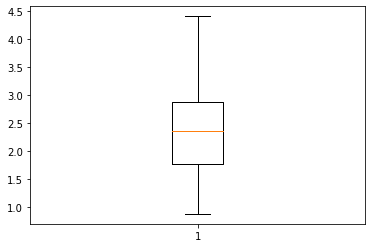

In [ ]:
plt.boxplot(collect_rmse_arx_ewnwws)
plt.show()

9973.350704193115


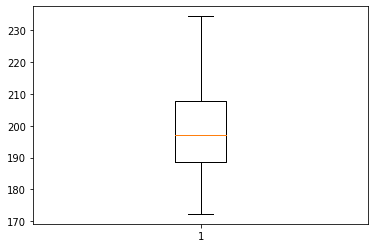

In [ ]:
print(sum(collect_runtime_arx_ewnwws))
plt.boxplot(collect_runtime_arx_ewnwws)
plt.show()

In [ ]:
print(sum(collect_runtime_arx_ewnwws))

9973.350704193115


In [ ]:
len(collect_runtime_arx_ewnwws)

50

In [ ]:
sum(collect_runtime_arx_ewnwws)/3600

2.7703751956091986

##### Compare

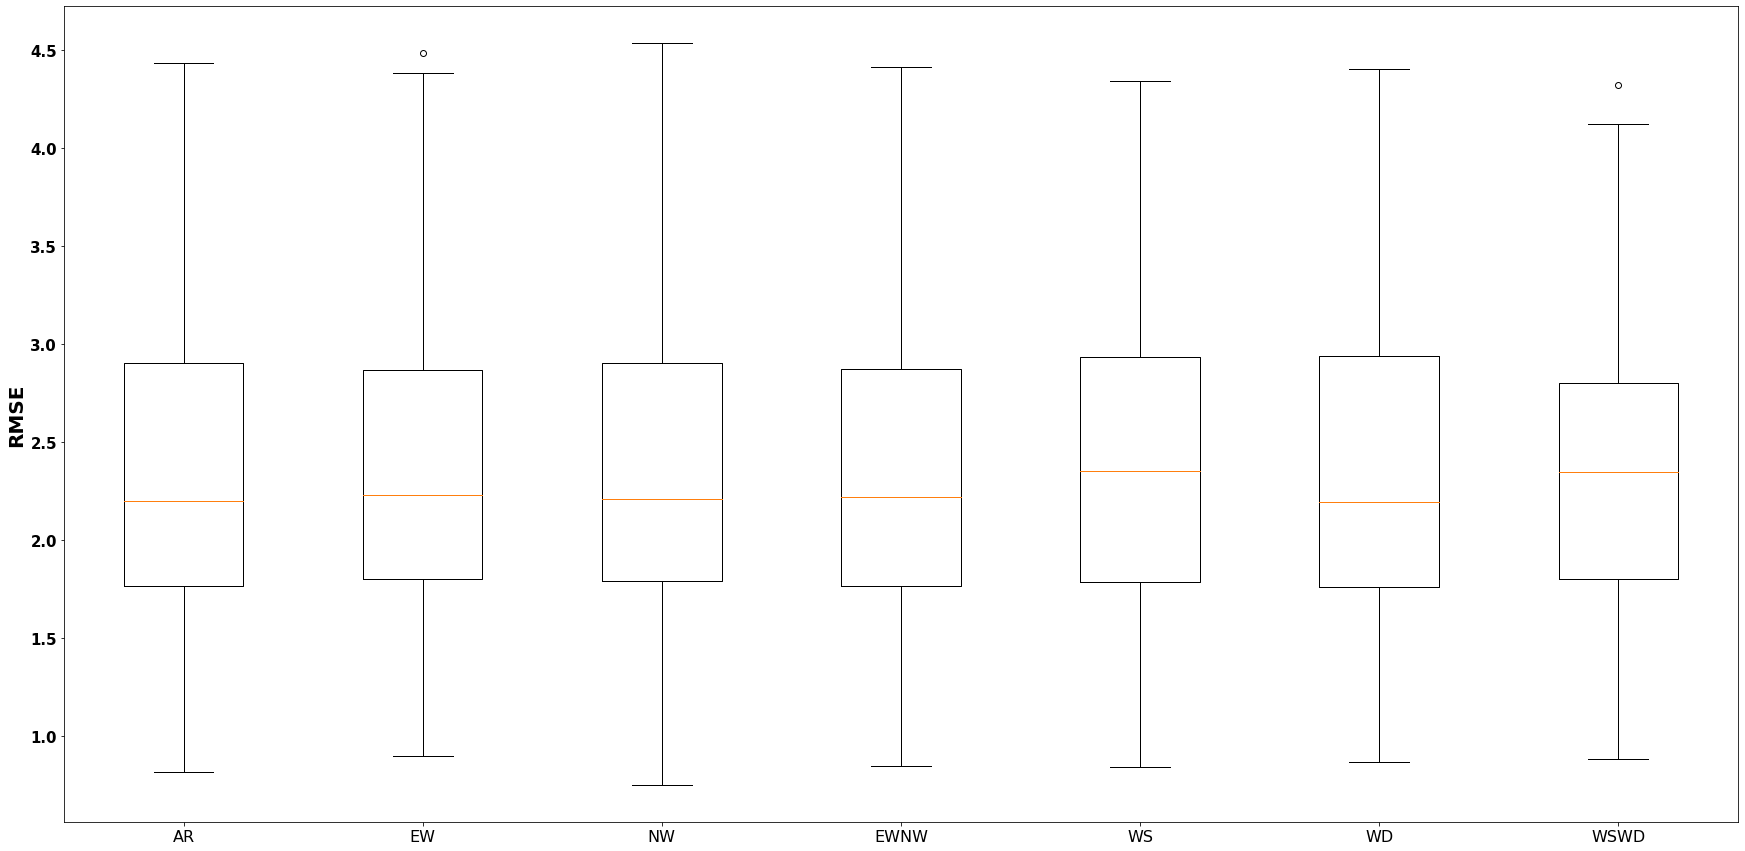

In [ ]:
wind_collection = {"AR":collect_rmse_ar_bic,"EW":collect_rmse_arx_ew,"NW":collect_rmse_arx_nw,"EWNW":collect_rmse_arx_ewnw,"WS":collect_rmse_arx_ws,"WD":collect_rmse_arx_dw,"WSWD":collect_rmse_arx_wswd}
# wind_collection = dict(sorted(wind_collection.items(), key=lambda item: np.median(item[1]),reverse=True))
wind_collection["AR"] = collect_rmse_ar_bic

runtime_collection = {"AR":collect_runtime_ar_bic,"EW":collect_runtime_arx_ew,"NW":collect_runtime_arx_nw,"WS":collect_runtime_arx_ws,"WD":collect_runtime_arx_dw,"EWNW":collect_runtime_arx_ewnw,"WSWD":collect_runtime_arx_wswd,"EWNWWS":collect_runtime_arx_ewnwws}
runtime_collection["AR"] = collect_runtime_ar_bic

# new_wind_collection = {}
# new_wind_runtime = {}
# for i in reversed(list(wind_collection.keys())):
#   new_wind_collection[i] = wind_collection[i]
#   new_wind_runtime[i] = np.average(runtime_collection[i])
# print(new_wind_collection)
tab_list = [["Model","Average RMSE","Median RMSE","Variance","Average Runtime (s)"]]
# outlier_list = [0,1,0,0,0,1,0]
for ix, i in enumerate(wind_collection):
  # print(i)
  avg = np.average(wind_collection[i])
  var = np.var(wind_collection[i])
  median = np.median(wind_collection[i])
  
  if i == "AR":
    runtime = collect_runtime_ar_bic
    tab_list.append([i,avg,median,var,np.average(runtime)])
  else:
    runtime = runtime_collection[i]
    tab_list.append(["ARX "+i,avg,median,var,np.average(runtime)])
# print(tabulate(tab_list,headers=["Model","AVG test RMSE","Median RMSE","Variance","Outlier"]))

table = Texttable()
table.set_cols_align(["c"] * 5)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(tab_list)


fig, ax = plt.subplots(figsize=(30,15))
ax.boxplot(wind_collection.values())
ax.set_xticklabels(wind_collection.keys(),fontsize=16)
ax.set_ylabel("RMSE",fontsize=20,fontweight="bold")
plt.yticks(fontsize=15,fontweight="bold")
plt.savefig("ARX_WIND_RMSE.pdf", bbox_inches="tight")
plt.show()

In [ ]:
print(latextable.draw_latex(table, caption="ARX WIND models"))

\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c|c}
			Model & Average RMSE & Median RMSE & Variance & Average Runtime (s) \\
			\hline
			AR & 2.351 & 2.199 & 0.765 & 1.268 \\
			ARX EW & 2.386 & 2.233 & 0.768 & 5.749 \\
			ARX NW & 2.347 & 2.209 & 0.743 & 7.423 \\
			ARX EWNW & 2.357 & 2.219 & 0.724 & 32.766 \\
			ARX WS & 2.375 & 2.351 & 0.756 & 5.666 \\
			ARX WD & 2.368 & 2.196 & 0.763 & 7.914 \\
			ARX WSWD & 2.395 & 2.348 & 0.754 & 39.965 \\
		\end{tabular}
	\end{center}
	\caption{ARX WIND models}
\end{table}


In [ ]:
outliers_count_wind = [0,1,0,0,0,0,1]
outlier_locat_wind = []
for ix, i in enumerate(wind_collection):
  print(i)
  outliers_locat = []
  if outliers_count_wind[ix] == 0:
    print(outliers_locat)
    continue
  outliers = sorted(np.array(wind_collection[i]))[-outliers_count_wind[ix]:]
  print(outliers)
  for j in outliers:
    outliers_locat.append(np.where(np.array(wind_collection[i])==j))
  outlier_locat_wind.append(outliers_locat)

AR
[]
EW
[4.487573994015169]
NW
[]
EWNW
[]
WS
[]
WD
[]
WSWD
[4.321766183209028]


In [ ]:
outlier_locat_wind

[[(array([35]),)], [(array([5]),)]]

TODO:
- Get direction by cos(theta)=east/WindSpeed -> theta = cos^-1(east/WindSpeed) = tan^-1(east/north)

Add a even simpler model (dummy) such as random walk, white noise, MA(q).

TODO:
- RMSE vs. distance to coastline (scatter)
- comapare baseline with random models, then AR with baseline, then determine whether a more complex model is needed


#### SPM

In [ ]:
collect_rmse_arx_spm = np.loadtxt('./Results/Model Output/ARX_SPM_RMSE.txt')
collect_runtime_arx_spm = np.loadtxt('./Results/Model Output/ARX_SPM_runtime.txt')

In [ ]:
collect_bestcfg_arx_spm = []
with open("./Results/Model Output/ARX_SPM_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_spm.append(row)
collect_bestcfg_arx_spm = np.array(collect_bestcfg_arx_spm)

In [ ]:
collect_prediction_arx_spm = []
with open('./Results/Model Output/ARX_SPM_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_spm.append(row)
collect_prediction_arx_spm = np.array(collect_prediction_arx_spm)

#### SWH

In [ ]:
collect_rmse_arx_swh = np.loadtxt('./Results/Model Output/ARX_SWH_RMSE.txt')
collect_runtime_arx_swh = np.loadtxt('./Results/Model Output/ARX_SWH_runtime.txt')

In [ ]:
collect_bestcfg_arx_swh = []
with open("./Results/Model Output/ARX_SWH_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_swh.append(row)
collect_bestcfg_arx_swh = np.array(collect_bestcfg_arx_swh)

In [ ]:
collect_prediction_arx_swh = []
with open('./Results/Model Output/ARX_SWH_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_swh.append(row)
collect_prediction_arx_swh = np.array(collect_prediction_arx_swh)

### NV

In [ ]:
collect_rmse_arx_nv = np.loadtxt('./Results/Model Output/ARX_NV_RMSE.txt')
collect_runtime_arx_nv = np.loadtxt('./Results/Model Output/ARX_NV_runtime.txt')

In [ ]:
collect_bestcfg_arx_nv = []
with open("./Results/Model Output/ARX_NV_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_arx_nv.append(row)
collect_bestcfg_arx_nv = np.array(collect_bestcfg_arx_nv)

In [ ]:
collect_prediction_arx_nv = []
with open('./Results/Model Output/ARX_NV_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_arx_nv.append(row)
collect_prediction_arx_nv = np.array(collect_prediction_arx_nv)

### 

### STWD

In [ ]:
collect_rmse_arx_stwd = np.loadtxt('./Results/Model Output/ARX_STWD_RMSE.txt')
collect_runtime_arx_stwd = np.loadtxt('./Results/Model Output/ARX_STWD_runtime.txt')

### STNW

In [ ]:
# warnings.filterwarnings("ignore")

# collect_rmse_arx_wswd = []
# collect_runtime_arx_wswd = []
# collect_bestcfg_arx_wswd = []
# collect_prediction_arx_wswd = []

# for locat in range(50):
#   start = time.time()
#   temp_CHL = north_wind_arr[locat,:]
#   temp_KD = ST_arr[locat,:]
#   temp_ZSD = ZSD_arr[locat,:]
  
#   # Grid Search the best lag_kd here, as this affects the shape of both endo and exo
#   order_chl_range = range(1,6)
#   order_kd_range = range(1,6)
#   best_score, best_X1, best_X2, best_p = float("inf"), None, None, None

#   for i in order_chl_range:
#     for k in order_kd_range:
#       x = pd.DataFrame([temp_ZSD,temp_CHL,temp_KD])
#       x = x.T
#       x.columns =["ZSD","CHL_lag0","KD_lag0"]

#       for j in range(i):
#         x[f"CHL_lag{j+1}"] = x[f"CHL_lag{j}"].shift(1)

#       for j in range(k):
#         x[f"KD_lag{j+1}"] = x[f"KD_lag{j}"].shift(1)

#       x.dropna(axis=0,how="any",inplace=True)

#       exo_col = [f"CHL_lag{x}" for x in range(1,i+1)]
#       exo_col += [f"KD_lag{x}" for x in range(1,k+1)]

      
#       # train validation split
#       train = x.iloc[:-10,:]
#       validation = train.iloc[-10:,:]
#       # Grid Search for p
#       for p in range(1,6):

#         # Prediction
#         predictions = list()
#         history = [x for x in train["ZSD"]]
#         exog_history = train[exo_col].to_numpy()

#         model = SARIMAX(history, exog=exog_history,order = (p,1,0), seasonal_order=(0,0,0,0))
#         model_fit = model.fit(disp=False)
#         if model_fit.bic < best_score:
#           best_score = model_fit.bic
#           best_X1 = i
#           best_X2 = k
#           best_p = p
#   collect_bestcfg_arx_wswd.append((best_X1,best_X2,best_p))
  

#   x = pd.DataFrame([temp_ZSD,temp_KD,temp_CHL])
#   x = x.T
#   x.columns =["ZSD","KD_lag0","CHL_lag0"]

#   for i in range(best_X1):
#     x[f"CHL_lag{i+1}"] = x[f"CHL_lag{i}"].shift(1)

#   for i in range(best_X2):
#     x[f"KD_lag{i+1}"] = x[f"KD_lag{i}"].shift(1)

#   x.dropna(axis=0,how="any",inplace=True)

#   exo_col = [f"CHL_lag{x}" for x in range(1,best_X1+1)]
#   exo_col += [f"KD_lag{x}" for x in range(1,best_X2+1)]
  
#   # train test split
#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in train["ZSD"]]
#   exog_history = train[exo_col].to_numpy()
#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape((1,-1)))
#     predictions.append(yhat)
#     history.append(test["ZSD"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy()])

#   # Result
#   end = time.time()
#   rmse = measure_rmse(test["ZSD"], predictions)
#   collect_rmse_arx_wswd.append(rmse)
#   collect_prediction_arx_wswd.append(predictions)
#   collect_runtime_arx_wswd.append(end-start)

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_STNW_pred.txt', 'w') as fp:
#     for item in collect_prediction_arx_wswd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_STNW_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_arx_wswd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_STNW_runtime.txt', 'w') as fp:
#     for item in collect_runtime_arx_wswd:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_STNW_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_arx_wswd:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_arx_stnw = np.loadtxt('./Results/Model Output/ARX_STNW_RMSE.txt')
collect_runtime_arx_stnw = np.loadtxt('./Results/Model Output/ARX_STNW_runtime.txt')

### NWWD

In [ ]:
collect_rmse_arx_nwwd = np.loadtxt('./Results/Model Output/ARX_NWWD_RMSE.txt')
collect_runtime_arx_nwwd = np.loadtxt('./Results/Model Output/ARX_NWWD_runtime.txt')

### STNV

In [ ]:
collect_rmse_arx_stnv = np.loadtxt('./Results/Model Output/ARX_STNV_RMSE.txt')
collect_runtime_arx_stnv = np.loadtxt('./Results/Model Output/ARX_STNV_runtime.txt')

### NVNW

In [ ]:
collect_rmse_arx_nvnw = np.loadtxt('./Results/Model Output/ARX_NVNW_RMSE.txt')
collect_runtime_arx_nvnw = np.loadtxt('./Results/Model Output/ARX_NVNW_runtime.txt')

### NVWD

In [ ]:
collect_rmse_arx_nvwd = np.loadtxt('./Results/Model Output/ARX_NVWD_RMSE.txt')
collect_runtime_arx_nvwd = np.loadtxt('./Results/Model Output/ARX_NVWD_runtime.txt')

### Best of Best

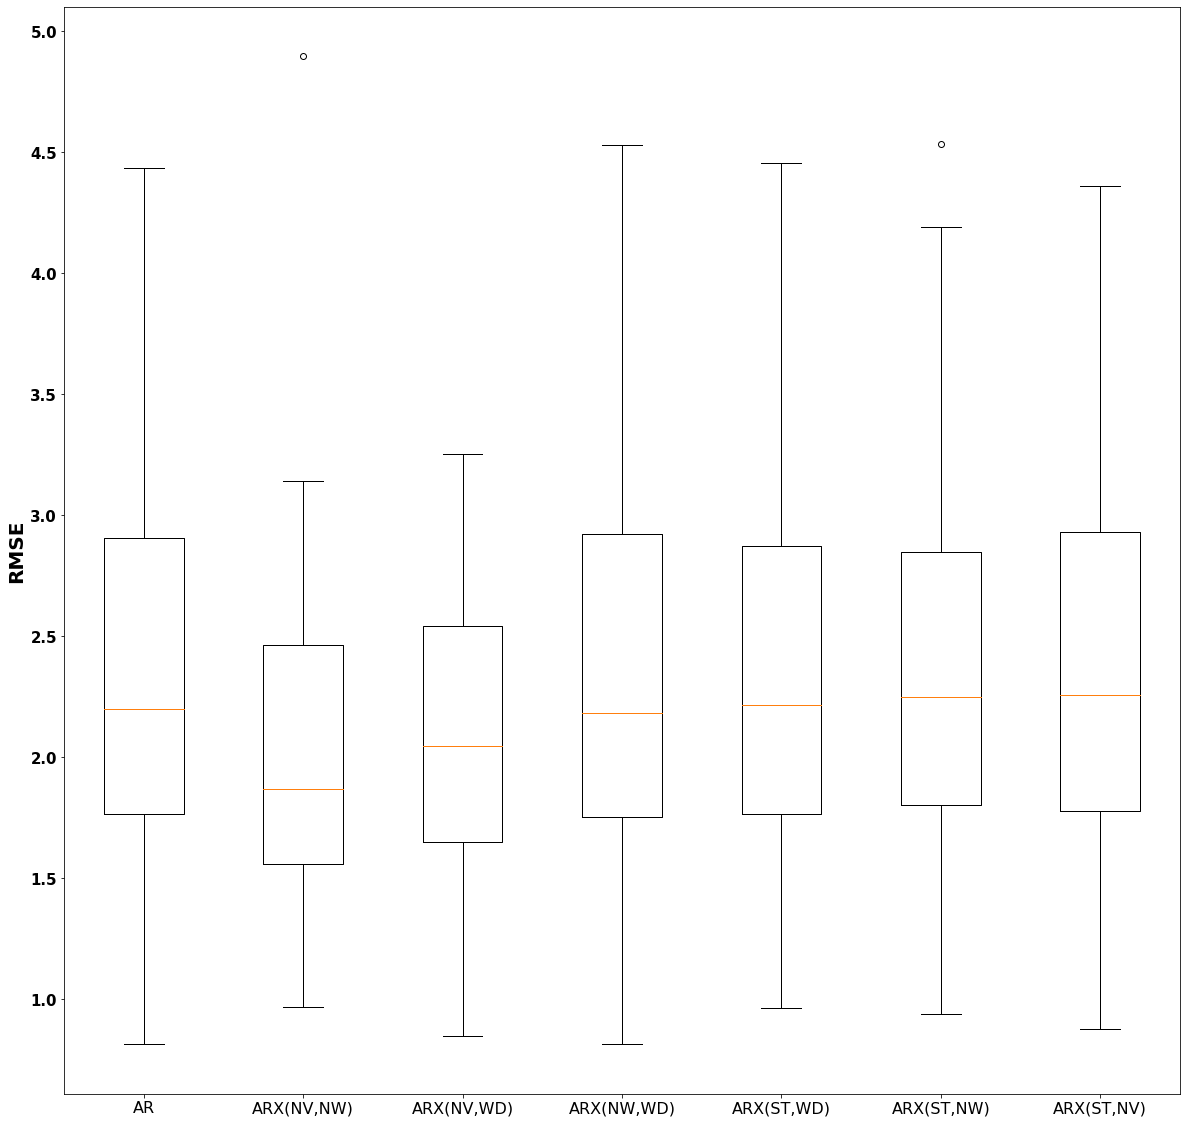

In [ ]:
best_rmse_collection = {"ARX(ST,WD)":collect_rmse_arx_stwd,"ARX(NW,WD)":collect_rmse_arx_nwwd,"ARX(ST,NW)":collect_rmse_arx_stnw,"ARX(ST,NV)":collect_rmse_arx_stnv,"ARX(NV,NW)":collect_rmse_arx_nvnw,"ARX(NV,WD)":collect_rmse_arx_nvwd}
best_rmse_collection = dict(sorted(best_rmse_collection.items(), key=lambda item: np.median(item[1]),reverse=True))
best_rmse_collection["AR"] = collect_rmse_ar_bic

new_best_collection = {}
for i in reversed(list(best_rmse_collection.keys())):
  new_best_collection[i] = best_rmse_collection[i]


tab_list = [["Model","Average RMSE","Median RMSE","Variance","Average Runtime (s)"]]
outlier_list = [0,1,0,0,0,1,0]
for ix, i in enumerate(new_best_collection):
  avg = np.average(new_best_collection[i])
  var = np.var(new_best_collection[i])
  median = np.median(new_best_collection[i])
  
  if i == "AR":
    runtime = collect_runtime_ar_bic
    tab_list.append([i,avg,median,var,np.average(runtime)])
  else:
    name = i.lower().replace(",","").replace("arx(","").replace(")","")
    runtime = eval(f"collect_runtime_arx_{name}")
    tab_list.append(["ARX "+i,avg,median,var,np.average(runtime)])
# print(tabulate(tab_list,headers=["Model","AVG test RMSE","Median RMSE","Variance","Outlier"]))

table = Texttable()
table.set_cols_align(["c"] * 5)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(tab_list)

fig, ax = plt.subplots(figsize=(20,20))
ax.boxplot(new_best_collection.values())
ax.set_xticklabels(new_best_collection.keys(),fontsize=16)
ax.set_ylabel("RMSE",fontsize=20,fontweight="bold")
plt.yticks(fontsize=15,fontweight="bold")
plt.savefig("ARX_BOB_RMSE.pdf", bbox_inches="tight")
plt.show()

In [ ]:
print(latextable.draw_latex(table, caption="best of best models"))

\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c|c}
			Model & Average RMSE & Median RMSE & Variance & Average Runtime (s) \\
			\hline
			AR & 2.351 & 2.199 & 0.765 & 1.268 \\
			ARX ARX(NV,NW) & 2.004 & 1.869 & 0.483 & 57.056 \\
			ARX ARX(NV,WD) & 2.033 & 2.045 & 0.409 & 60.869 \\
			ARX ARX(NW,WD) & 2.341 & 2.183 & 0.735 & 47.138 \\
			ARX ARX(ST,WD) & 2.372 & 2.216 & 0.723 & 57.402 \\
			ARX ARX(ST,NW) & 2.357 & 2.249 & 0.692 & 66.738 \\
			ARX ARX(ST,NV) & 2.372 & 2.256 & 0.714 & 106.396 \\
		\end{tabular}
	\end{center}
	\caption{best of best models}
\end{table}


In [ ]:
outliers_rf = sorted(collect_rmse_arx_stnw)[-1:]
outliers_locat_rf = []
for i in outliers_rf:
  outliers_locat_rf.append(np.where(collect_rmse_arx_stnw==i))

In [ ]:
outliers_locat_rf

[(array([48]),)]

### Neighbourhood

In [ ]:
sampled_zsd.shape

(50, 250, 3, 3)

Check if any is nan

In [ ]:
sampled_zsd[np.isnan(sampled_zsd)].shape

(1000,)

In [ ]:
loc_nan = np.argwhere(np.isnan(sampled_zsd))
idx_nan = set([x[0] for x in loc_nan])

27th location has nan at

In [ ]:
for i in idx_nan:
  all_27 = [[x[0],x[2],x[3]] for x in loc_nan if x[0]==i]
  unique_data = [list(x) for x in set(tuple(x) for x in all_27)]
  print(unique_data)

[[40, 2, 0]]
[[27, 0, 2], [27, 1, 2]]
[[44, 1, 2]]


In [ ]:
sampled_lat[40], sampled_lon[40]

(344, 933)

In [ ]:
medi_zsd.shape

(250, 601, 1247)

In [ ]:
sampled_zsd[40,:,2,0] = medi_zsd[:,344-2,933-1]

In [ ]:
sampled_zsd[27,:,0,2] = medi_zsd[:,sampled_lat[27]+2,sampled_lon[27]+1]
sampled_zsd[27,:,1,2] = medi_zsd[:,sampled_lat[27]+3,sampled_lon[27]+1]

In [ ]:
sampled_zsd[44,:,1,2]  = medi_zsd[:,sampled_lat[44]+2,sampled_lon[44]+1]

In [ ]:
loc_nan = np.argwhere(np.isnan(sampled_zsd))
idx_nan = set([x[0] for x in loc_nan])
for i in idx_nan:
  all_27 = [[x[0],x[2],x[3]] for x in loc_nan if x[0]==i]
  unique_data = [list(x) for x in set(tuple(x) for x in all_27)]
  print(unique_data)

In [ ]:
colnames = ["TL","T","TR","ML","C","MR","BL","B","BR"]
for locat in range(50):
  temp_center = sampled_zsd[locat]

  x = []
  for i in range(3):
    for j in range(3):
      x.append(temp_center[:,i,j])
  x = pd.DataFrame(x)
  x = x.T
  x.columns = [x+"0" if x!="C" else x for x in colnames]

In [ ]:
# warnings.filterwarnings("ignore")

# lag_zsd = 3
# range_lag_nei = range(1,6)
# collect_bestcfg_neigh = []
# collect_rmse_neigh = []
# collect_prediction_neigh = []
# collect_runtime_neigh = []

# colnames = ["TL","T","TR","ML","C","MR","BL","B","BR"]

# for locat in tqdm(range(50)):
#   print(locat)
#   start = time.time()
#   temp_center = sampled_zsd[locat]

#   best_score, best_X, best_p = float("inf"), None, None

#     # train test split
#   train = temp_center[:-10,:,:]
#   test = temp_center[-10:,:,:]


#   for n in range_lag_nei:
    
#     exo_col = []

#     x = []
#     for i in range(3):
#       for j in range(3):
#         x.append(train[:,i,j])
#     x = pd.DataFrame(x)
#     x = x.T
#     x.columns = [x+"0" if x!="C" else x for x in colnames]

#     # create shifted neighbours
#     for nei in colnames:
#       if nei!="C":
#         for i in range(n):
#           x[f"{nei}{i+1}"] = x[f"{nei}{i}"].shift(1)
#           exo_col.append(f"{nei}{i+1}")

#     x.dropna(axis=0,how="any",inplace=True)

#     x.drop([x+"0" for x in colnames if x!="C"],axis=1,inplace=True)

#     # print(x)
#     # print(exo_col)
#     # Grid Search for p
#     for k in range(1,6):

#       # Prediction
#       predictions = list()

#       history = [row for row in x["C"]]
#       exog_history = x[exo_col].to_numpy()

#       # print(len(history))
#       # print(exog_history.shape)

#       model = SARIMAX(history, exog=exog_history,order = (k,1,0), seasonal_order=(0,0,0,0))
#       model_fit = model.fit(disp=False)
#       if model_fit.bic < best_score:
#         best_score = model_fit.bic
#         best_X = n
#         best_p = k
#   collect_bestcfg_neigh.append((best_X,best_p))
  
#   x = []
#   exo_col = []
#   for i in range(3):
#     for j in range(3):
#       x.append(temp_center[:,i,j])
#   x = pd.DataFrame(x)
#   x = x.T
#   x.columns = [x+"0" if x!="C" else x for x in colnames]

#   # create shifted neighbours
#   for nei in colnames:
#     if nei!="C":
#       for i in range(best_X):
#         x[f"{nei}{i+1}"] = x[f"{nei}{i}"].shift(1)
#         exo_col.append(f"{nei}{i+1}")
#   x.dropna(axis=0,how="any",inplace=True)
#   x.drop([x+"0" for x in colnames if x!="C"],axis=1,inplace=True)

#   train = x.iloc[:-10,:]
#   test = x.iloc[-10:,:]

#   # Prediction
#   predictions = list()

#   history = [x for x in x["C"]]
#   exog_history = x[exo_col].to_numpy()

#   # print(exog_history.shape)

#   for t in range(len(test)):
#     model = SARIMAX(history, exog=exog_history, order = (best_p,1,0), seasonal_order=(0,0,0,0))
#     model_fit = model.fit(disp=False)
#     yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape(1,-1))
#     predictions.append(yhat)
#     history.append(test["C"].iloc[t])
#     # print(test[exo_col].iloc[t,:].shape)
#     exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy().reshape(1,-1)])

#   # Result
#   rmse = sqrt(mean_squared_error(test["C"], predictions))
#   collect_rmse_neigh.append(rmse)
#   collect_prediction_neigh.append(predictions)
#   collect_runtime_neigh.append(time.time() - start)

In [ ]:
# # print(locat)
# # start = time.time()
# locat=0
# temp_center = sampled_zsd[locat]

# best_score, best_X, best_p = float("inf"), 5, 5

#   # train test split
# train = temp_center[:-10,:,:]
# test = temp_center[-10:,:,:]
# x = []
# exo_col = []
# for i in range(3):
#   for j in range(3):
#     x.append(temp_center[:,i,j])
# x = pd.DataFrame(x)
# x = x.T
# x.columns = [x+"0" if x!="C" else x for x in colnames]

# # create shifted neighbours
# for nei in colnames:
#   if nei!="C":
#     for i in range(best_X):
#       x[f"{nei}{i+1}"] = x[f"{nei}{i}"].shift(1)
#       exo_col.append(f"{nei}{i+1}")
# x.dropna(axis=0,how="any",inplace=True)
# x.drop([x+"0" for x in colnames if x!="C"],axis=1,inplace=True)

# train = x.iloc[:-10,:]
# test = x.iloc[-10:,:]

# # Prediction
# predictions = list()

# history = [x for x in x["C"]]
# exog_history = x[exo_col].to_numpy()

# # print(exog_history.shape)




# for t in tqdm(range(len(test))):
#   model = ARIMA(history,exog=exog_history, order=(best_p,1,0))
#   model_fit = model.fit(disp=False)
#   yhat = model_fit.forecast(exog=test[exo_col].iloc[t,:].to_numpy().reshape(1,-1))
#   predictions.append(yhat)
#   history.append(test["C"].iloc[t])
#   # print(test[exo_col].iloc[t,:].shape)
#   exog_history = np.vstack([exog_history,test[exo_col].iloc[t,:].to_numpy().reshape(1,-1)])

In [ ]:
# # open file in write mode
# with open(r'./Results/Model Output/ARX_neigh_pred.txt', 'w') as fp:
#     for item in collect_prediction_neigh:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_neigh_RMSE.txt', 'w') as fp:
#     for item in collect_rmse_neigh:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_neigh_runtime.txt', 'w') as fp:
#     for item in collect_runtime_neigh:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# # open file in write mode
# with open(r'./Results/Model Output/ARX_neigh_cfg.txt', 'w') as fp:
#     for item in collect_bestcfg_neigh:
#         # write each item on a new line
#         fp.write(f"{item[0],item[1]}\n")

In [ ]:
collect_rmse_neigh = np.loadtxt('./Results/Model Output/ARX_neigh_RMSE.txt')
collect_runtime_neigh = np.loadtxt('./Results/Model Output/ARX_neigh_runtime.txt')

In [ ]:
collect_bestcfg_neigh = []
with open("./Results/Model Output/ARX_neigh_cfg.txt") as file:
    for line in file:
      x = line.rstrip()
      temp = x.replace("(","").replace(")","").split(",")
      row = []
      for num in temp:
        row.append(float(num))
      collect_bestcfg_neigh.append(row)
collect_bestcfg_neigh = np.array(collect_bestcfg_neigh)

In [ ]:
collect_prediction_neigh = []
with open('./Results/Model Output/ARX_neigh_pred.txt') as file:
    for line in file:
        x = line.rstrip()
        temp = x.replace("[","").replace("]","").split(",")
        row = []
        for num in temp:
          row.append(eval("np."+num))
        collect_prediction_neigh.append(row)
collect_prediction_neigh = np.array(collect_prediction_neigh)

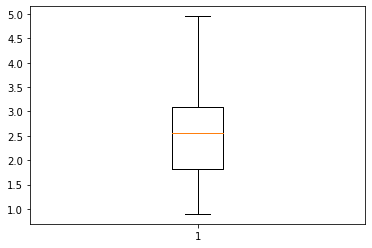

In [ ]:
plt.boxplot(collect_rmse_neigh)
plt.show()

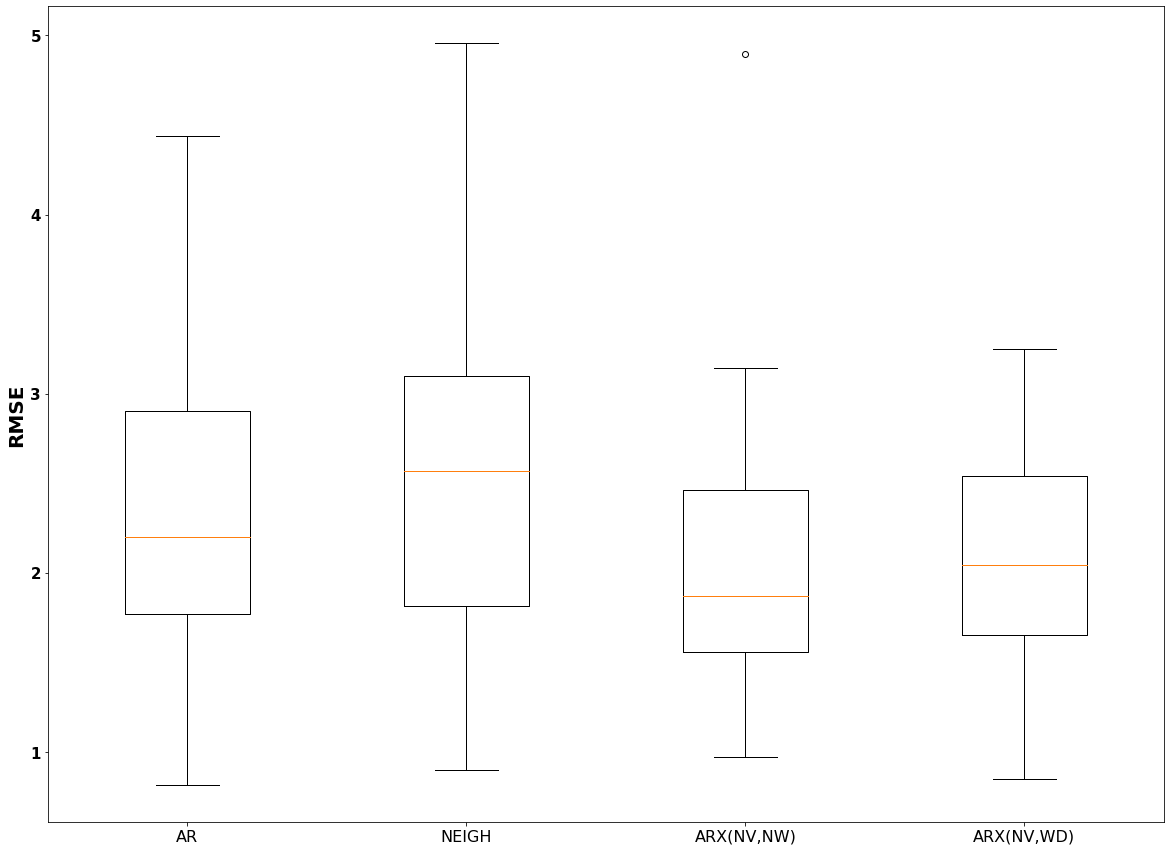

In [ ]:
neigh_collection = {"AR":collect_rmse_ar_bic,"NEIGH":collect_rmse_neigh,"ARX(NV,NW)":collect_rmse_arx_nvnw,"ARX(NV,WD)":collect_rmse_arx_nvwd}
# best_rmse_collection = dict(sorted(best_rmse_collection.items(), key=lambda item: np.median(item[1]),reverse=True))
# best_rmse_collection["AR"] = collect_rmse_ar_bic

# new_best_collection = {}
# for i in reversed(list(best_rmse_collection.keys())):
#   new_best_collection[i] = best_rmse_collection[i]


tab_list = [["Model","Average RMSE","Median RMSE","Variance","Average Runtime (s)"]]
outlier_list = [0,1,0,0,0,1,0]
for ix, i in enumerate(neigh_collection):
  avg = np.average(neigh_collection[i])
  var = np.var(neigh_collection[i])
  median = np.median(neigh_collection[i])
  
  if i == "AR":
    runtime = collect_runtime_ar_bic
    tab_list.append([i,avg,median,var,np.average(runtime)])
  elif i =="NEIGH":
    runtime = collect_runtime_neigh
    tab_list.append([i,avg,median,var,np.average(runtime)])
  else:
    name = i.lower().replace("arx(","").replace(")","").replace(",","")
    runtime = eval(f"collect_runtime_arx_{name}")
    tab_list.append(["ARX "+i,avg,median,var,np.average(runtime)])
# print(tabulate(tab_list,headers=["Model","AVG test RMSE","Median RMSE","Variance","Outlier"]))

table = Texttable()
table.set_cols_align(["c"] * 5)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(tab_list)

fig, ax = plt.subplots(figsize=(20,15))
ax.boxplot(neigh_collection.values())
ax.set_xticklabels(neigh_collection.keys(),fontsize=16)
ax.set_ylabel("RMSE",fontsize=20,fontweight="bold")
plt.yticks(fontsize=15,fontweight="bold")
plt.savefig("ARX_neigh.pdf", bbox_inches="tight")
plt.show()

In [ ]:
print(latextable.draw_latex(table, caption="neighbourhood and best of best"))

\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c|c}
			Model & Average RMSE & Median RMSE & Variance & Average Runtime (s) \\
			\hline
			AR & 2.351 & 2.199 & 0.765 & 1.268 \\
			NEIGH & 2.571 & 2.568 & 0.768 & 64.929 \\
			ARX NVNW & 2.004 & 1.869 & 0.483 & 57.056 \\
			ARX NVWD & 2.033 & 2.045 & 0.409 & 60.869 \\
		\end{tabular}
	\end{center}
	\caption{neighbourhood and best of best}
\end{table}


In [ ]:
collect_rmse_arx_nvnw.argmax()

35

## Non-linear model

In [ ]:
sampled_zsd.shape

(50, 250, 3, 3)

In [ ]:
list_of_var = ["ZSD","KD","CHL","ST","SPM","east_wind","north_wind","wind","direction_wind","neigh"]
colnames = ["TL","T","TR","ML","C","MR","BL","B","BR"]
total_col = list_of_var + colnames

In [ ]:
sampled_distance[0]

0.9510585431063759

In [ ]:
latitude[sampled_lat[0]]

40.9375

In [ ]:

warnings.filterwarnings("ignore")

list_of_var = ["ZSD","KD","CHL","ST","SPM","east_wind","north_wind","wind","direction_wind"]
colnames = ["TL","T","TR","ML","C","MR","BL","B","BR"]
total_col = list_of_var + colnames
train_df = pd.DataFrame([])
test_df = pd.DataFrame([])

for locat in range(50):

  temp_x = pd.DataFrame([])

  irrelevant_col = []

  for i in list_of_var:
    temp_arr = eval(f"{i}_arr[locat,:]")
    temp_x[f"{i}_lag0"] = temp_arr
    if i != "ZSD":
      irrelevant_col.append(f"{i}_lag0")

  temp_center = sampled_zsd[locat]

  ix = 0
  for i in range(3):
    for j in range(3):
      if ix != 4:
        temp_x[f"{colnames[ix]}_lag0"] = temp_center[:,i,j]
        irrelevant_col.append(f"{colnames[ix]}_lag0")
      ix+=1

      

  for i in range(5):
    for j in total_col:
      if j != "C":
        temp_x[f"{j}_lag{i+1}"] = temp_x[f"{j}_lag{i}"].shift(1)

  temp_x.dropna(axis=0,how="any",inplace=True)

  temp_x.drop(columns = irrelevant_col,inplace=True)

  temp_x["distance"] = sampled_distance[locat]
  temp_x["lat"] = latitude[sampled_lat[locat]]
  temp_x["lon"] = longitude[sampled_lon[locat]]
  
  # train test split
  train = temp_x.iloc[:-10,:]
  test = temp_x.iloc[-10:,:]

  train_df = pd.concat([train_df, train])
  test_df = pd.concat([test_df, test])

In [ ]:
train_df.shape

(11750, 89)

In [ ]:
test_df.shape

(500, 89)

TODO:

- Add distance to coastline
- or even lattitude and longitude directly
- Add location information (neighbourhood)

In [ ]:
train_df.head()

ZSD_lag0   ZSD_lag1   KD_lag1  CHL_lag1    ST_lag1  SPM_lag1  \
5  32.064201  32.582745  0.031092  0.082672  25.299988  0.404682   
6  28.577204  32.064201  0.031444  0.085682  25.739990  0.348628   
7  27.037949  28.577204  0.034177  0.110200  25.299988  0.297128   
8  29.796665  27.037949  0.035626  0.123995  25.299988  0.230868   
9  30.971203  29.796665  0.033143  0.100683  25.480011  0.182494   

   east_wind_lag1  north_wind_lag1  wind_lag1  direction_wind_lag1  ...  \
5            8.00            -5.09   9.481988             0.566648  ...   
6            4.72            -3.08   5.636027             0.578160  ...   
7           -0.43             1.32   1.388272             1.885713  ...   
8           -1.57             2.38   2.851193             2.153935  ...   
9            3.63            -1.02   3.770584             0.273928  ...   

      T_lag5    TR_lag5    ML_lag5    MR_lag5    BL_lag5     B_lag5  \
5  32.850426  33.853600  33.707607  33.773643  33.888069  33.736794   
6  32.729710  32.685307  32.530205  32.341511  31.312275  31.094479   
7  31.942835  31.711704  32.492203  32.096378  32.142628  32.212738   
8  35.752762  35.757130  33.224159  34.934155  34.957695  34.959743   
9  32.310246  32.350842  32.709824  32.537708  32.847618  32.642365   

     BR_lag5  distance      lat        lon  
5  33.565876  0.951059  40.9375  11.770839  
6  31.954315  0.951059  40.9375  11.770839  
7  32.183311  0.951059  40.9375  11.770839  
8  35.025669  0.951059  40.9375  11.770839  
9  32.479733  0.951059  40.9375  11.770839  

[5 rows x 89 columns]

In [ ]:
X_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,0]
X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]

In [ ]:
train_df.columns

Index(['ZSD_lag0', 'ZSD_lag1', 'KD_lag1', 'CHL_lag1', 'ST_lag1', 'SPM_lag1',
       'east_wind_lag1', 'north_wind_lag1', 'wind_lag1', 'direction_wind_lag1',
       'TL_lag1', 'T_lag1', 'TR_lag1', 'ML_lag1', 'MR_lag1', 'BL_lag1',
       'B_lag1', 'BR_lag1', 'ZSD_lag2', 'KD_lag2', 'CHL_lag2', 'ST_lag2',
       'SPM_lag2', 'east_wind_lag2', 'north_wind_lag2', 'wind_lag2',
       'direction_wind_lag2', 'TL_lag2', 'T_lag2', 'TR_lag2', 'ML_lag2',
       'MR_lag2', 'BL_lag2', 'B_lag2', 'BR_lag2', 'ZSD_lag3', 'KD_lag3',
       'CHL_lag3', 'ST_lag3', 'SPM_lag3', 'east_wind_lag3', 'north_wind_lag3',
       'wind_lag3', 'direction_wind_lag3', 'TL_lag3', 'T_lag3', 'TR_lag3',
       'ML_lag3', 'MR_lag3', 'BL_lag3', 'B_lag3', 'BR_lag3', 'ZSD_lag4',
       'KD_lag4', 'CHL_lag4', 'ST_lag4', 'SPM_lag4', 'east_wind_lag4',
       'north_wind_lag4', 'wind_lag4', 'direction_wind_lag4', 'TL_lag4',
       'T_lag4', 'TR_lag4', 'ML_lag4', 'MR_lag4', 'BL_lag4', 'B_lag4',
       'BR_lag4', 'ZSD_lag5', 'KD_lag5',

### Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# regr = RandomForestRegressor(max_depth=2, random_state=0)
# regr.fit(X_train, y_train)
# pred = regr.predict(X_test)

In [ ]:
# measure_rmse(y_test,pred)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#               #  'min_samples_split': min_samples_split,
#               #  'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [ ]:
# n_estimators

TODO:
- n_estimators
- max_depth

In [ ]:
# # from sklearn.model_selection import RandomizedSearchCV

# # # Number of trees in random forest
# # n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # # Number of features to consider at every split
# # max_features = ['auto', 'sqrt']
# # # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# # max_depth.append(None)
# # # Minimum number of samples required to split a node
# # min_samples_split = [2, 5, 10]
# # # Minimum number of samples required at each leaf node
# # min_samples_leaf = [1, 2, 4]
# # # Method of selecting samples for training each tree
# # bootstrap = [True, False]
# # # Create the random grid
# # random_grid = {'n_estimators': n_estimators,
# #                'max_features': max_features,
# #                'max_depth': max_depth,
# #                'min_samples_split': min_samples_split,
# #                'min_samples_leaf': min_samples_leaf,
# #                'bootstrap': bootstrap}

# start_time = time.time()
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [ ]:
# best_random = rf_random.best_estimator_

# predictions = best_random.predict(X_test)
# elapsed_time = time.time() - start_time
# pickle.dump(elapsed_time,open("runtime_randomForest","wb"))
# # open file in write mode
# with open(r'./Results/Model Output/RF_pred.txt', 'w') as fp:
#     for item in predictions:
#         # write each item on a new line
#         fp.write("%s\n" % item)

# filename = 'best_random.sav'
# pickle.dump(best_random, open(filename, 'wb'))

# print(measure_rmse(y_test,predictions))

In [ ]:
# predictions = np.loadtxt("./Results/Model Output/RF_pred.txt")

In [ ]:
# load the model from disk
best_random = pickle.load(open("best_random.sav", 'rb'))

In [ ]:
predictions = best_random.predict(X_test)
print(measure_rmse(y_test.to_numpy().reshape((50,10)),predictions.reshape((50,10))))

2.2727826832975806


In [ ]:
predictions.shape

(500,)

In [ ]:
y_test.shape

(500,)

In [ ]:
residual = y_test.to_numpy().reshape((50,10)) - predictions.reshape((50,10))
se = residual**2
mse = se.mean(axis=1)
collect_rmse_rf = np.sqrt(mse)

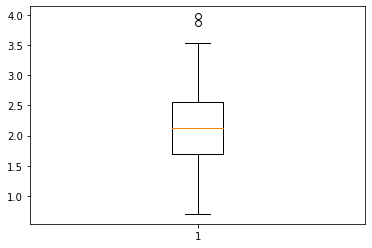

In [ ]:
plt.boxplot(collect_rmse_rf)
plt.show()

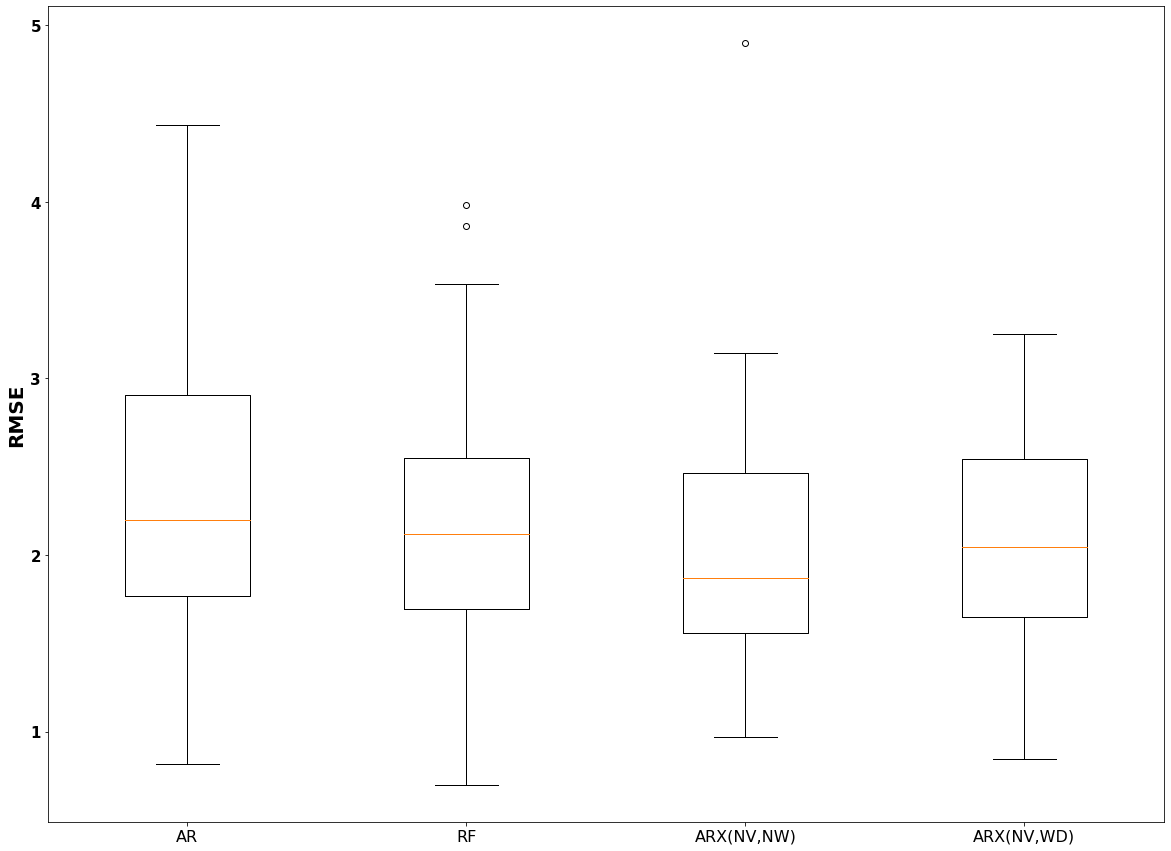

In [ ]:
neigh_collection = {"AR":collect_rmse_ar_bic,"RF":collect_rmse_rf,"ARX(NV,NW)":collect_rmse_arx_nvnw,"ARX(NV,WD)":collect_rmse_arx_nvwd}
# best_rmse_collection = dict(sorted(best_rmse_collection.items(), key=lambda item: np.median(item[1]),reverse=True))
# best_rmse_collection["AR"] = collect_rmse_ar_bic

# new_best_collection = {}
# for i in reversed(list(best_rmse_collection.keys())):
#   new_best_collection[i] = best_rmse_collection[i]


tab_list = [["Model","Average RMSE","Median RMSE","Variance","Average Runtime (s)"]]
outlier_list = [0,1,0,0,0,1,0]
for ix, i in enumerate(neigh_collection):
  avg = np.average(neigh_collection[i])
  var = np.var(neigh_collection[i])
  median = np.median(neigh_collection[i])
  
  if i == "AR":
    runtime = collect_runtime_ar_bic
    tab_list.append([i,avg,median,var,np.average(runtime)])
  elif i =="RF":
    runtime = 8387.396/50
    tab_list.append([i,avg,median,var,runtime])
  else:
    name = i.lower().replace(",","").replace("arx(","").replace(")","")
    runtime = eval(f"collect_runtime_arx_{name}")
    tab_list.append(["ARX "+i,avg,median,var,np.average(runtime)])
# print(tabulate(tab_list,headers=["Model","AVG test RMSE","Median RMSE","Variance","Outlier"]))

table = Texttable()
table.set_cols_align(["c"] * 5)
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(tab_list)

fig, ax = plt.subplots(figsize=(20,15))
ax.boxplot(neigh_collection.values())
ax.set_xticklabels(neigh_collection.keys(),fontsize=16)
ax.set_ylabel("RMSE",fontsize=20,fontweight="bold")
plt.yticks(fontsize=15,fontweight="bold")
plt.savefig("ARX_RF_RMSE.pdf", bbox_inches="tight")
plt.show()

In [ ]:
print(latextable.draw_latex(table, caption="Non-linear model V.S. AR and BOB models"))

\begin{table}
	\begin{center}
		\begin{tabular}{c|c|c|c|c}
			Model & Average RMSE & Median RMSE & Variance & Average Runtime (s) \\
			\hline
			AR & 2.351 & 2.199 & 0.765 & 1.268 \\
			RF & 2.162 & 2.121 & 0.491 & 167.748 \\
			ARX NVNW & 2.004 & 1.869 & 0.483 & 57.056 \\
			ARX NVWD & 2.033 & 2.045 & 0.409 & 60.869 \\
		\end{tabular}
	\end{center}
	\caption{Non-linear model V.S. AR and BOB models}
\end{table}


In [ ]:
outliers_rf = sorted(collect_rmse_rf)[-2:]
outliers_locat_rf = []
for i in outliers_rf:
  outliers_locat_rf.append(np.where(collect_rmse_rf==i))

In [ ]:
outliers_locat_rf

[(array([5]),), (array([48]),)]

In [ ]:
start_time = time.time()
result = permutation_importance(
    best_random, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 535.115 seconds


In [ ]:
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)
forest_std = pd.Series(result.importances_std, index=X_test.columns)

In [ ]:
sorted_importance = forest_importances.sort_values(ascending=False)
sorted_std = forest_std[sorted_importance.index]

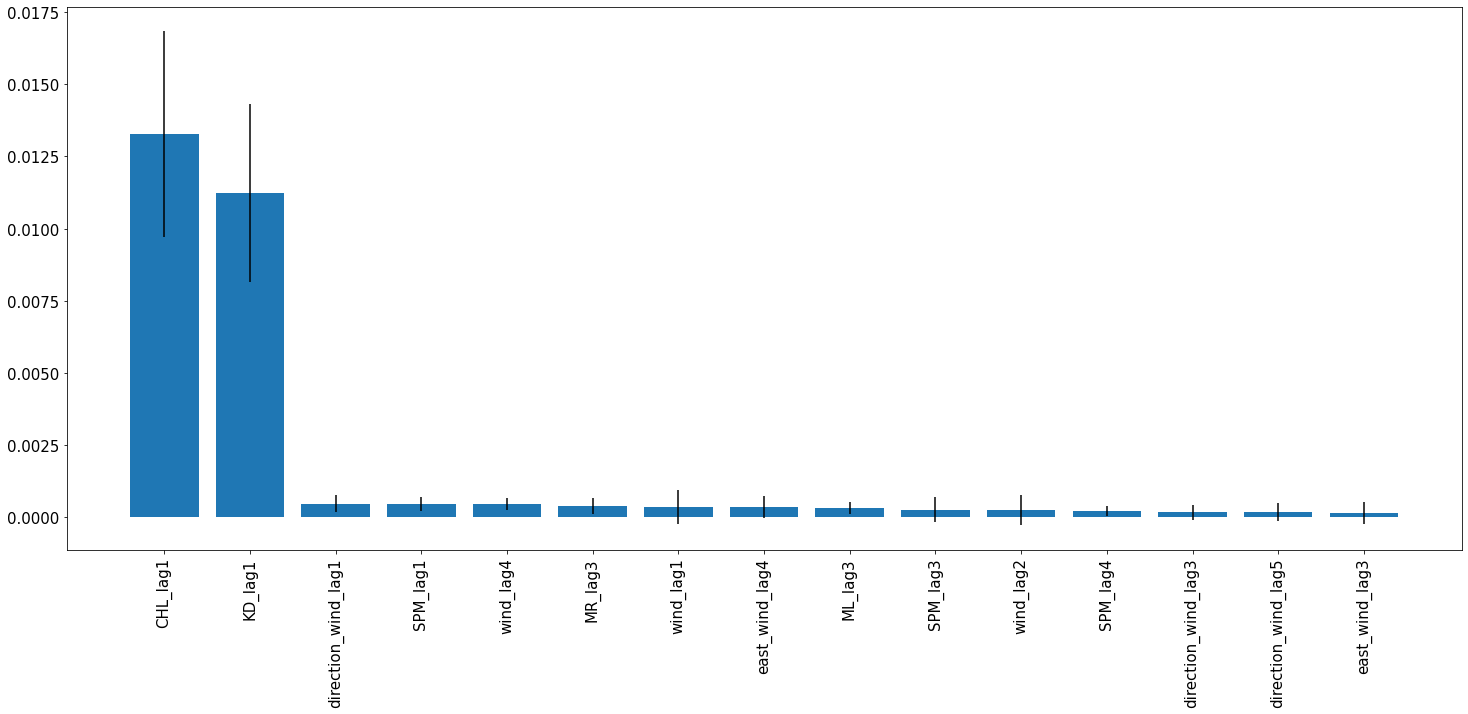

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
plt.bar(sorted_importance.index[:15],sorted_importance.values[:15], yerr=sorted_std[:15])
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("top15MostImportantFeature.pdf")
plt.show()

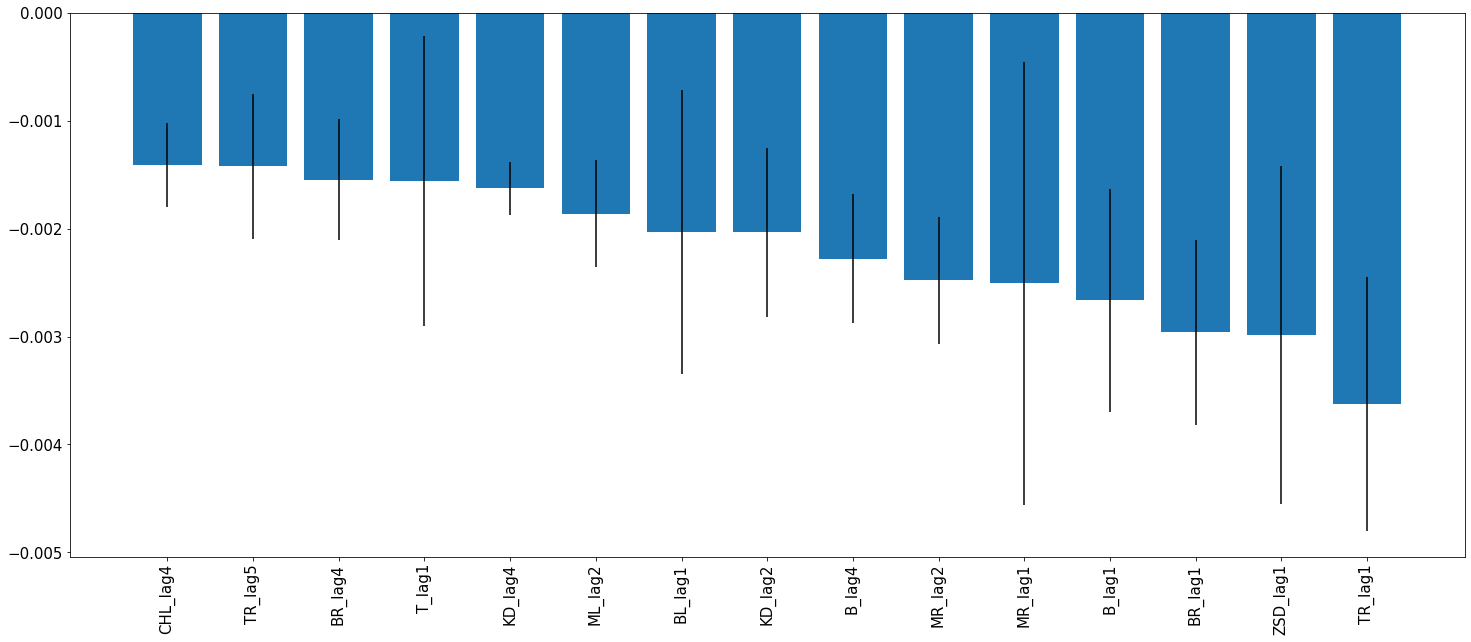

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
plt.bar(sorted_importance.index[-15:],sorted_importance.values[-15:], yerr=sorted_std[-15:])
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("worst15features.pdf")
plt.show()

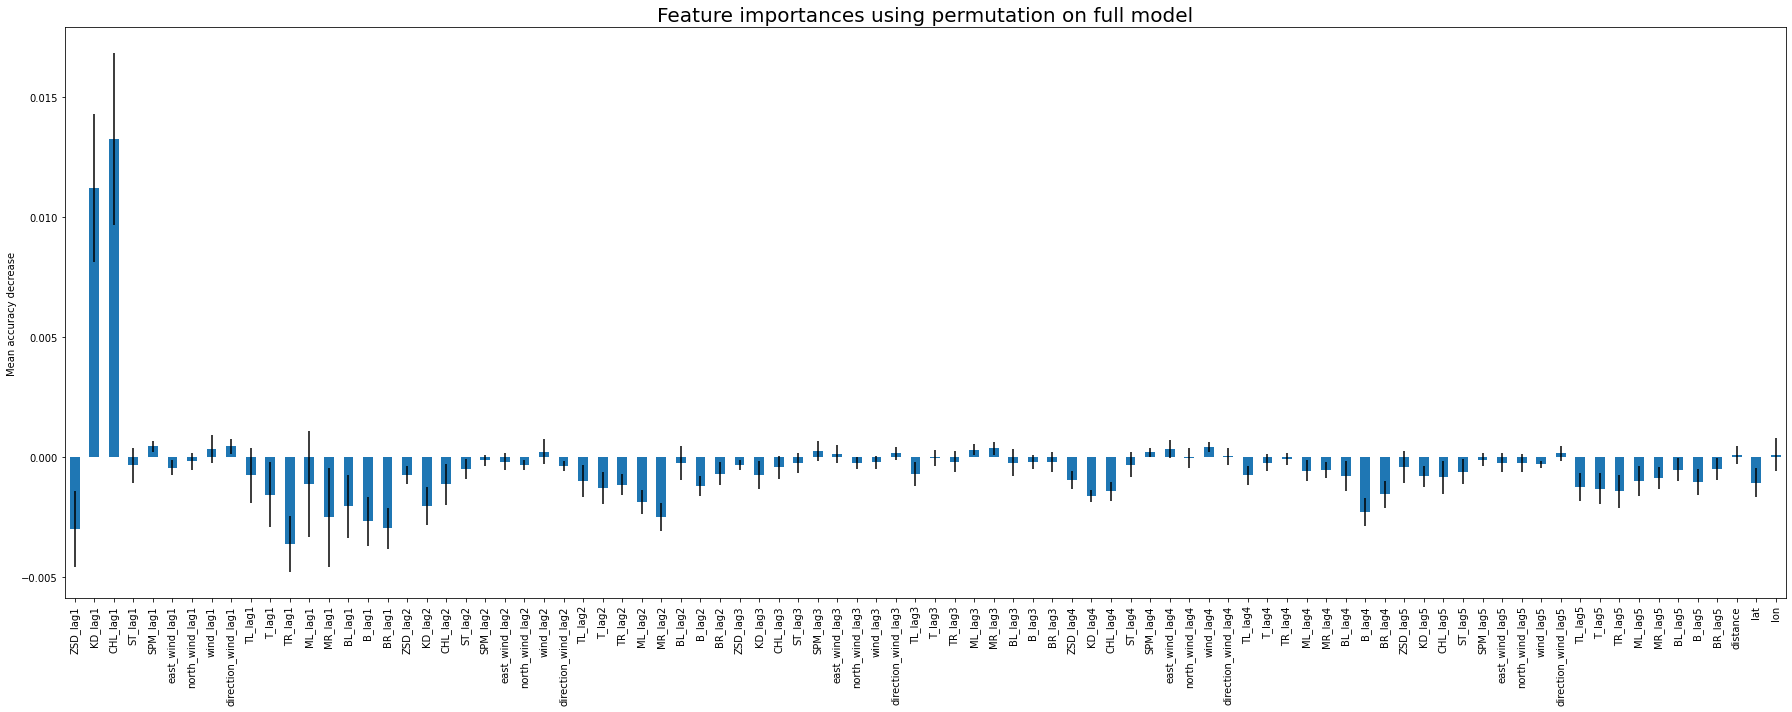

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model",fontsize=20)
ax.set_ylabel("Mean accuracy decrease",fontsize=10)
fig.tight_layout()
plt.savefig("feature_importance.pdf")
plt.show()

In [ ]:
estimator = best_random.estimators_[5]

In [ ]:
best_random.estimators_

[DecisionTreeRegressor(max_depth=60, max_features='sqrt', random_state=524160415),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt',
                       random_state=1403181508),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt',
                       random_state=1792010945),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt', random_state=274016661),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt',
                       random_state=1579915241),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt',
                       random_state=1522735994),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt',
                       random_state=1178764848),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt',
                       random_state=1021145752),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt', random_state=166808507),
 DecisionTreeRegressor(max_depth=60, max_features='sqrt',
                       random_state=1495376112),
 D

In [ ]:
y_train.name

'ZSD_lag0'

In [ ]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = y_train.name,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

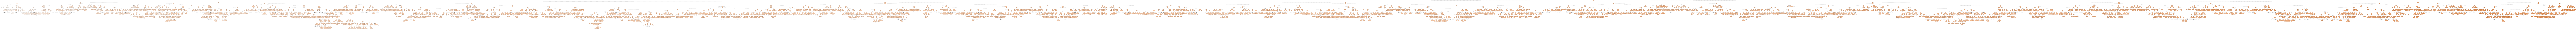

In [ ]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

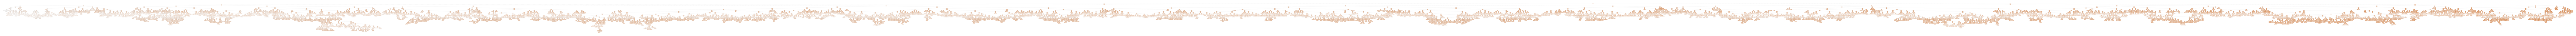

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(100,100))

img = mpimg.imread('tree.png')
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

# Forecaste Difficulty with Distance

In [ ]:
# 21 plots
all_rmse = {"Baseline":{"Differentiated":collect_rmse_baseline_diff,
                        "Undifferentiated":collect_rmse_baseline},
                      "AR":{"BIC":collect_rmse_ar_bic},
                      "ARIMA":collect_rmse_arima,
                      "SARIMA":collect_rmse_sarima,
                      "ARX":{"CHL":collect_rmse_arx_chl,
                             "KD":collect_rmse_arx_kd,
                             "CHL,KD":collect_rmse_arx_chlkd,
                             "ST":collect_rmse_arx_st,
                             "SPM":collect_rmse_arx_spm,
                             "SWH":collect_rmse_arx_swh,
                             "EW":collect_rmse_arx_ew,
                             "NW":collect_rmse_arx_nw,
                             "WS":collect_rmse_arx_ws,
                             "WD":collect_rmse_arx_dw,
                             "EW,NW":collect_rmse_arx_ewnw,
                             "WS,WD":collect_rmse_arx_wswd,
                             "NV":collect_rmse_arx_nv,
                             "NV,NW":collect_rmse_arx_nvnw,
                             "NV,WD":collect_rmse_arx_nvwd,
                             "NW,WD":collect_rmse_arx_nwwd,
                             "ST,WD":collect_rmse_arx_stwd,
                             "ST,NW":collect_rmse_arx_stnw,
                             "ST,NV":collect_rmse_arx_stnv},
                      "RF":collect_rmse_rf,
                      "neigh":collect_rmse_neigh}

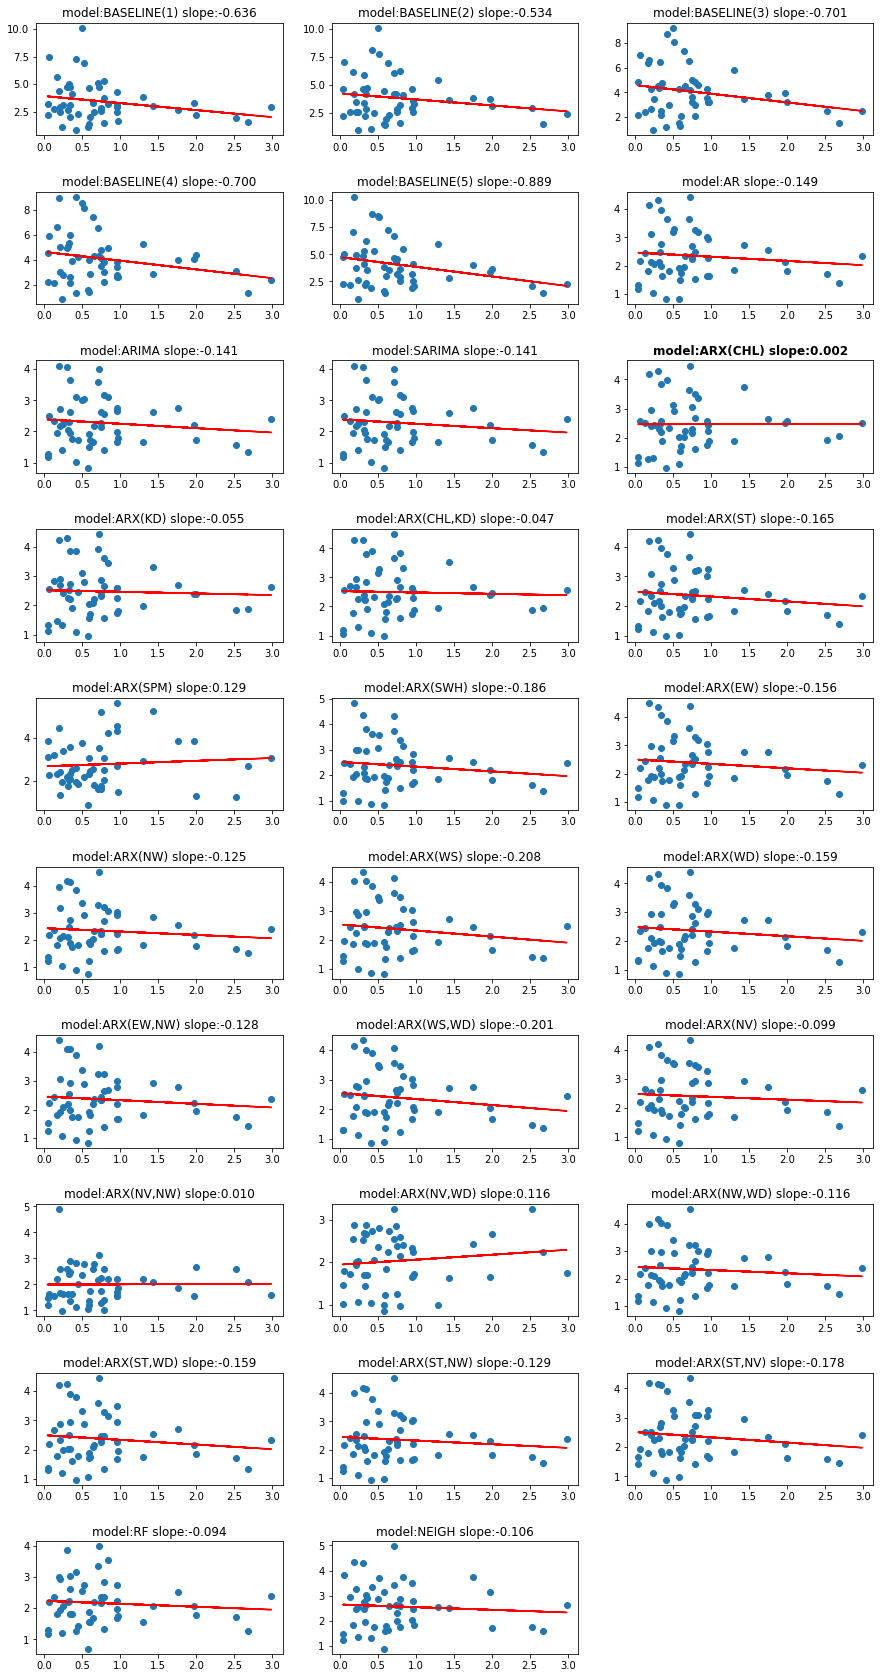

In [ ]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(hspace=0.5)
# plt.suptitle("RMSE V.S. Distance to Coastline", fontsize=18, y=0.9)

gradients = []
model_names = []
rmse = []
variance = []

ix = 0
for model_name in all_rmse:
  if model_name == "Baseline":
    for i in range(5):
      ax = plt.subplot(10, 3, ix + 1)
      ax.scatter(sampled_distance,all_rmse[model_name]["Differentiated"][i])
      a, b = np.polyfit(sampled_distance, all_rmse["Baseline"]["Differentiated"][i], 1)
      ax.plot(sampled_distance, a*sampled_distance+b,color="r")
      # chart formatting
      ax.set_title(f"model:{model_name.upper()}({i+1})"+f" slope:{a:.3f}")
      ax.set_xlabel("")
      gradients.append(a)
      model_names.append(f"{model_name.upper()}({i+1})")
      rmse.append(np.mean(all_rmse[model_name]["Differentiated"][i]))
      variance.append(np.var(all_rmse[model_name]["Differentiated"][i]))
      ix+=1
  elif model_name == "ARX":
    for sub_model_name in all_rmse[model_name]:
      ax = plt.subplot(10, 3, ix + 1)
      ax.scatter(sampled_distance,all_rmse[model_name][sub_model_name])
      a, b = np.polyfit(sampled_distance, all_rmse[model_name][sub_model_name], 1)
      ax.plot(sampled_distance, a*sampled_distance+b,color="r")
      # chart formatting
      if sub_model_name in ["NVNW","CHL"]:
        ax.set_title(f"model:{model_name.upper()}({sub_model_name})"+f" slope:{a:.3f}",fontweight="bold")
        ax.set_xlabel("")
        gradients.append(a)
        model_names.append(f"{model_name.upper()}({sub_model_name})")
        rmse.append(np.mean(all_rmse[model_name][sub_model_name]))
        variance.append(np.var(all_rmse[model_name][sub_model_name]))
        ix+=1
        continue
        
      
      ax.set_title(f"model:{model_name.upper()}({sub_model_name})"+f" slope:{a:.3f}")
      ax.set_xlabel("")
      gradients.append(a)
      model_names.append(f"{model_name.upper()}({sub_model_name})")
      rmse.append(np.mean(all_rmse[model_name][sub_model_name]))
      variance.append(np.var(all_rmse[model_name][sub_model_name]))
      ix+=1
  elif model_name == "AR":
    ax = plt.subplot(10, 3, ix + 1)
    ax.scatter(sampled_distance,all_rmse[model_name]["BIC"])
    a, b = np.polyfit(sampled_distance, all_rmse[model_name]["BIC"], 1)
    ax.plot(sampled_distance, a*sampled_distance+b,color="r")

    # chart formatting
    ax.set_title("model:"+model_name.upper()+f" slope:{a:.3f}")
    ax.set_xlabel("")
    gradients.append(a)
    model_names.append(model_name.upper())
    rmse.append(np.mean(all_rmse[model_name]["BIC"]))
    variance.append(np.var(all_rmse[model_name]["BIC"]))
    ix+=1
  else:
    ax = plt.subplot(10, 3, ix + 1)
    ax.scatter(sampled_distance,all_rmse[model_name])
    a, b = np.polyfit(sampled_distance, all_rmse[model_name], 1)
    ax.plot(sampled_distance, a*sampled_distance+b,color="r")
    # chart formatting
    ax.set_title("model:"+model_name.upper()+f" slope:{a:.3f}")
    ax.set_xlabel("")
    gradients.append(a)
    model_names.append(model_name.upper())
    rmse.append(np.mean(all_rmse[model_name]))
    variance.append(np.var(all_rmse[model_name]))
    ix+=1

plt.savefig("RMSE_against_DtC.png")

In [ ]:
grad_df =  pd.DataFrame([gradients,rmse,variance],columns=model_names).T
grad_df.columns = ["Gradient","Avg RMSE","Variance"]

In [ ]:
# sampled_lat = [lat for lat,lon in sample_idx]
# sampled_lon = [lon for lat,lon in sample_idx]

# medi_only = np.where(water_map!=freq_table[1][0],0,1) # setting all other tiles to 0
# # print(medi_only)

# fig, ax = plt.subplots(figsize=(20,20))
# # medi_only = np.where(medi_only==1,medi_only)
# arr_temp = ((255 - medi_only) / medi_only.max() * 255).astype(np.uint8) # change to blue
# print(arr_temp)
# # arr_temp = np.where(arr_temp==1,,arr_temp)
# img_temp = Image.fromarray(arr_temp)
# ax.imshow(img_temp)
# ax.scatter(x=sampled_lon,y=sampled_lat,c="r")

# for i in range(len(sample_idx)):
#     ax.annotate(i, (sampled_lon[i], sampled_lat[i]),fontsize=20,c="green")

# # ax.scatter(580,131,c="b")
# plt.axis('off')
# plt.show()

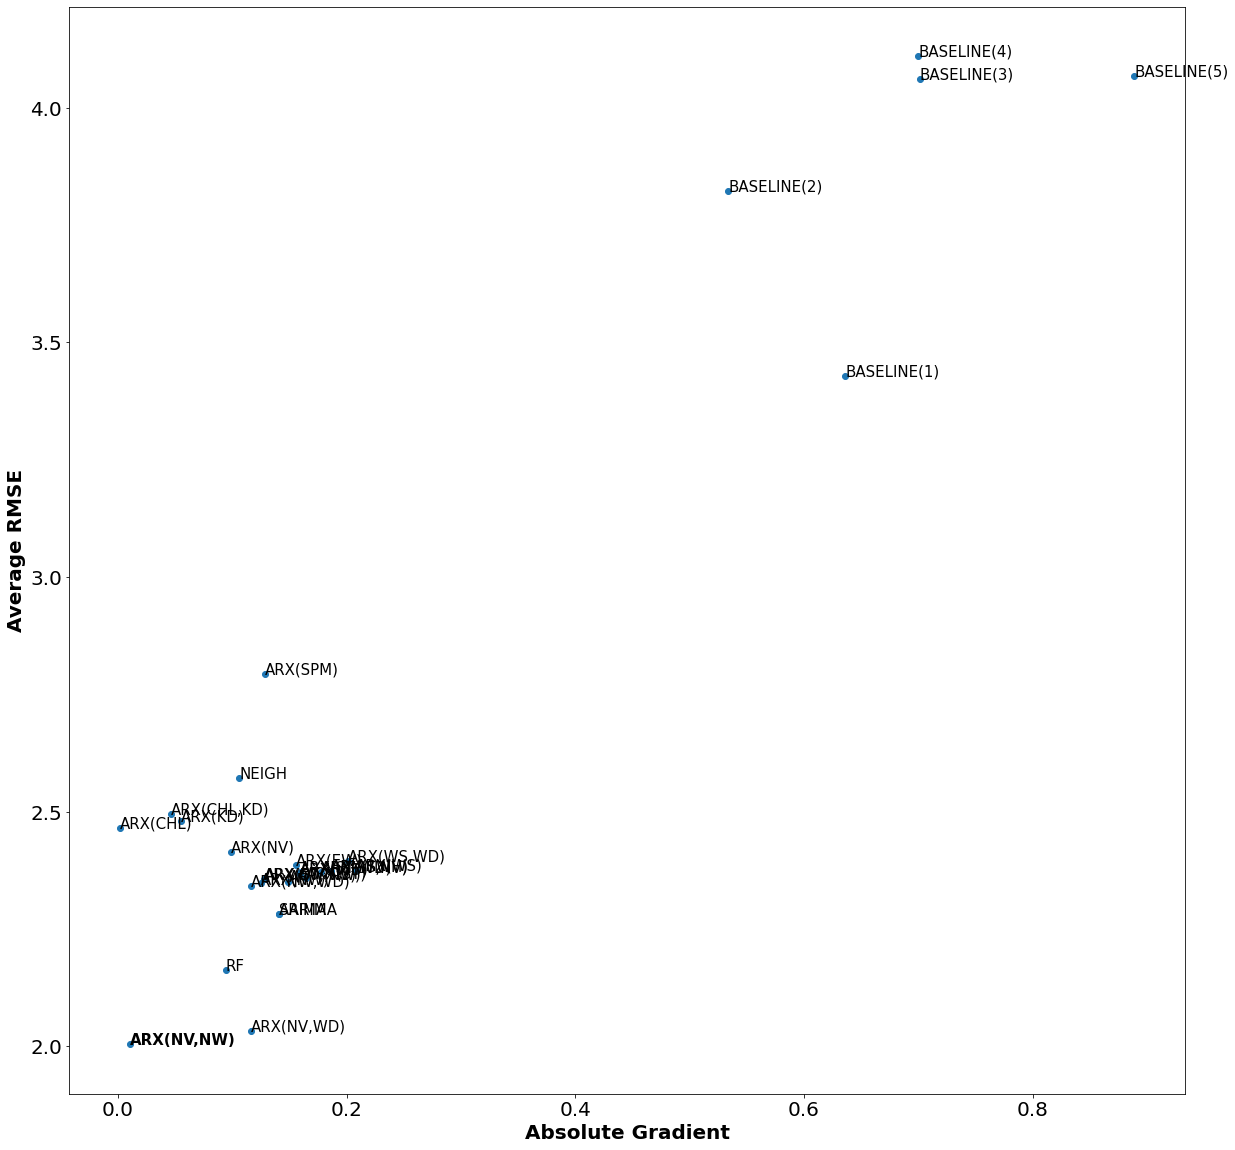

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(grad_df["Gradient"].apply(abs),grad_df["Avg RMSE"])
plt.ylabel("Average RMSE",fontsize=20,fontweight="bold")
plt.xlabel("Absolute Gradient",fontsize=20,fontweight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for i in range(len(model_names)):
  if model_names[i] == "ARX(NV,NW)":
    ax.annotate(model_names[i], (grad_df["Gradient"].apply(abs)[i],grad_df["Avg RMSE"][i]),fontsize=15,c="black",fontweight="bold")
  else:
    ax.annotate(model_names[i], (grad_df["Gradient"].apply(abs)[i],grad_df["Avg RMSE"][i]),fontsize=15,c="black")
plt.savefig("LAG_avgRMSE.png")
plt.show()

In [ ]:
grad_df.sort_values(by = "Gradient")

Gradient  Avg RMSE  Variance
BASELINE(5) -0.888794  4.068234  4.408031
BASELINE(3) -0.701052  4.061999  3.770750
BASELINE(4) -0.699961  4.110024  3.896999
BASELINE(1) -0.636198  3.428722  3.204647
BASELINE(2) -0.533561  3.821823  3.724165
ARX(WS)     -0.208311  2.374874  0.756214
ARX(WSWD)   -0.201026  2.394648  0.754361
ARX(SWH)    -0.186006  2.372903  0.816053
ARX(STNV)   -0.177771  2.371616  0.713696
ARX(ST)     -0.164686  2.358033  0.709311
ARX(STWD)   -0.159416  2.371934  0.722795
ARX(WD)     -0.158914  2.367537  0.762768
ARX(EW)     -0.155586  2.385787  0.768218
AR          -0.149242  2.350710  0.765422
SARIMA      -0.141197  2.281132  0.605696
ARIMA       -0.140998  2.281639  0.606272
ARX(STNW)   -0.128576  2.356827  0.691982
ARX(EWNW)   -0.128091  2.356800  0.723512
ARX(NW)     -0.125109  2.346789  0.743380
ARX(NWWD)   -0.116086  2.340606  0.734696
NEIGH       -0.106087  2.571290  0.768185
ARX(NV)     -0.098753  2.413665  0.745218
RF          -0.094303  2.162184  0.490503
ARX(KD)     -0.055336  2.480567  0.711215
ARX(CHLKD)  -0.046673  2.494489  0.720664
ARX(CHL)     0.001744  2.464538  0.712766
ARX(NVNW)    0.010305  2.003757  0.483438
ARX(NVWD)    0.116318  2.033256  0.408855
ARX(SPM)     0.128787  2.792910  1.214788

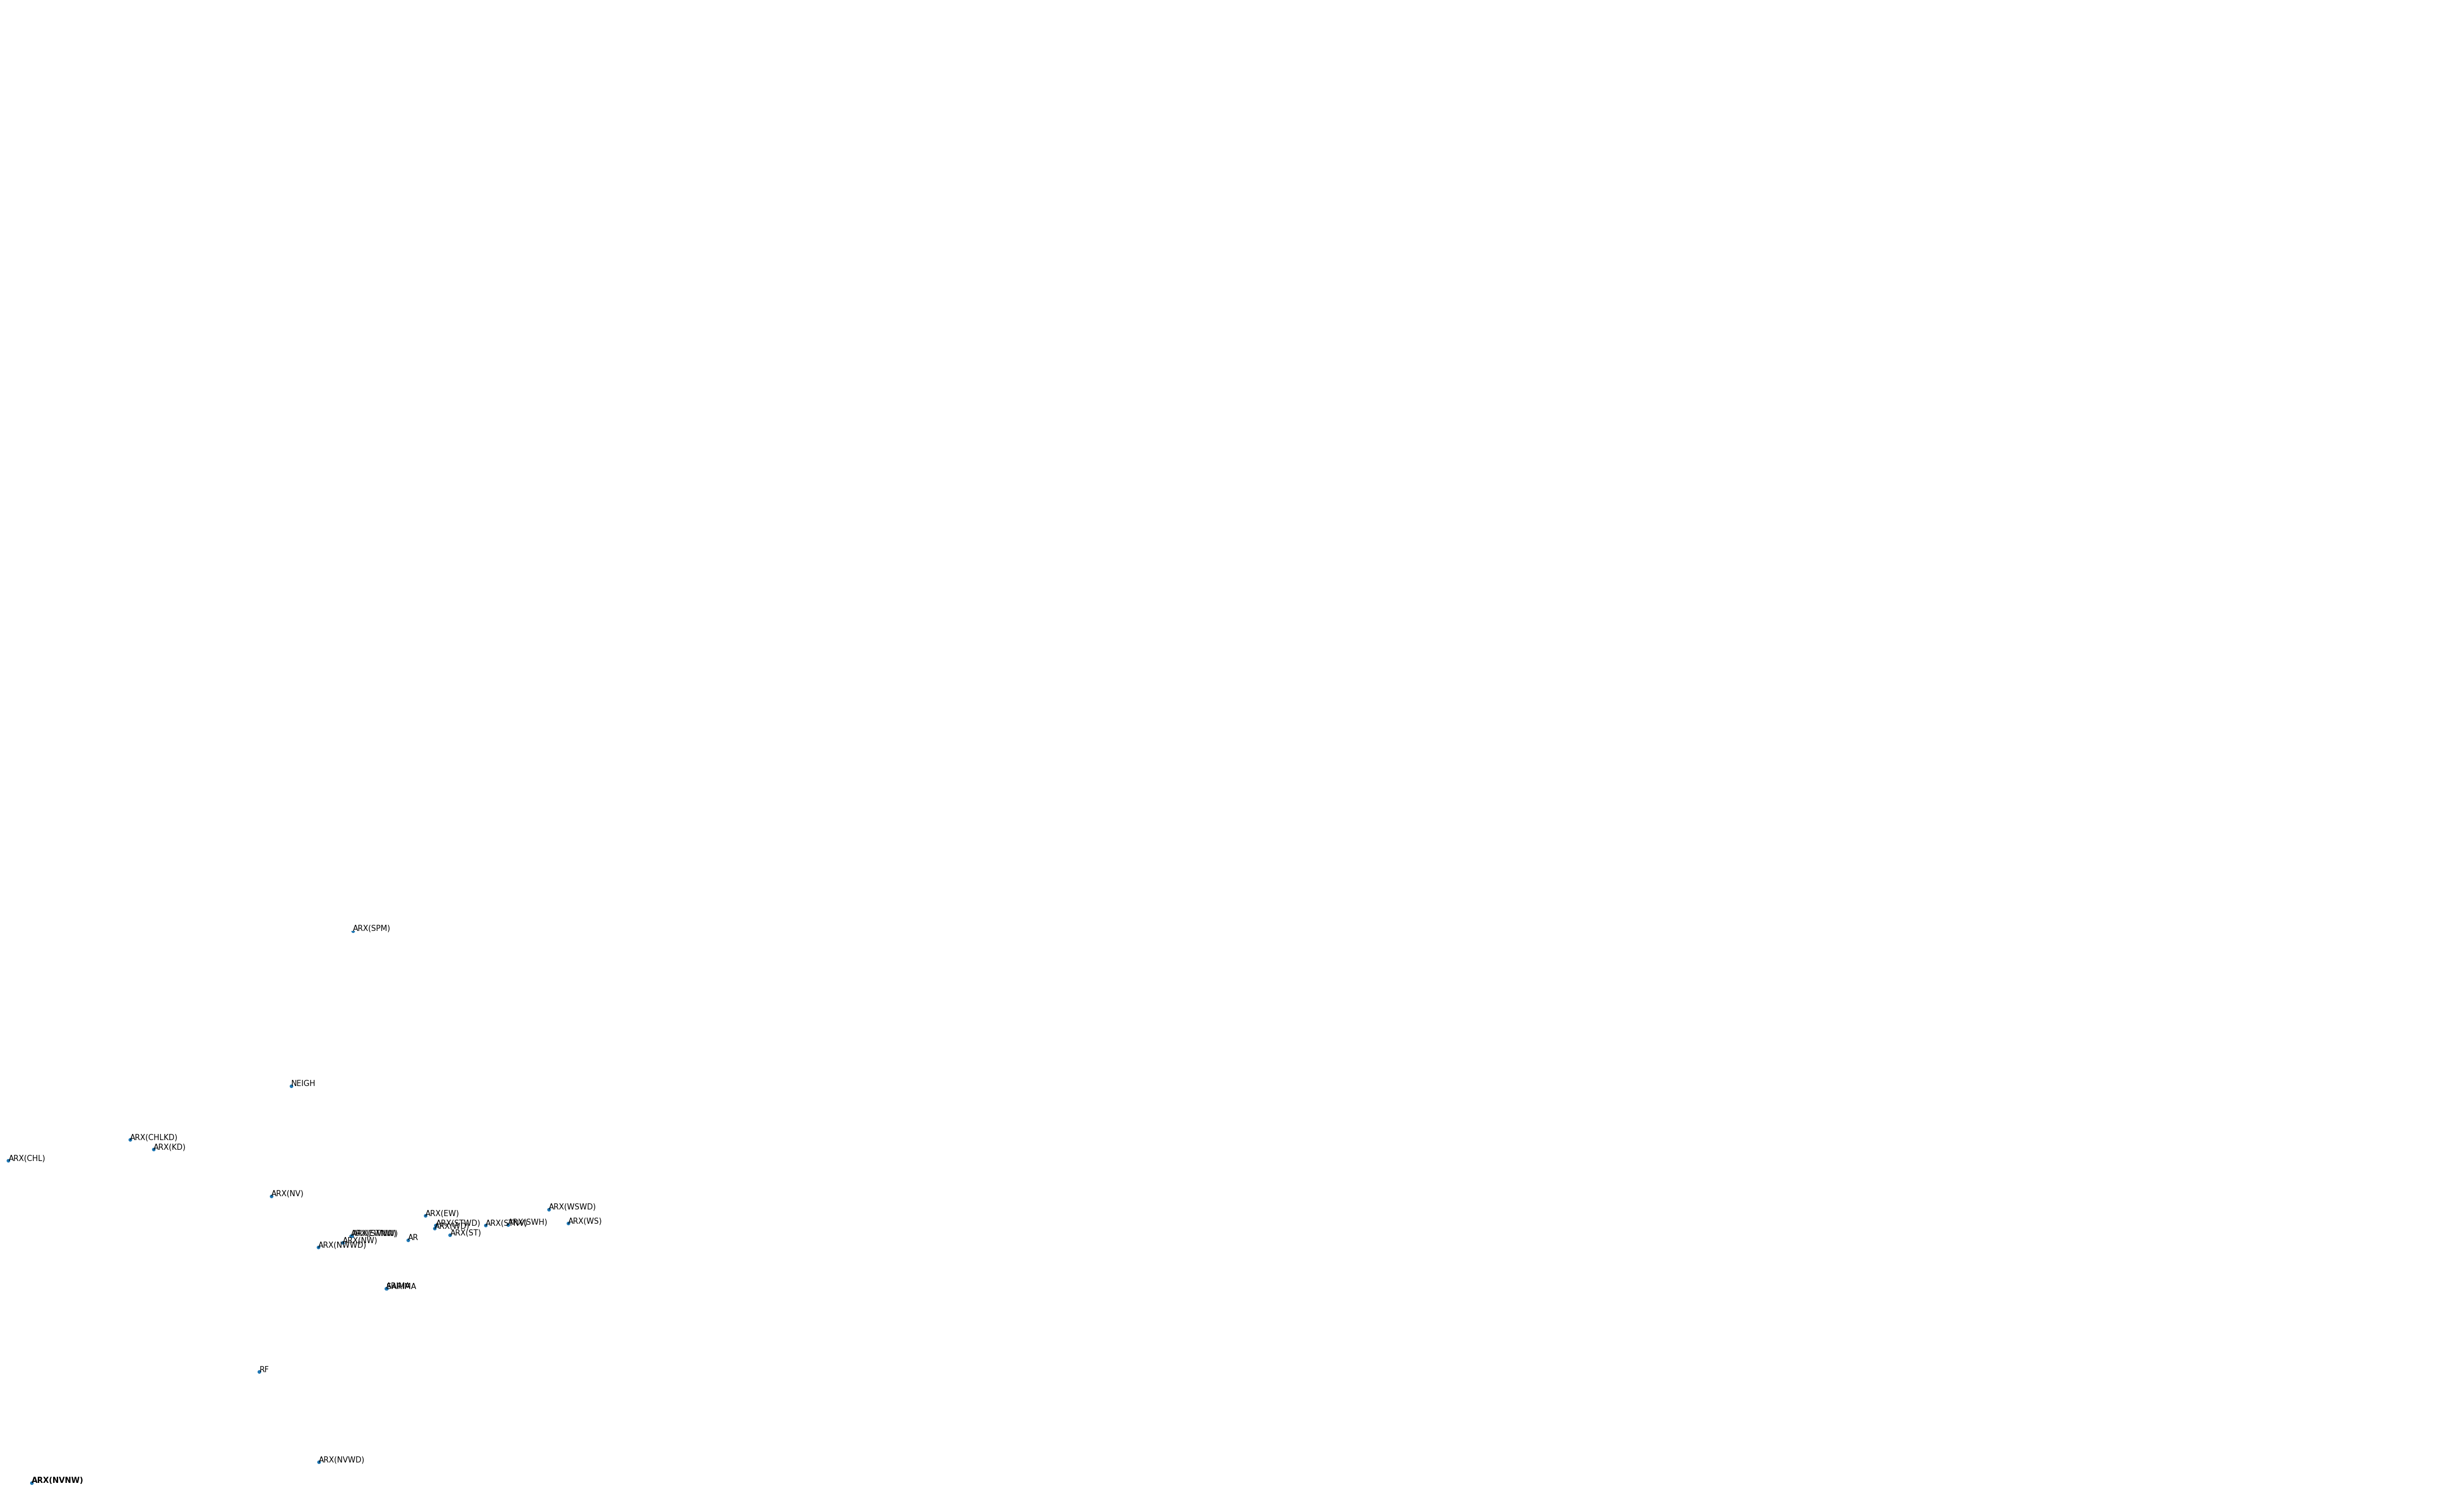

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
# plt.ylim((1.9,3))
# plt.xlim((0,0.4))
ax.scatter(grad_df["Gradient"].apply(abs),grad_df["Avg RMSE"])
ax.set_xlim([0,0.21])
ax.set_ylim([2,2.793])
# plt.ylabel("Average RMSE",fontsize=20,fontweight="bold")
# plt.xlabel("Absolute Gradient",fontsize=20,fontweight="bold")
plt.axis("off")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for i in range(len(model_names)):
  if model_names[i] == "ARX(NVNW)":
    ax.annotate(model_names[i], (grad_df["Gradient"].apply(abs)[i],grad_df["Avg RMSE"][i]),fontsize=15,c="black",fontweight="bold")
  else:
    ax.annotate(model_names[i], (grad_df["Gradient"].apply(abs)[i],grad_df["Avg RMSE"][i]),fontsize=15,c="black")

plt.savefig("LAG_avgRMSE_withoutBaseline.png")
plt.show()

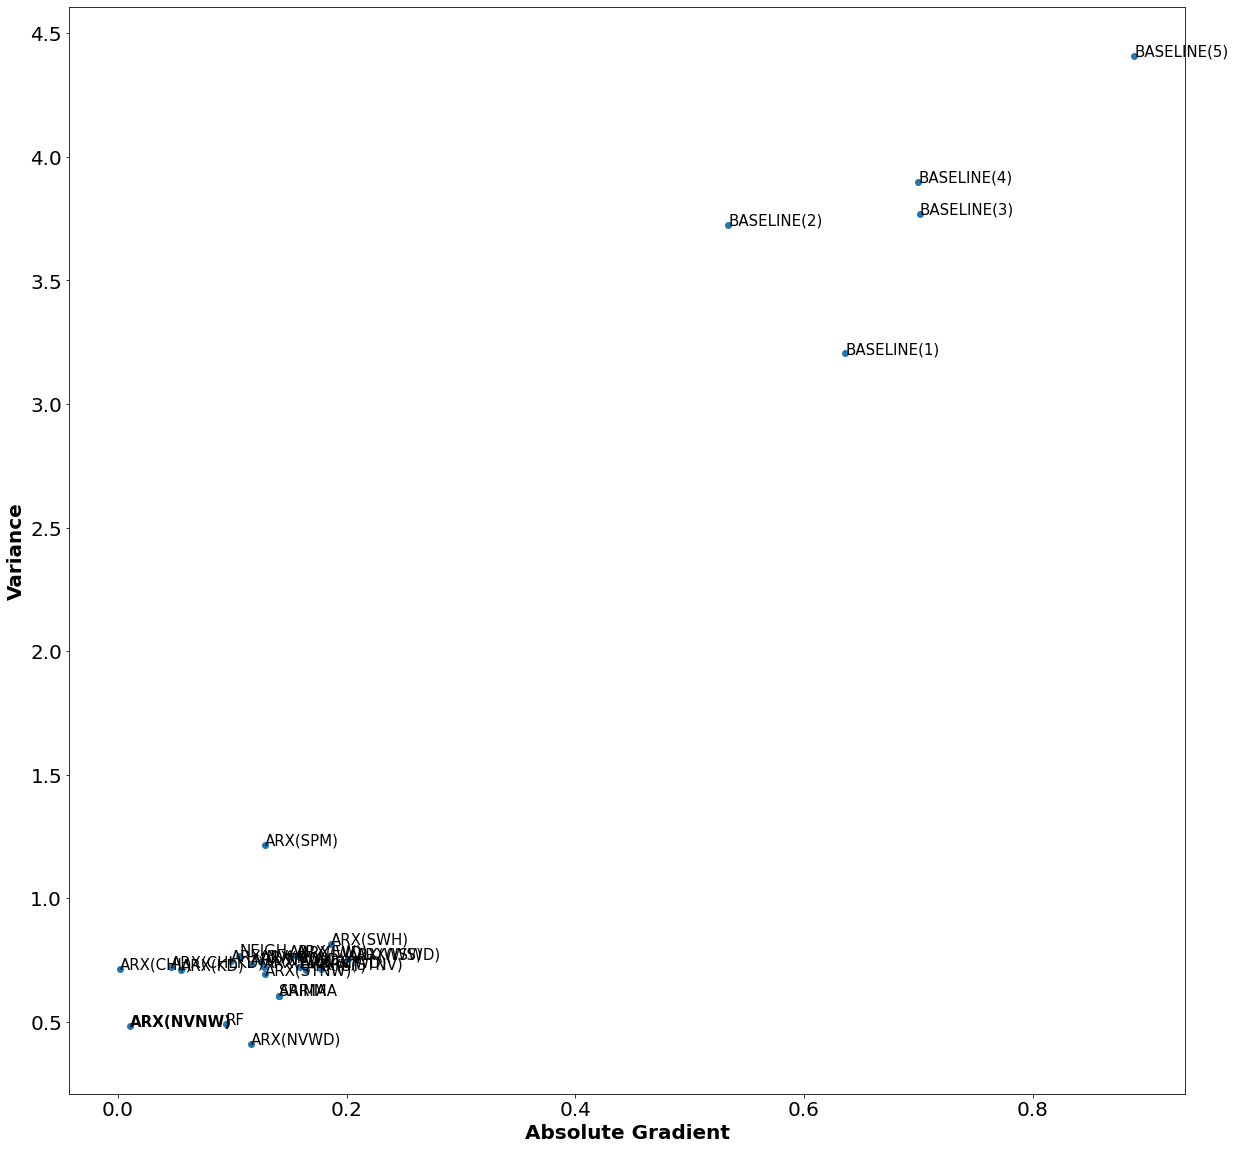

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(grad_df["Gradient"].apply(abs),grad_df["Variance"])
plt.ylabel("Variance",fontsize=20,fontweight="bold")
plt.xlabel("Absolute Gradient",fontsize=20,fontweight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for i in range(len(model_names)):
  if model_names[i] == "ARX(NVNW)":
    ax.annotate(model_names[i], (grad_df["Gradient"].apply(abs)[i],grad_df["Variance"][i]),fontsize=15,c="black",fontweight="bold")
  else:
    ax.annotate(model_names[i], (grad_df["Gradient"].apply(abs)[i],grad_df["Variance"][i]),fontsize=15,c="black")
plt.savefig("LAG_variance.png")
plt.show()

In [ ]:
grad_df[grad_df["Gradient"]>0].sort_values(by="Gradient",ascending=False)

Gradient  Avg RMSE  Variance
ARX(SPM)   0.128787  2.792910  1.214788
ARX(NVWD)  0.116318  2.033256  0.408855
ARX(NVNW)  0.010305  2.003757  0.483438
ARX(CHL)   0.001744  2.464538  0.712766

In [ ]:
grad_df[grad_df["Gradient"]<0].sort_values(by="Gradient",ascending=False).tail(10).round(decimals = 3).to_latex(index=True)

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  Gradient &  Avg RMSE &  Variance \\\\\n\\midrule\nARX(ST)     &    -0.165 &     2.358 &     0.709 \\\\\nARX(STNV)   &    -0.178 &     2.372 &     0.714 \\\\\nARX(SWH)    &    -0.186 &     2.373 &     0.816 \\\\\nARX(WSWD)   &    -0.201 &     2.395 &     0.754 \\\\\nARX(WS)     &    -0.208 &     2.375 &     0.756 \\\\\nBASELINE(2) &    -0.534 &     3.822 &     3.724 \\\\\nBASELINE(1) &    -0.636 &     3.429 &     3.205 \\\\\nBASELINE(4) &    -0.700 &     4.110 &     3.897 \\\\\nBASELINE(3) &    -0.701 &     4.062 &     3.771 \\\\\nBASELINE(5) &    -0.889 &     4.068 &     4.408 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
grad_df.apply(abs).sort_values(by="Gradient",ascending=False).round(decimals = 3).head(10).to_latex(index=True)

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  Gradient &  Avg RMSE &  Variance \\\\\n\\midrule\nBASELINE(5) &     0.889 &     4.068 &     4.408 \\\\\nBASELINE(3) &     0.701 &     4.062 &     3.771 \\\\\nBASELINE(4) &     0.700 &     4.110 &     3.897 \\\\\nBASELINE(1) &     0.636 &     3.429 &     3.205 \\\\\nBASELINE(2) &     0.534 &     3.822 &     3.724 \\\\\nARX(WS)     &     0.208 &     2.375 &     0.756 \\\\\nARX(WSWD)   &     0.201 &     2.395 &     0.754 \\\\\nARX(SWH)    &     0.186 &     2.373 &     0.816 \\\\\nARX(STNV)   &     0.178 &     2.372 &     0.714 \\\\\nARX(ST)     &     0.165 &     2.358 &     0.709 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
grad_df.sort_values(by="Gradient").head(10)

Gradient  Avg RMSE  Variance
BASELINE(5) -0.888794  4.068234  4.408031
BASELINE(3) -0.701052  4.061999  3.770750
BASELINE(4) -0.699961  4.110024  3.896999
BASELINE(1) -0.636198  3.428722  3.204647
BASELINE(2) -0.533561  3.821823  3.724165
ARX(WS)     -0.208311  2.374874  0.756214
ARX(WSWD)   -0.201026  2.394648  0.754361
ARX(SWH)    -0.186006  2.372903  0.816053
ARX(STNV)   -0.177771  2.371616  0.713696
ARX(ST)     -0.164686  2.358033  0.709311

In [ ]:
grad_df.sort_values(by="Gradient",ascending=False).head(10)

Gradient  Avg RMSE  Variance
ARX(SPM)    0.128787  2.792910  1.214788
ARX(NVWD)   0.116318  2.033256  0.408855
ARX(NVNW)   0.010305  2.003757  0.483438
ARX(CHL)    0.001744  2.464538  0.712766
ARX(CHLKD) -0.046673  2.494489  0.720664
ARX(KD)    -0.055336  2.480567  0.711215
RF         -0.094303  2.162184  0.490503
ARX(NV)    -0.098753  2.413665  0.745218
NEIGH      -0.106087  2.571290  0.768185
ARX(NWWD)  -0.116086  2.340606  0.734696

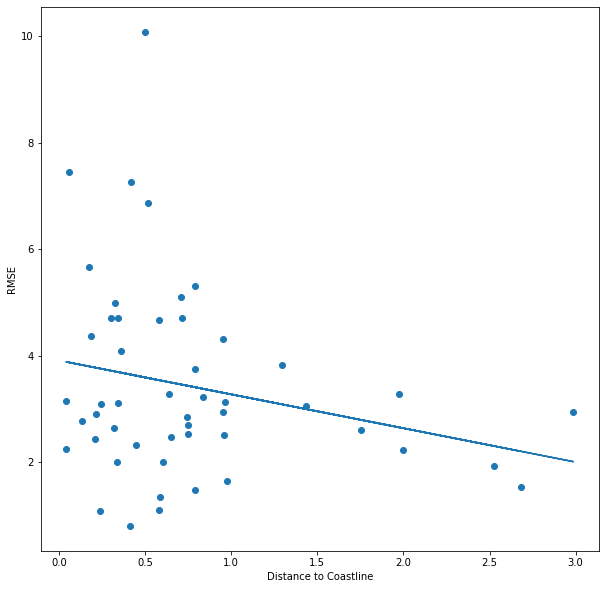

-0.6361981531820033 3.913914238052538


In [ ]:
i = 0
plt.figure(figsize=(10,10))
plt.scatter(sampled_distance,all_rmse["Baseline"]["Differentiated"][i])
a, b = np.polyfit(sampled_distance, all_rmse["Baseline"]["Differentiated"][i], 1)
plt.plot(sampled_distance, a*sampled_distance+b)
plt.ylabel("RMSE")
plt.xlabel("Distance to Coastline")
plt.show()
print(a,b)

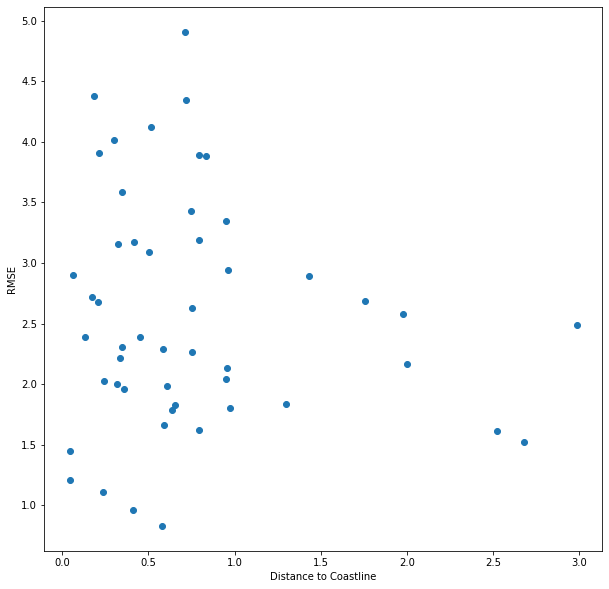

In [ ]:
i = 2
plt.figure(figsize=(10,10))
plt.scatter(sampled_distance,all_rmse["Baseline"]["Undifferentiated"][i])
plt.ylabel("RMSE")
plt.xlabel("Distance to Coastline")
plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# plt.scatter(sampled_distance,all_rmse["AR"]["AIC"])
# plt.ylabel("RMSE")
# plt.xlabel("Distance to Coastline")
# plt.show()

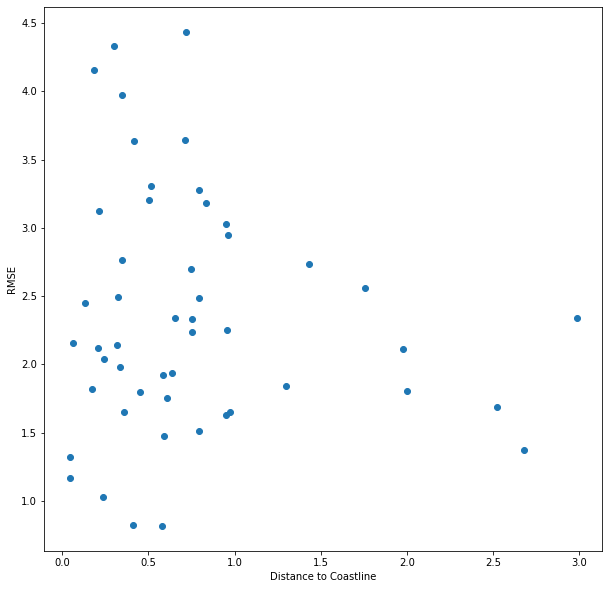

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(sampled_distance,all_rmse["AR"]["BIC"])
plt.ylabel("RMSE")
plt.xlabel("Distance to Coastline")
plt.show()

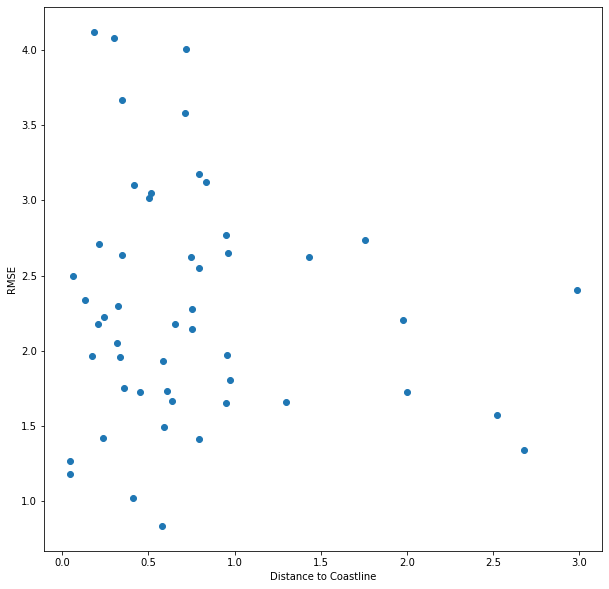

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(sampled_distance,all_rmse["ARIMA"])
plt.ylabel("RMSE")
plt.xlabel("Distance to Coastline")
plt.show()

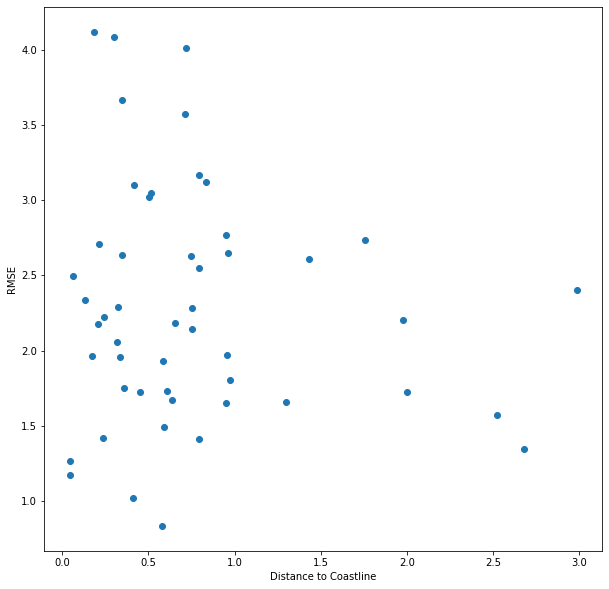

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(sampled_distance,all_rmse["SARIMA"])
plt.ylabel("RMSE")
plt.xlabel("Distance to Coastline")
plt.show()

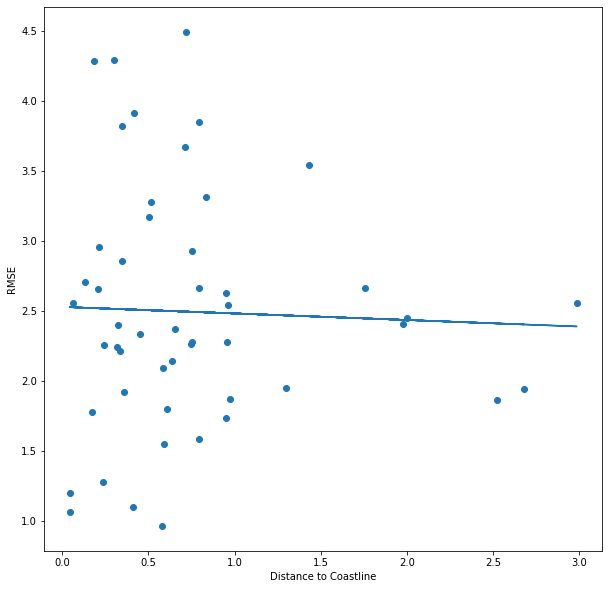

-0.046673487540304745 2.530084249001011


In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(sampled_distance,all_rmse["ARX"]["CHLKD"])
a, b = np.polyfit(sampled_distance, all_rmse["ARX"]["CHLKD"], 1)
plt.plot(sampled_distance, a*sampled_distance+b)
plt.ylabel("RMSE")
plt.xlabel("Distance to Coastline")
plt.show()
print(a,b)

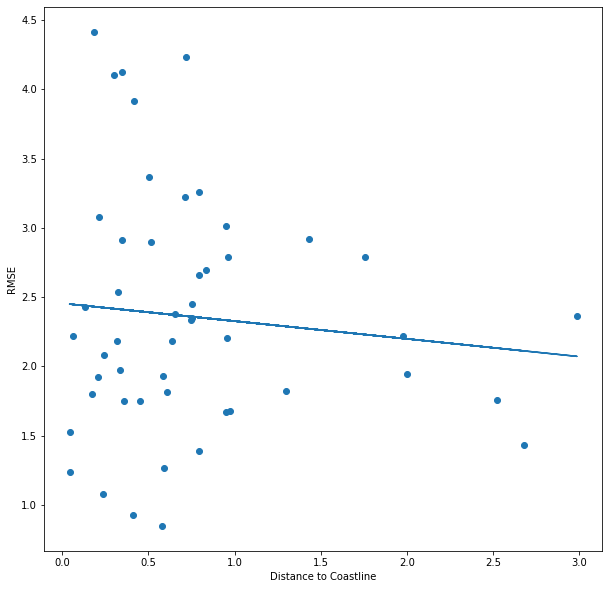

-0.1280910879473344 2.4544881735536133


In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(sampled_distance,all_rmse["ARX"]["EWNW"])
a, b = np.polyfit(sampled_distance, all_rmse["ARX"]["EWNW"], 1)
plt.plot(sampled_distance, a*sampled_distance+b)
plt.ylabel("RMSE")
plt.xlabel("Distance to Coastline")
plt.show()
print(a,b)

TODO:

- Bin the distance to coastline, and for each bin take the average/median
- plot x is distance to coastline, y is mean value of secchi depth/ variance of secchi depyh
- plot x is ... , y is abs(estimate - true value) / min(estimate, true value), or abs(estimate - true value) / true value or estimate/(true value)


In [ ]:
sampled_distance.shape

(50,)

In [ ]:
collect_rmse_arx_st

array([3.00720962, 1.75263216, 1.02147856, 2.49176713, 2.09087468,
       4.20909655, 3.63666633, 0.97339951, 1.7984312 , 1.82810008,
       3.07736669, 2.2911706 , 1.82983241, 2.4122894 , 2.34454847,
       1.82974266, 3.27393522, 2.52828855, 1.68111029, 2.01087762,
       2.2241481 , 1.40180245, 1.64839486, 3.19228037, 1.61398762,
       2.511328  , 3.2161324 , 1.23154891, 3.23726582, 3.95035907,
       1.63368385, 3.75527845, 2.23853419, 1.97948976, 2.34819671,
       4.19720505, 1.7196897 , 2.74974345, 1.55362773, 2.47254686,
       2.17929496, 1.10856406, 2.33509375, 2.45657612, 1.32634562,
       1.90355163, 2.17292642, 2.17512283, 4.41769191, 2.86239936])

In [ ]:
collect_prediction_arx_st.shape

(50, 10)

In [ ]:
ZSD_arr[:,-10:].shape

(50, 10)

In [ ]:
(collect_prediction_arx_st - ZSD_arr[:,-10:]).min(axis=1)

array([ -6.81869802,  -3.27510642,  -1.75142688,  -3.26244159,
        -5.37275618,  -7.95192249,  -5.75452841,  -2.49679632,
        -4.2006336 ,  -2.50808923,  -7.38524018,  -4.08790568,
        -2.07646096,  -5.59029742,  -5.6408242 ,  -2.30212396,
        -6.27237452,  -3.63722881,  -3.799127  ,  -2.55197811,
        -3.97249591,  -2.3485627 ,  -2.75754458,  -7.53142561,
        -1.29146446,  -3.42563263,  -6.51087594,  -1.66289985,
        -4.29970841,  -8.30494601,  -1.84799796,  -7.14071096,
        -3.27494795,  -4.45215959,  -4.41098594, -12.91452818,
        -3.59555594,  -4.49989009,  -3.76129322,  -4.50804338,
        -5.18981766,  -2.17145479,  -4.18503643,  -5.6637501 ,
        -1.94498463,  -3.30338975,  -3.42356191,  -5.57226537,
        -7.32327729,  -2.56246373])

In [ ]:
shishi = abs(collect_prediction_arx_st - ZSD_arr[:,-10:]).mean(axis=1)/(collect_prediction_arx_st - ZSD_arr[:,-10:]).min(axis=1)

In [ ]:
eOverT = collect_prediction_arx_st/ZSD_arr[:,-10:]

In [ ]:
eOverT.mean(axis=1).shape

(50,)

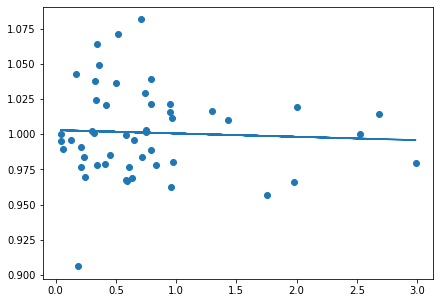

-0.0023738840676688785 1.0029636544218528


In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(sampled_distance,eOverT.mean(axis=1))
a, b = np.polyfit(sampled_distance, eOverT.mean(axis=1), 1)
plt.plot(sampled_distance, a*sampled_distance+b)
plt.show()
print(a,b)

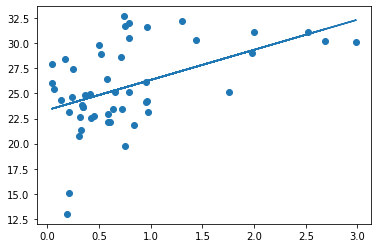

2.999395183185348 23.344568140057714


In [ ]:
plt.scatter(sampled_distance,ZSD_arr[:,:].mean(axis=1))
a, b = np.polyfit(sampled_distance, ZSD_arr[:,:].mean(axis=1), 1)
plt.plot(sampled_distance, a*sampled_distance+b)
plt.show()
print(a,b)

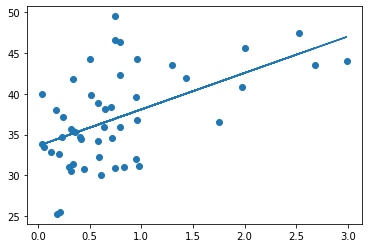

4.473939508206212 33.60176588323927


In [ ]:
plt.scatter(sampled_distance,ZSD_arr[:,:].max(axis=1))
a, b = np.polyfit(sampled_distance, ZSD_arr[:,:].max(axis=1), 1)
plt.plot(sampled_distance, a*sampled_distance+b)
plt.show()
print(a,b)

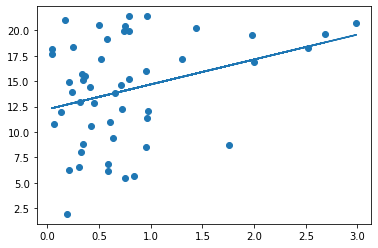

2.4495717611830496 12.23946490107177


In [ ]:
plt.scatter(sampled_distance,ZSD_arr[:,:].min(axis=1))
a, b = np.polyfit(sampled_distance, ZSD_arr[:,:].min(axis=1), 1)
plt.plot(sampled_distance, a*sampled_distance+b)
plt.show()
print(a,b)

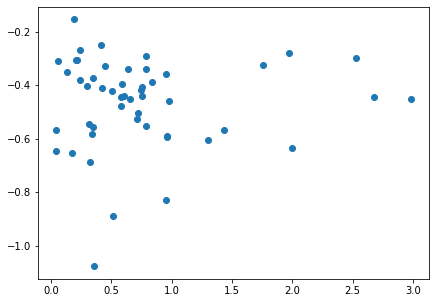

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(sampled_distance,shishi)
plt.show()

TODO:
- Choose the best model, and evalaute it using difference metric descibe above.

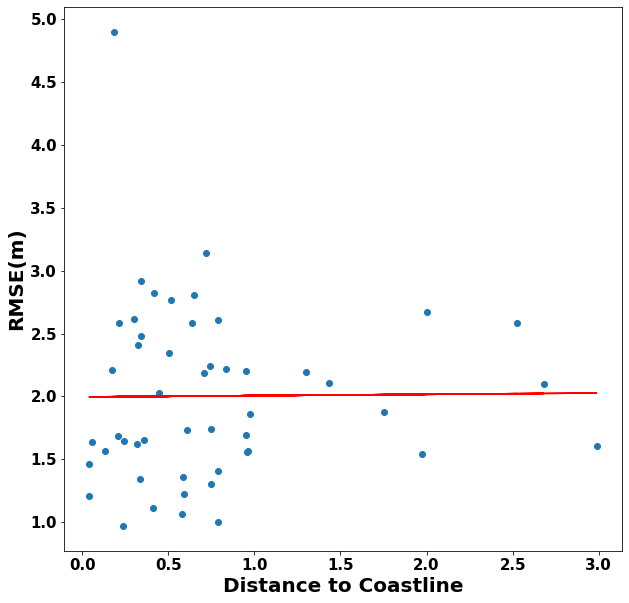

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(10,10))
plt.scatter(sampled_distance,all_rmse["ARX"]["NVNW"])
a, b = np.polyfit(sampled_distance, all_rmse["ARX"]["NVNW"], 1)
plt.plot(sampled_distance, a*sampled_distance+b,color="r")
# plt.ylabel("RMSE")
plt.xlabel("Distance to Coastline",fontweight="bold",fontsize=20)
ax.set_ylabel("RMSE(m)",fontsize=20,fontweight="bold")
plt.yticks(fontsize=15,fontweight="bold")
plt.xticks(fontsize=15,fontweight="bold")
plt.show()

## Outliers across models

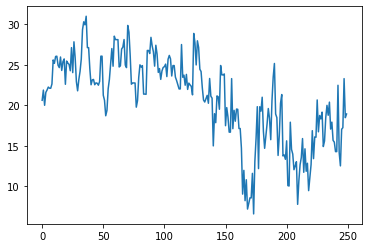

In [ ]:
plt.plot(ZSD_arr[5,:])
plt.show()

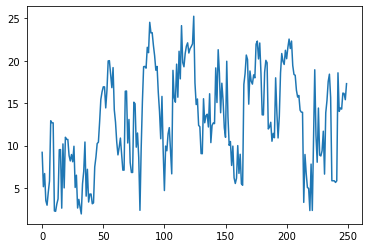

In [ ]:
plt.plot(ZSD_arr[35,:])
plt.show()

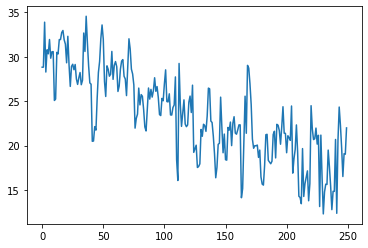

In [ ]:
plt.plot(ZSD_arr[48,:])
plt.show()

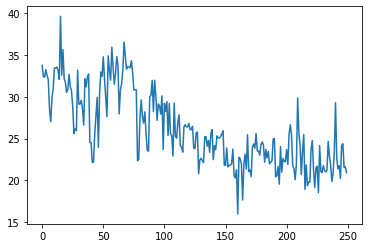

In [ ]:
plt.plot(ZSD_arr[0,:])
plt.show()